<a href="https://colab.research.google.com/github/MaryamSeyyedi/ReQuEST-and-Multi-Doc-Summarization/blob/main/ReQuEST_and_MDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this document we have:
1. an encoder which is shared between all tasks, and a decoder which only used for summarization
2. a new function for calculating **ROUGE **(1(F,R,P) & 2(F,R,P))
3. a new module for **Tag Generation** (Multi-task *from the third layer of Decoder + another 3 layer decoder*).

>```
>  input: Question1,
>  target keywords: Question1's tags
>```

4. (Question1 + Tags) as the input of **summarization** encoder, and (Target) as the input of summarization decoder. Tags are selected based on the RQE-label.
input:
        if label==0 ==> [Question1 + Question1's tags]
        if label==1 ==> [Question1 + Question2's tags]
target summary:
        if label==0 ==> Question1's title
        if label==1 ==> Question2


## ⭕🌞 **Access to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## ⭕🌞 **Import libraries**

In [ ]:
from typing import Tuple
import nltk
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sklearn
from sklearn import metrics
import sys
import datetime
from datetime import timedelta
from statistics import mean
import copy


# ===================== Transformers and BART =====================
INSTALL_MSG = """
Bart will be released through pip in v 3.0.0, until then use it by installing from source:
git clone git@github.com:huggingface/transformers.git
git checkout d6de6423
cd transformers
pip install -e ".[dev]"
"""
try:
  !pip install transformers
  import transformers
  from transformers import BartTokenizer, BartTokenizerFast, BartModel, BartForConditionalGeneration, BartConfig, BartPretrainedModel
  from transformers import get_linear_schedule_with_warmup
  from transformers.modeling_outputs import Seq2SeqLMOutput, BaseModelOutput
except ImportError:
  raise ImportError(INSTALL_MSG)


# ========================= Torch AND GPU =========================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler, Dataset, SequentialSampler
!pip install torchsummary
from torchsummary import summary
if torch.cuda.is_available():

    device = torch.device("cuda")                                                 # Tell PyTorch to use the GPU.
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# ============ To save AutoGrad graph (in Backward mode) ===========
!pip install torchviz
from torchviz import make_dot


# ======================= To use ROUGE Metrics =====================
# !pip install datasets
# import datasets
# from datasets import load_metric
# !pip install Summ-Eval
# !pip install rouge_score
# from datasets import load_metric
# metric = load_metric("rouge")

!pip install torchmetrics
from torchmetrics.text.rouge import ROUGEScore
metric = ROUGEScore( rouge_keys = ("rouge1", "rouge2", "rouge3", "rouge4", "rougeL"))

!pip install bert_score
from bert_score import score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=822a0de4ad467398e265929d9e8d5c274b88233cc752486a3e4aa4b5b71da9f9
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00


## 🌞 **Import Final Dataset**

In [ ]:
QuestionPairsStandardDF = pd.read_pickle("/content/drive/MyDrive/Sum-RQE/dataframes/final-dataset-compared-new.pkl")
display(QuestionPairsStandardDF)

# # ================== Create third dataset final dataset3.pkl =================
# #       This dataset has equal number of positive and negative samples
# # ============================================================================
# df1 = QuestionPairsStandardDF[(QuestionPairsStandardDF.is_duplicate	==1)]                            # Samples with is_duplicate	 = 1
# df0 = QuestionPairsStandardDF[(QuestionPairsStandardDF.is_duplicate	==0)]                            # Samples with is_duplicate	 = 0

# fraction = 100/2                                                                           # Select Non-duplicate samples as much as positive ones
# df0 = df0.sample(frac=(fraction/len(df0)), random_state=46)                                  # .sample(frac=1) is used t shuffle the data
# df1 = df1.sample(frac=(fraction/len(df1)), random_state=46)                                  # .sample(frac=1) is used t shuffle the data
# QuestionPairsStandardDF = pd.concat([df1, df0])
# display(QuestionPairsStandardDF)
# # pd.to_pickle(QuestionPairsStandardDF, "/content/drive/MyDrive/Sum-RQE/dataframes/final-dataset-compared-new2.pkl")
# print('Number of duplicate samples: ', len(df1))
# print('Number of non-duplicate samples: ', len(df0))

# QuestionPairsStandardDF = pd.read_pickle("/content/drive/MyDrive/Sum-RQE/dataframes/final-dataset-compared-new2.pkl")
# display(QuestionPairsStandardDF)

# df1 = QuestionPairsStandardDF[(QuestionPairsStandardDF.is_duplicate	==1)]                            # Samples with is_duplicate	 = 1
# df0 = QuestionPairsStandardDF[(QuestionPairsStandardDF.is_duplicate	==0)]                            # Samples with is_duplicate	 = 0
# fraction = 100/2                                                                           # Select Non-duplicate samples as much as positive ones
# df0 = df0.sample(frac=(fraction/len(df0)), random_state=46)                                  # .sample(frac=1) is used t shuffle the data
# df1 = df1.sample(frac=(fraction/len(df1)), random_state=46)                                  # .sample(frac=1) is used t shuffle the data
# QuestionPairsStandardDF = pd.concat([df1, df0])
# display(QuestionPairsStandardDF)

FileNotFoundError: ignored

## 🌞 **Data pre-process**

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')

def PreprocessText (txt, txttype='S'):
  dropORnot = False
  # tokenizer = nltk.RegexpTokenizer(r"\w+")
  # new_txt = tokenizer.tokenize(txt)
  if (txttype == 'T'):
    txt = " ".join(txt)
  txt = txt.replace('-', ' ')
  new_txt = txt.translate(str.maketrans('', '', string.punctuation))
  new_txt = nltk.word_tokenize(new_txt)
  # new_txt= [word for word in words if word.isalnum()]
  if len(new_txt)<1:
    dropORnot = True
  filtered_sentence = ' '.join(new_txt)

  # stop_words = set(stopwords.words('english'))
  # word_tokens = word_tokenize(filtered_sentence)
  # filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]       # Remove stop
  # filtered_sentence = ' '.join(filtered_sentence)
  return filtered_sentence, dropORnot


Remove_list = []
for index,row in QuestionPairsStandardDF.iterrows():
  filtered_sentence, dropORnot = PreprocessText(row['long_text'])
  QuestionPairsStandardDF.at[index, 'long_text'] = filtered_sentence

  filtered_sentence, dropORnot = PreprocessText(row['short_text'])
  if (dropORnot):
    print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
    Remove_list.append(index)
  else:
    QuestionPairsStandardDF.at[index, 'short_text'] = filtered_sentence

  filtered_sentence, dropORnot = PreprocessText(row['long_text_title'])
  if (dropORnot):
    print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
    Remove_list.append(index)
  else:
    QuestionPairsStandardDF.at[index, 'long_text_title'] = filtered_sentence

  filtered_sentence, dropORnot = PreprocessText(row['long_text_tags'], 'T')
  if (dropORnot):
    print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
    Remove_list.append(index)
  else:
    QuestionPairsStandardDF.at[index, 'long_text_tags'] = filtered_sentence

  filtered_sentence, dropORnot = PreprocessText(row['short_text_tags'], 'T')
  if (dropORnot):
    print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
    Remove_list.append(index)
  else:
    QuestionPairsStandardDF.at[index, 'short_text_tags'] = filtered_sentence

Remove_list.append(32828)
for ind in set(Remove_list):
  print(str(ind) + " is removed from dataframe.")
  QuestionPairsStandardDF = QuestionPairsStandardDF.drop(index = ind)


# for index,row in QuestionPairsStandardDF.iterrows():
#   QuestionPairsStandardDF.at[index, 'long_text'] = PreprocessText(row['long_text'])
#   QuestionPairsStandardDF.at[index, 'short_text'] = PreprocessText(row['short_text'])
#   QuestionPairsStandardDF.at[index, 'long_text_title'] = PreprocessText(row['long_text_title'])

display(QuestionPairsStandardDF)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NameError: ignored

# ⭕🌞 **Proposed Model**

## 🔧 **NN-RQE**
**Neural Network Head for Recognizing Question Entailment**

In [ ]:
class NN_model_RQE(nn.Module):
  def __init__(self,embed_size, Dimensions, do_r, lr):
    super(NN_model_RQE, self).__init__()
    self.learning_rate = lr                                                       # learning rate
    self.activ = nn.Tanh()                                                        # Relu activation function
    self.fc1 = nn.Linear(embed_size, Dimensions[0])                               # Fully-connected Layer 1 (Linear)
    self.fc2 = nn.Linear(Dimensions[0], Dimensions[1])                            # Fully-connected Layer 2 (Linear)
    self.fc3 = nn.Linear(Dimensions[1], Dimensions[2])                            # Fully-connected Layer 3 (Linear)
    self.bn1 = nn.BatchNorm1d(Dimensions[0])                                      # batch-normalization layer 1
    self.bn2 = nn.BatchNorm1d(Dimensions[1])                                      # batch-normalization layer 1
    self.bn3 = nn.BatchNorm1d(Dimensions[2])                                      # batch-normalization layer 1
    self.dropout = nn.Dropout(do_r)                                               # dropout layer
    self.softmax = nn.Softmax(dim=-1)                                             # softmax activation function

  def forward(self, decoder_last_embd):                                           # decoder_last_embd: The last embedding of the last token
    x = decoder_last_embd
    # x = self.dropout(x)

    x = self.fc1(x)                                                               # layer 1
    x = self.activ(x)
    # x = self.bn1(x)
    # x = self.dropout(x)

    x = self.fc2(x)                                                               # layer 2
    x = self.activ(x)
    # x = self.bn2(x)
    # x = self.dropout(x)

    x = self.fc3(x)                                                               # layer 3
    x = self.activ(x)
    # x = self.bn3(x)
    # x = self.dropout(x)

    # sofmax layer
    x = self.softmax(x)

    return x

## 🔧 **Main Framework**
1. **One shared BART layer +**

2. **Two Neural Network Head** (One for Recognizing Question Entailment, and the other one for Question Summarization)

In [ ]:
class Main_Architecture(BartPretrainedModel):
  def __init__(self, lr_Encoder, lr_Decoder, lr_SUM, lr_RQE, lr_TG, BART_obj, NN_RQE_obj, config: BartConfig):
    super(Main_Architecture, self).__init__(config)

    self.learning_rate_Encoder = lr_Encoder
    self.learning_rate_Decoder = lr_Decoder

    self.learning_rate_RQE = lr_RQE
    self.learning_rate_SUM = lr_SUM
    self.learning_rate_TG = lr_TG

    self.RQE = NN_RQE_obj                                                         # Recognizing Question Entailment
    self.SUM = copy.deepcopy(BART_obj.model)                                                 # Summarization
    self.TG = copy.deepcopy(BART_obj.model)                                                   # Tag generatio


    self.SUM.shared = BART_obj.model.shared
    self.SUM.encoder = BART_obj.model.encoder
    self.SUM.decoder.embed_tokens = BART_obj.model.decoder.embed_tokens
    self.SUM.decoder.embed_positions = BART_obj.model.decoder.embed_positions
    self.SUM.decoder.layernorm_embedding = BART_obj.model.decoder.layernorm_embedding
    self.SUM.decoder.layers[0] = BART_obj.model.decoder.layers[0]
    self.SUM.decoder.layers[1] = BART_obj.model.decoder.layers[1]
    self.SUM.decoder.layers[2] = BART_obj.model.decoder.layers[2]
    self.SUM_lm_head = copy.deepcopy(BART_obj.lm_head)

    self.TG.shared = self.SUM.shared
    self.TG.encoder = self.SUM.encoder
    self.TG.decoder.embed_tokens = self.SUM.decoder.embed_tokens
    self.TG.decoder.embed_positions = self.SUM.decoder.embed_positions
    self.TG.decoder.layernorm_embedding = self.SUM.decoder.layernorm_embedding
    self.TG.decoder.layers[0] = self.SUM.decoder.layers[0]
    self.TG.decoder.layers[1] = self.SUM.decoder.layers[1]
    self.TG.decoder.layers[2] = self.SUM.decoder.layers[2]
    self.TG_lm_head = copy.deepcopy(BART_obj.lm_head)

    self.register_buffer("final_logits_bias",
                         torch.zeros((1, self.SUM.shared.num_embeddings)))

  def forward(self,
              EncoderRQE_input_ids = None,
              EncoderRQE_attention = None,
              EncoderSUM_input_ids = None,
              EncoderSUM_attention_mask = None,
              EncoderTG_input_ids = None,
              EncoderTG_attention_mask = None,
              RQE_Pair_Size = 0,
              DecoderSUM_input_ids = None,
              DecoderSUM_attention_mask = None,
              DecoderTG_input_ids = None,
              DecoderTG_attention_mask = None,
              output_attentions = None,
              output_hidden_states = None,
              encoder_outputs = None,
              SUM_labels = None,
              TG_labels = None,
              past_key_values = None,
              head_mask = None,
              decoder_head_mask = None,
              cross_attn_head_mask = None,
              inputs_embeds = None,
              decoder_inputs_embeds = None,
              use_cache = None,
              return_dict = None,
              decoder_task = None
              ):

    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    # ****************** For Summarization *****************
    # if EncoderSUM_input_ids is not None or EncoderSUM_attention_mask is not None or DecoderSUM_input_ids is not None or DecoderSUM_attention_mask is not None:
    #   if (SUM_labels is not None):                                                         # Is it train OR test phase?
    #     DecoderSUM_input_ids = self.shift_tokens_right(SUM_labels,                            # Decoder input (No -100): use decoder input ids (for train)
    #                                                    self.SUM.config.pad_token_id,
    #                                                    self.SUM.config.decoder_start_token_id)

    #   # ================= BART Model Layer =================
    #   BARTOutputs_SUM = self.SUM(input_ids = EncoderSUM_input_ids,
    #                              attention_mask = EncoderSUM_attention_mask,
    #                              decoder_input_ids = DecoderSUM_input_ids,
    #                              decoder_attention_mask = DecoderSUM_attention_mask,
    #                              encoder_outputs = encoder_outputs,
    #                              head_mask = head_mask,
    #                              decoder_head_mask = decoder_head_mask,
    #                              cross_attn_head_mask = cross_attn_head_mask,
    #                              past_key_values = past_key_values,
    #                              inputs_embeds = inputs_embeds,
    #                              decoder_inputs_embeds = decoder_inputs_embeds,
    #                              use_cache = use_cache,
    #                              output_attentions = output_attentions,
    #                              output_hidden_states = True,
    #                              return_dict = True)
    #   # ================ Summarization Head ================
    #   Last_HS_SUM = BARTOutputs_SUM[0]
    #   lm_logits_sum = self.SUM_lm_head(Last_HS_SUM) + self.final_logits_bias
    # # ****************** End Summarization *****************



    # ********************** For RQE ***********************
    if (EncoderRQE_input_ids != None):
      # ================= BART Model Layer =================
      BARTOutputs_RQE = self.SUM(input_ids = EncoderRQE_input_ids,
                                 attention_mask = EncoderRQE_attention)                # --NOTE!-- The Output of Encoder is used as an input for RQE module
      Last_HS_RQE = BARTOutputs_RQE.encoder_last_hidden_state                          # last hidden state (For Question Entailment)
      # ==================== RQE Head ======================
      decoder_last_embd = Last_HS_RQE[:, RQE_Pair_Size, :]
      Predicted_label = self.RQE(decoder_last_embd)
    # ********************** End RQE ***********************



    # # ***************** For Tag Genertaion *****************
    # if EncoderTG_input_ids is not None or EncoderTG_attention_mask is not None or DecoderTG_input_ids is not None or DecoderTG_attention_mask is not None:
    #   if (TG_labels is not None):                                                          # Is it train OR test phase?
    #     DecoderTG_input_ids = self.shift_tokens_right(TG_labels,                        # Decoder input (No -100): use decoder input ids (for train)
    #                                                   self.TG.config.pad_token_id,
    #                                                   self.TG.config.decoder_start_token_id)
    #   # ================= BART Model Layer =================
    #   BARTOutputs_TG = self.TG(input_ids = EncoderTG_input_ids,
    #                            attention_mask = EncoderTG_attention_mask,
    #                            decoder_input_ids = DecoderTG_input_ids,
    #                            decoder_attention_mask = DecoderTG_attention_mask,
    #                            encoder_outputs = encoder_outputs,
    #                            head_mask = head_mask,
    #                            decoder_head_mask = decoder_head_mask,
    #                            cross_attn_head_mask = cross_attn_head_mask,
    #                            past_key_values = past_key_values,
    #                            inputs_embeds = inputs_embeds,
    #                            decoder_inputs_embeds = decoder_inputs_embeds,
    #                            use_cache = use_cache,
    #                            output_attentions = output_attentions,
    #                            output_hidden_states = True,
    #                            return_dict = True)
    #   # ===================== TG Head ======================
    #   Last_HS_TG = BARTOutputs_TG.last_hidden_state
    #   lm_logits_TG = self.TG_lm_head(Last_HS_TG) + self.final_logits_bias
    # # ***************** End Tag Genertaion *****************


    if not return_dict:
      if (EncoderRQE_input_ids == None and EncoderTG_input_ids == None):
        # return lm_logits_sum
        return Predicted_label
      elif (EncoderSUM_input_ids == None and EncoderTG_input_ids == None):
        return Predicted_label
      elif (EncoderSUM_input_ids == None and EncoderRQE_input_ids == None):
        # return lm_logits_TG
        return Predicted_label
      else:
        # return lm_logits_sum, lm_logits_TG, Predicted_label
        return Predicted_label
    elif return_dict == True and decoder_task == 'S':
      return Seq2SeqLMOutput(
        loss = 0,
        logits = lm_logits_sum,
        past_key_values = BARTOutputs_SUM.past_key_values,
        decoder_hidden_states = BARTOutputs_SUM.decoder_hidden_states,
        decoder_attentions = BARTOutputs_SUM.decoder_attentions,
        cross_attentions = BARTOutputs_SUM.cross_attentions,
        encoder_last_hidden_state = BARTOutputs_SUM.encoder_last_hidden_state,
        encoder_hidden_states = BARTOutputs_SUM.encoder_hidden_states,
        encoder_attentions = BARTOutputs_SUM.encoder_attentions,
        )
    elif return_dict == True and decoder_task == 'T':
      return Seq2SeqLMOutput(
        loss = 0,
        logits = lm_logits_TG,
        past_key_values = BARTOutputs_TG.past_key_values,
        decoder_hidden_states = BARTOutputs_TG.decoder_hidden_states,
        decoder_attentions = BARTOutputs_TG.decoder_attentions,
        cross_attentions = BARTOutputs_TG.cross_attentions,
        encoder_last_hidden_state = BARTOutputs_TG.encoder_last_hidden_state,
        encoder_hidden_states = BARTOutputs_TG.encoder_hidden_states,
        encoder_attentions = BARTOutputs_TG.encoder_attentions,
        )

  def resize_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
    new_embeddings = super().resize_token_embeddings(new_num_tokens)
    self._resize_final_logits_bias(new_num_tokens)
    return new_embeddings

  def _resize_final_logits_bias(self, new_num_tokens: int) -> None:
    old_num_tokens = self.final_logits_bias.shape[-1]
    if new_num_tokens <= old_num_tokens:
        new_bias = self.final_logits_bias[:, :new_num_tokens]
    else:
        extra_bias = torch.zeros((1, new_num_tokens - old_num_tokens), device=self.final_logits_bias.device)
        new_bias = torch.cat([self.final_logits_bias, extra_bias], dim=1)
    self.register_buffer("final_logits_bias", new_bias)

  def get_output_embeddings(self, decoder_task):
    if decoder_task == 'T':
      return self.TG_lm_head
    elif decoder_task == 'S':
      return self.SUM_lm_head

  def set_output_embeddings(self, new_embeddings, decoder_task):
    if decoder_task == 'T':
      self.TG_lm_head = new_embeddings
    elif decoder_task == 'S':
      self.SUM_lm_head = new_embeddings

  def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
    return self.shift_tokens_right(labels, self.config.pad_token_id, self.config.decoder_start_token_id)

  def get_encoder(self):
    return self.SUM.get_encoder()

  def _reorder_cache(past1, past2, beam_idx):
    reordered_past = ()
    for layer_past in past2:
      # cached cross_attention states don't have to be reordered -> they are always the same
      reordered_past += (
          tuple(past_state.index_select(0, beam_idx) for past_state in layer_past[:2]) + layer_past[2:],
      )
    return reordered_past

  def prepare_inputs_for_generation(self,
                                    decoder_input_ids = None,
                                    attention_mask=None,
                                    past=None,
                                    head_mask=None,
                                    decoder_head_mask=None,
                                    cross_attn_head_mask=None,
                                    encoder_outputs=None,
                                    use_cache=None,
                                    decoder_task = None,
                                    **kwargs):

    if (decoder_task == 'S'):
      if past is not None:
        decoder_input_ids = decoder_input_ids[:, -1:]
      return {
          "EncoderSUM_input_ids": None,                           # encoder_outputs is defined. input_ids not needed
          "encoder_outputs": encoder_outputs,
          "DecoderSUM_input_ids": decoder_input_ids,
          "past_key_values": past,
          "head_mask": head_mask,
          "EncoderSUM_attention_mask": attention_mask,
          "decoder_head_mask": decoder_head_mask,
          "cross_attn_head_mask": cross_attn_head_mask,
          "use_cache": use_cache,
          "decoder_task" : decoder_task
      }
    elif (decoder_task == 'T'):
      if past is not None:
        decoder_input_ids = decoder_input_ids[:, -1:]
      return {
          "EncoderTG_input_ids": None,                           # encoder_outputs is defined. input_ids not needed
          "encoder_outputs": encoder_outputs,
          "DecoderTG_input_ids": decoder_input_ids,
          "past_key_values": past,
          "head_mask": head_mask,
          "EncoderTG_attention_mask": attention_mask,
          "decoder_head_mask": decoder_head_mask,
          "cross_attn_head_mask": cross_attn_head_mask,
          "use_cache": use_cache,
          "decoder_task" : decoder_task
      }

  def SUM_generate2(self, tokenizer, input_ids, _min_length=5, _max_length=10, _num_beams=3, _no_repeat_ngram_size=3):
    task = 'S'
    Summary_input_ids = super(Main_Architecture, self).generate(input_ids,
                                                                max_length = _max_length,
                                                                min_length = _min_length,
                                                                num_beams = _num_beams,
                                                                no_repeat_ngram_size = _no_repeat_ngram_size,
                                                                decoder_task = task)
    Summary = tokenizer.batch_decode(Summary_input_ids,
                                     skip_special_tokens=True,
                                     clean_up_tokenization_spaces=False)
    return Summary

  def TG_generate2(self, tokenizer, input_ids, _min_length=5, _max_length=10, _num_beams=3, _no_repeat_ngram_size=3):
    task = 'T'
    Tag_input_ids = super(Main_Architecture, self).generate(input_ids,
                                                            max_length = _max_length,
                                                            min_length = _min_length,
                                                            num_beams = _num_beams,
                                                            no_repeat_ngram_size = _no_repeat_ngram_size,
                                                            decoder_task = task)
    Tags = tokenizer.batch_decode(Tag_input_ids,
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=False)
    return Tags

  def RQE_predict(self, tokenizer, Seq1, Seq2, max_len):
    Q1Q2_input_ids, Q1Q2_attention = [], []
    RQE_Size = max_len*2

    Q1Q2_Tokenized = tokenizer(Seq1, Seq2, max_length = RQE_Size, padding = 'max_length')     # Tokenized Q1 + Q2 [Pad all sentences]

    Q1Q2_input_ids.append(Q1Q2_Tokenized['input_ids'])                                        # Append [Q1,Q2] tokenized input_ids
    Q1Q2_attention.append(Q1Q2_Tokenized['attention_mask'])                                   # Append [Q1,Q2] tokenized attention_masks

    Q1Q2_input_ids = torch.tensor(Q1Q2_input_ids)
    Q1Q2_attention = torch.tensor(Q1Q2_attention)

    Q1Q2_input_ids = Q1Q2_input_ids.to(device)
    Q1Q2_attention = Q1Q2_attention.to(device)

    logits = self.forward(EncoderRQE_input_ids = Q1Q2_input_ids,
                          EncoderRQE_attention = Q1Q2_attention,
                          RQE_Pair_Size = RQE_Size-1,
                          return_dict = False)
    _, Pr_label = torch.max(logits, axis=1)
    return Pr_label


  def configure_optimizers(self):                                                         # --NOTE!-- Four different Optimizer with 4 different
                                                                                          # Learning rate are defined
    optimizer_BART_Encoder = torch.optim.Adam(self.SUM.encoder.parameters(),              #  1.  Optimizer for BART Encoder module only
                                              lr = self.learning_rate_Encoder,
                                              eps = 1e-8)

    params = list(self.SUM.decoder.embed_tokens.parameters()) +\
             list(self.SUM.decoder.embed_positions.parameters()) +\
             list(self.SUM.decoder.layernorm_embedding.parameters()) + \
             list(self.SUM.decoder.layers[0:3].parameters())
    optimizer_BART_Decoder = torch.optim.Adam(params,                                     #  2.  Optimizer for BART shared Decoder layers only
                                              lr = self.learning_rate_Decoder,
                                              eps = 1e-8)

    optimizer_RQE = torch.optim.Adam(self.RQE.parameters(),                               #  3.  Optimizer for RQE module only
                                     lr = self.learning_rate_RQE,
                                     eps = 1e-8)

    paramsSUM = list(self.SUM.decoder.layers[3:6].parameters()) +\
                list(self.SUM_lm_head.parameters())
    optimizer_SUM = torch.optim.Adam(paramsSUM,                                           #  4.  Optimizer for Summarization module only
                                    lr = self.learning_rate_SUM,
                                    eps = 1e-8)

    paramsTG = list(self.TG.decoder.layers[3:6].parameters()) +\
               list(self.TG_lm_head.parameters())
    optimizer_TG = torch.optim.Adam(paramsTG,                                             #  5.  Optimizer for Tag generation module only
                                    lr = self.learning_rate_TG,
                                    eps = 1e-8)

    return optimizer_RQE, optimizer_BART_Encoder, optimizer_BART_Decoder, optimizer_SUM, optimizer_TG


  def configure_scheduler(self, optimizer, num_epochs, number_of_batches, warmup):
    total_steps = number_of_batches * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = warmup,
                                                num_training_steps = total_steps)
    return scheduler

  def Freeze_UnFreeze(self, layer_num, layer_type, F_Or_Un, task = 'sum'):
    if layer_type == 1:                                                             # 0: encoder, 1: decoder
      if layer_num == -1:                                                           # embed_tokens, embed_positions, ...
        for param in self.SUM.decoder.embed_positions.parameters():
          param.requires_grad = F_Or_Un
        for param in self.SUM.decoder.embed_tokens.parameters():
          param.requires_grad = F_Or_Un
        for param in self.SUM.decoder.layernorm_embedding.parameters():
          param.requires_grad = F_Or_Un
      else:
        if task == 'sum' :
          for param in self.SUM.decoder.layers[layer_num].parameters():
              param.requires_grad = F_Or_Un
        elif task == 'tg' :
          for param in self.TG.decoder.layers[layer_num].parameters():
              param.requires_grad = F_Or_Un
    else:
      if layer_num == -1:                                                           # embed_tokens, embed_positions, ...
        for param in self.SUM.encoder.embed_positions.parameters():
          param.requires_grad = F_Or_Un
        for param in self.SUM.encoder.embed_tokens.parameters():
          param.requires_grad = F_Or_Un
        for param in self.SUM.encoder.layernorm_embedding.parameters():
          param.requires_grad = F_Or_Un
      else:
        if task == 'sum' :
          for param in self.SUM.encoder.layers[layer_num].parameters():
              param.requires_grad = F_Or_Un
        elif task == 'tg' :
          for param in self.TG.encoder.layers[layer_num].parameters():
              param.requires_grad = F_Or_Un

  def Freeze_Parameters(self, FoN_Dec, FoN_Enc):

    # ============ BART Shared Layer ============
    for param in self.TG.shared.parameters():
      param.requires_grad = False
    for param in self.SUM.shared.parameters():
      param.requires_grad = False


    # =========== BART Decoder Layers ===========
    for i, FON in enumerate(FoN_Dec):
      if FON == 0:
        for param in self.TG.decoder.layers[i].parameters():
          param.requires_grad = False
        for param in self.SUM.decoder.layers[i].parameters():
          param.requires_grad = False

      if i==0 and FON==0:
        for param in self.TG.decoder.embed_positions.parameters():
          param.requires_grad = False
        for param in self.TG.decoder.embed_tokens.parameters():
          param.requires_grad = False
        for param in self.TG.decoder.layernorm_embedding.parameters():
          param.requires_grad = False
        for param in self.SUM.decoder.embed_positions.parameters():
          param.requires_grad = False
        for param in self.SUM.decoder.embed_tokens.parameters():
          param.requires_grad = False
        for param in self.SUM.decoder.layernorm_embedding.parameters():
          param.requires_grad = False

    # =========== BART Encoder Layers ===========
    for i, FON in enumerate(FoN_Enc):
      if FON == 0:
        for param in self.SUM.encoder.layers[i].parameters():
          param.requires_grad = False
        for param in self.TG.encoder.layers[i].parameters():
          param.requires_grad = False


      if i==0 and FON==0:
        for param in self.TG.encoder.embed_positions.parameters():
          param.requires_grad = False
        for param in self.TG.encoder.embed_tokens.parameters():
          param.requires_grad = False
        for param in self.TG.encoder.layernorm_embedding.parameters():
          param.requires_grad = False
        for param in self.SUM.encoder.embed_positions.parameters():
          param.requires_grad = False
        for param in self.SUM.encoder.embed_tokens.parameters():
          param.requires_grad = False
        for param in self.SUM.encoder.layernorm_embedding.parameters():
          param.requires_grad = False


  def shift_tokens_right(self, input_ids, pad_token_id, decoder_start_token_id):
    """Shift input ids one token to the right, and wrap the last non pad token (usually <eos>)."""
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

    return shifted_input_ids

# ⭕🌞 **Hyper-Parameters**

In [ ]:
# , max_position_embeddings = 2048
configuration = BartConfig(d_model=768)             # Initializing a BART facebook/bart-large style configuration
vocab_size = configuration.vocab_size
embed_size = configuration.d_model                                                  # Size of output embeddings created by BART (for each token) [Default: 768]
print("Maximum position embeddings: ", configuration.max_position_embeddings)
print("Size of embeddings:a " , embed_size)

ContinueORnot = 1                                                                   # 0: New Run, 1: Continue the last incomplete run
DO_r = 0.1
label_smoothing = 0.1
warmup = 0
num_epochs = 5                                                                     # Total number of epochs
rouge_epoch = 1                                                                     # In which epochs (15*x) you want to calculate ROUGE metric?
save_epoch = 1                                                                      # In which epochs (5*x) you want to Write outputs to json file
batch_size = 1
Coefficient = {'RQE': 0.7, 'SUM':0.1, 'TG':0.2,
               'SUM2':1, 'TG2':1,
               'RQE3':1, 'SUM3':1, 'TG3':1}                                         # Coeff['SUM'] * loss_SUM + Coeff['RQE'] * loss_RQE + Coeff['TG'] * loss_TG
lr_RQE, lr_SUM, lr_TG = 4e-5, 4e-5, 4e-5                                            # We may have 3 different Learning rates for 3 Tasks
lr_Encoder, lr_Decoder = 4e-5, 4e-5
finetuneOrnot_decoder = [1, 1, 1, 1, 1, 1]                                          # 0: Freeze, 1: Unfreeze (6 layer of decoder)
finetuneOrnot_encoder = [0, 0, 0, 1, 1, 1]                                          # 0: Freeze, 1: Unfreeze (6 layer of encoder)
Dimensions = [48, 24, 2]                                                            # The number of neurons in each layer of RQE model
Result_path = "/content/drive/MyDrive/PLANSUM_test/Results/"

Maximum position embeddings:  1024
Size of embeddings:a  768


# ⭕🌞 **Model Compile**

In [ ]:
# ======================== Tokenizer ========================
BARTtokenizer_Obj = BartTokenizerFast.from_pretrained("facebook/bart-base",
                                                      lowercase=True)

# ======================== BART Model =======================
BARTmodel_Obj = BartForConditionalGeneration.from_pretrained("facebook/bart-base",
                                                              output_hidden_states=False,
                                                              forced_bos_token_id=0)
print("BART Model Max_Position Embedding (before config):" ,
      BARTmodel_Obj.config.max_position_embeddings)
print("BART Model d_model (before config):" ,
      BARTmodel_Obj.config.d_model)

# ====================== Compile Model ======================
NN_model_RQE_Obj = NN_model_RQE(embed_size, Dimensions, DO_r, lr_RQE)

Model = Main_Architecture(lr_Encoder, lr_Decoder,
                          lr_SUM, lr_RQE, lr_TG,
                          BARTmodel_Obj, NN_model_RQE_Obj,
                          BARTmodel_Obj.config)

# ============================================================
#     If your run is disconnected, load weights and continue
# ============================================================
if (ContinueORnot == 1):
  Model.load_state_dict(torch.load(Result_path + "saved_weights.pt"))

Model = Model.to(device)
print("\n\n", "="*20, "Model Summary", "="*20)
print(Model)

BART Model Max_Position Embedding (before config): 1024
BART Model d_model (before config): 768


 ==================== Model Summary ====================
Main_Architecture(
  (RQE): NN_model_RQE(
    (activ): Tanh()
    (fc1): Linear(in_features=768, out_features=48, bias=True)
    (fc2): Linear(in_features=48, out_features=24, bias=True)
    (fc3): Linear(in_features=24, out_features=2, bias=True)
    (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (softmax): Softmax(dim=-1)
  )
  (SUM): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): Modu

# ⭕🌞 **Data preparation**

This class contains:
1. Train, Test and validation initialization
2. Train, Test and validation dataloader

In [ ]:
class Data_Preparation:

  # ************************************************************************
  #           Find maximum number of Token_ids in questions
  # ************************************************************************
  def Calc_Max_Length(Dataset, tokenizer):                                         # Dataset: QuestionPairsStandardDF
    # max_len, max_len_tag, max_len_Q2, min_len_tag, min_len_Q2 = 0, 0, 0, 100, 100
    max_len, max_len_tag = 0,0

    # Question1_Length, Question2_Length, Tags1_Len, Tags2_Len = [], [], [], []

    for index, row in Dataset.iterrows():
      Q1 = row[0]
      Q2 = row[1]
      Q2_Tags = row[2]
      Q1_Tags = row[3]

      # =================== Tokenization ===================
      Q1_Tokenized = tokenizer(Q1)                                                  # Tokenized question (1)
      Q2_Tokenized = tokenizer(Q2)                                                  # Tokenized question (2)
      # Q2Tags_Tokenized = tokenizer(Q2_Tags)                                                  # Tokenized question (2)
      # Q1Tags_Tokenized = tokenizer(Q1_Tags)                                                  # Tokenized question (2)

      # =========== Length of tokenized questions ==========
      Len_Q1_Tokenized = len(Q1_Tokenized['input_ids'])
      Len_Q2_Tokenized = len(Q2_Tokenized['input_ids'])
      # Len_Q2Tags_Tokenized = len(Q2Tags_Tokenized['input_ids'])
      # Len_Q1Tags_Tokenized = len(Q1Tags_Tokenized['input_ids'])
      if Len_Q1_Tokenized > 512:
        print(index)
      if Len_Q2_Tokenized > 512:
        print(index)
      # print(Len_Q2_Tokenized)
      # print(Q2)
      # ================ Find Maximum length ===============
      max_len = max([max_len, Len_Q1_Tokenized, Len_Q2_Tokenized])

      # max_len_tag = max([max_len_tag, Len_Q1Tags_Tokenized, Len_Q2Tags_Tokenized])
      # min_len_tag = min([min_len_tag, Len_Q1Tags_Tokenized, Len_Q2Tags_Tokenized])
      # max_len_Q2 = max([max_len_Q2, Len_Q2_Tokenized])
      # min_len_Q2 = min([min_len_Q2, Len_Q2_Tokenized])

      # ================ Append for Histogram ==============
      # Question1_Length.append(Len_Q1_Tokenized)
      # Question2_Length.append(Len_Q2_Tokenized)
      # Tags1_Len.append(Len_Q1Tags_Tokenized)
      # Tags2_Len.append(Len_Q2Tags_Tokenized)

    # print('max_len_Q2 = ' + str(max_len_Q2))
    # print('min_len_Q2 = ' + str(min_len_Q2))

    # =================== Draw Histogram =================
    # fig = plt.figure(figsize = (16,10))
    # ax = fig.gca()
    # length_df = pd.DataFrame({'Q1':Question1_Length,
    #                           'Q2':Question2_Length,
    #                           'Q1-Tags': Tags1_Len,
    #                           'Q2-Tags': Tags2_Len,})
    # length_df.hist(ax = ax, bins = 100)
    # plt.show()

    # return max_len, max_len_tag, min_len_tag
    return max_len, max_len_tag

  # ************************************************************************
  #           Tokenize questions and create train/test/val splits
  # ************************************************************************
  def prepare_data(Dataset, tokenizer, tr_pr):                                          # Dataset: QuestionPairsStandardDF, tokenizer: BartTokenized,
                                                                                        # tr_pr: 80%, te_pr: 10%, validation_pr = 100% - 80% - 10%
    Q1_input_ids, Q2_input_ids, Q1_attention, Q2_attention = [], [], [], []
    Q1Q2_input_ids, Q1Q2_attention, Pair_Labels = [], [], []
    # Q1Tags_input_ids, Q1Tags_attention, GoldSummary_input_ids, GoldSummary_attention = [], [], [], []
    # GoldTags_input_ids, GoldTags_attention = [], []

    Classes = [0, 1]                                                                    # Label 1: dupicate,   Label 0: non-duplicate
    # max_len, max_len_tag, min_len_tag = Data_Preparation.Calc_Max_Length(Dataset, tokenizer)         # Maximum number of input_id
    max_len, max_len_tag = Data_Preparation.Calc_Max_Length(Dataset, tokenizer)         # Maximum number of input_id

    # print("Maximum Length: " , max_len)
    # print("Maximum Length of Tags: " , max_len_tag)
    # print("Minimum Length of Tags: " , min_len_tag)

    for index, row in Dataset.iterrows():

      Q1 = row[0]                                                                       # Long Question
      Q2 = row[1]                                                                       # Short Question
      # Q2_Tags = row[2]                                                                  # Short Question's tags
      # Q1_Tags = row[3]                                                                  # Long Question's tags
      # Q1_Title = row[4]                                                                 # Long Questions's tags: Reference summary when Q1 and Q2 are 'not' entailed
      Label = Classes.index(row[5])                                                     # Label: 1=> Entailed, 0=>Not-Entailed

      # ================ Tokenization for RQE ==============
      RQE_Size = max_len*2
      Q1Q2_Tokenized = tokenizer(Q1, Q2, max_length = RQE_Size, padding = 'max_length') # Tokenized Q1 + Q2 [Pad all sentences]
      Q1Q2_input_ids.append(Q1Q2_Tokenized['input_ids'])                                # Append [Q1,Q2] tokenized input_ids
      Q1Q2_attention.append(Q1Q2_Tokenized['attention_mask'])                           # Append [Q1,Q2] tokenized attention_masks
      Pair_Labels.append(Label)                                                         # Append [Q1,Q2] Label (Entailed or Not)

      # ========= Tokenization for Keyword extraction ======
      TG_Size = max_len
      # Joined_Q1Tags = Q1_Tags
      # Q1_Tags_Tokenized = tokenizer(Joined_Q1Tags, max_length = TG_Size, padding='max_length')    # Tokenized Q1_Tags [Pad all sentences]
      # Q1_Tags_input_ids = [-100 if token == Model.SUM.config.pad_token_id
      #                            else token for token in Q1_Tags_Tokenized["input_ids"]]          # Append Q1_Tags tokenized input_ids
      Q1_Tokenized = tokenizer(Q1, max_length = TG_Size, padding='max_length')                    # Tokenized Q1 [Pad all sentences]
      Q1_input_ids.append(Q1_Tokenized['input_ids'])                                              # Append Q1 tokenized input_ids
      # Q1_attention.append(Q1_Tokenized['attention_mask'])                                         # Append Q1 tokenized attention
      # GoldTags_input_ids.append(Q1_Tags_input_ids)                                                # Append Q1_Tags tokenized input_ids
      # GoldTags_attention.append(Q1_Tags_Tokenized['attention_mask'])                              # Append Q1_Tags tokenized attention

      # =========== Tokenization for Summarization =========
      SUM_Size = max_len + max_len_tag + 5
      Q2_Tokenized = tokenizer(Q2, max_length = SUM_Size, padding='max_length')         # Tokenized Q2 [Pad all sentences]
      Q2_input_ids.append(Q2_Tokenized['input_ids'])                                    # Append Q2 tokenized input_ids
      # Q2_attention.append(Q2_Tokenized['attention_mask'])                               # Append Q2 tokenized attention

      # ------------------------------------------------------
      # If Questions are not duplicate, reference summary = Q1_Title
      # ------------------------------------------------------
      # if (Label == 0):
      #   tags = Q1_Tags
      #   Q1Tags_Tokenized = tokenizer(Q1, tags, max_length = SUM_Size, padding='max_length')       # Enc: Tokenized [Q1 + Q1_Tags]
      #   Q1Title_Tokenized = tokenizer(Q1_Title, max_length = SUM_Size, padding='max_length')      # Dec: Tokenized Q1_Title (should Shift to right))
      #   Summary_input_ids = [-100 if token == Model.SUM.config.pad_token_id                      # Target input_ids: Tokenized Q1_Title
      #                            else token for token in Q1Title_Tokenized["input_ids"]]
      #   Summary_attention = Q1Title_Tokenized["attention_mask"]                                   # Target attention_mask: Tokenized Q1_Title
      # ------------------------------------------------------
      # If Questions are duplicate, reference summary = Q2 (short-Q)
      # ------------------------------------------------------
      # else:
      #   tags = Q2_Tags
      #   Q1Tags_Tokenized = tokenizer(Q1, tags, max_length = SUM_Size, padding='max_length')       # Enc: Tokenized [Q1 + Q2_Tags]
      #   Summary_input_ids = [-100 if token == Model.SUM.config.pad_token_id                      # Target: Tokenized Q2
      #                            else token for token in Q2_Tokenized["input_ids"]]
      #   Summary_attention = Q2_Tokenized["attention_mask"]                                        # Target attention_mask: Tokenized Q2

      # ============ Append each row to final list =============
      # GoldSummary_input_ids.append(Summary_input_ids)
      # GoldSummary_attention.append(Summary_attention)
      # Q1Tags_input_ids.append(Q1Tags_Tokenized['input_ids'])
      # Q1Tags_attention.append(Q1Tags_Tokenized['attention_mask'])


    # =================== Convert to Tensors ===================
    Q1_input_ids = torch.tensor(Q1_input_ids)
    Q2_input_ids = torch.tensor(Q2_input_ids)
    # Q1_attention = torch.tensor(Q1_attention)
    # Q2_attention = torch.tensor(Q2_attention)
    Q1Q2_input_ids = torch.tensor(Q1Q2_input_ids)
    Q1Q2_attention = torch.tensor(Q1Q2_attention)
    Pair_Labels = torch.LongTensor(Pair_Labels)
    # Q1Tags_input_ids = torch.tensor(Q1Tags_input_ids)
    # Q1Tags_attention = torch.tensor(Q1Tags_attention)
    # GoldSummary_input_ids = torch.tensor(GoldSummary_input_ids)
    # GoldSummary_attention = torch.tensor(GoldSummary_attention)
    # GoldTags_input_ids = torch.tensor(GoldTags_input_ids)
    # GoldTags_attention = torch.tensor(GoldTags_attention)


    # ========= Concat All Tensors AS a TensorDataset ==========
    data = TensorDataset(Q1Q2_input_ids, Q1Q2_attention,
                         Pair_Labels, Q1_input_ids, Q2_input_ids)
    # ============== Train/Test/Validation Split ===============
    # len_train = (int)(tr_pr * len(data))
    # len_test = len(data) - len_train
    # train, test = torch.utils.data.random_split(data,[len_train, len_test],
    #                                             generator=torch.Generator().manual_seed(42))
    print(data)
    return data


  # ************************************************************************
  #                           Train DataLoader
  # ************************************************************************
  def train_dataloader(train, batch_size):
    train_data = DataLoader(train, sampler = SequentialSampler(train), batch_size = batch_size)
    return train_data

  # ************************************************************************
  #                         Validation DataLoader
  # ************************************************************************
  def val_dataloader(validation, batch_size):
    val_data = DataLoader(validation, sampler = SequentialSampler(validation), batch_size = batch_size)
    return val_data

  # ************************************************************************
  #                           Test DataLoader
  # ************************************************************************
  def test_dataloader(test, batch_size):
    test_data = DataLoader(test, batch_size = batch_size)
    return test_data


# ⭕💎 **Plot and Loss Functions**

In [ ]:
CELossRQE = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
CELossSUM = nn.CrossEntropyLoss(ignore_index = -100, label_smoothing=label_smoothing)
CELossTG = nn.CrossEntropyLoss(ignore_index = -100, label_smoothing=label_smoothing)
# from rouge_score import rouge_scorer

def ROUGE_Calculate(Model_output, task):                            # task => S: Summarization, T: Tag generation
  rouge = {
    '1R': 0,
    '2R': 0,
    '3R': 0,
    '4R': 0,
    'LR': 0,
    'BS': 0,
    }
  Model_output = pd.DataFrame(Model_output)
                                                                    # If task is Summarization then use word-level ROUGE
  if task=='S':
    summary_decoded = Model_output['summary'].to_list()
    gold_summary_decoded = Model_output['gold_summary'].to_list()
    temp = metric(summary_decoded, gold_summary_decoded)
    rouge['1R'] = temp['rouge1_recall'].item()
    rouge['2R'] = temp['rouge2_recall'].item()
    rouge['3R'] = temp['rouge3_recall'].item()
    rouge['4R'] = temp['rouge4_recall'].item()
    rouge['LR'] = temp['rougeL_recall'].item()
    _, R, _ = score(summary_decoded, gold_summary_decoded, lang="en")
    rouge['BS'] = rouge['BS'] + R.mean()

  elif task=='T':                                                   # else if task is Tag generation then use character-level ROUGE
    gold_tags = Model_output['question1_tags'].to_list()
    pr_Tags = Model_output['question1_GeneratedTags'].to_list()
    _, R, _ = score(pr_Tags, gold_tags, lang="en")
    rouge['BS'] = R.mean()

    for i,_ in enumerate(gold_tags):                                # Add space between all characters in Tags, and replace 3 spaces by one space
      g = gold_tags[i].replace("", " ")[1: -1]
      gold_tags[i] = g.split("   ")
      p = pr_Tags[i].replace("", " ")[1: -1]
      pr_Tags[i] = p.split("   ")
      temp = metric(pr_Tags[i], gold_tags[i])
      rouge['1R'] = rouge['1R'] + temp['rouge1_recall'].item()
      rouge['2R'] = rouge['2R'] + temp['rouge2_recall'].item()
      rouge['3R'] = rouge['3R'] + temp['rouge3_recall'].item()
      rouge['4R'] = rouge['4R'] + temp['rouge4_recall'].item()
      rouge['LR'] = rouge['LR'] + temp['rougeL_recall'].item()


    rouge['1R'] = rouge['1R']/(i+1)
    rouge['2R'] = rouge['2R']/(i+1)
    rouge['3R'] = rouge['3R']/(i+1)
    rouge['4R'] = rouge['4R']/(i+1)
    rouge['LR'] = rouge['LR']/(i+1)

  return rouge

In [ ]:
import seaborn as sb
class plot():
  def plot_confusion_matrix(Real_labels, Predicted_labels, title, ep, path):
    fig = plt.figure()                                                            # Plot Confusion Matrix for train
    confM_train = sklearn.metrics.confusion_matrix(Real_labels, Predicted_labels)
    sb.heatmap(confM_train, annot=True, cmap="Reds", fmt='d');
    plt.title(title + str(ep+1) + ")")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Real Labels')
    plt.savefig(path)
    plt.show()

  def Plot_line_diagram(tr_metric, te_metric, ylabel, tr_label, te_label, title, ep, path):
    plt.style.use("ggplot")
    figure1 = plt.figure()
    plt.plot(np.arange(1, ep+2), tr_metric, label=tr_label)
    plt.plot(np.arange(1, ep+2), te_metric, "tab:green", label=te_label)
    plt.title(title + str(ep+1) + ")")
    plt.xlabel("# Epochs")
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    plt.savefig(path)
    plt.show()

  def Plot_RougeLine_diagram(tr_metric, te_metric, ylabel, tr_label, te_label, title, ep, rouge_epoch, path):
    plt.style.use("ggplot")
    figure1 = plt.figure()
    Xrange = np.arange(rouge_epoch, ep+1, rouge_epoch)
    plt.plot(Xrange, tr_metric, label=tr_label)
    plt.plot(Xrange, te_metric, "tab:green", label=te_label)
    plt.title(title + str(ep) + ")")
    plt.xlabel("# Epochs")
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    plt.savefig(path)
    plt.show()


  def Visualize_AutoGrad_Graph(Summary, PLabel, Tags, ForwardID):
    AutoGrad_Graph_1 = make_dot(Summary.mean(), params=dict(Model.named_parameters()))
    AutoGrad_Graph_1.format = 'png'
    AutoGrad_Graph_1.render(Result_path + 'SUM_AutoGrad_Graph' + str(ForwardID))

    AutoGrad_Graph_2 = make_dot(PLabel.mean(), params=dict(Model.named_parameters()))
    AutoGrad_Graph_2.format = 'png'
    AutoGrad_Graph_2.render(Result_path + 'RQE_AutoGrad_Graph'+ str(ForwardID))

    AutoGrad_Graph_3 = make_dot(Tags.mean(), params=dict(Model.named_parameters()))
    AutoGrad_Graph_3.format = 'png'
    AutoGrad_Graph_3.render(Result_path + 'TG_AutoGrad_Graph'+ str(ForwardID))

# ⭕💎 **Training Phase**

In [ ]:
def Train_SUM_RQE(train_data, ep, tokenizer, num_ep, Coefficient):

  Losses_RQE, Losses_SUM, Losses_TG, Losses_Total, train_accuracy, train_f1 = 0, 0, 0, 0, 0, 0
  Predicted_labels = []

  output = []

  Optimizer_RQE, Optimizer_Encoder, Optimizer_Decoder, Optimizer_SUM, Optimizer_TG = Model.configure_optimizers()
  scheduler_Encoder = Model.configure_scheduler(Optimizer_Encoder, num_epochs, len(train_data), warmup)
  scheduler_Decoder = Model.configure_scheduler(Optimizer_Decoder, num_epochs, len(train_data), warmup)

  for step,batch in enumerate(train_data):

    if step % 200 == 0 and not step == 0:                                         # progress update after every ? batches.
      print('  Batch {:>5,}  of  {:>5,}.'.
            format(step, len(train_data)))


    batch = [r.to(device) for r in batch]

    Q1_input_ids, Q2_input_ids, Q1_attention,\
     Q2_attention, Q1Q2_input_ids, Q1Q2_attention,\
      Q1Tags_input_ids, Q1Tags_attention, GoldSummary_input_ids,\
       GoldSummary_attention, GoldTags_input_ids, GoldTags_attention,\
        Pair_Labels = batch


    # ===================================================================
    #                       First Forward path
    #                   Update encoder weights only
    #          (Loss = a*Loss_SUM + b*Loss_RQE + c*Loss_TG)
    # ===================================================================
    Model_Output = Model(EncoderRQE_input_ids = Q1Q2_input_ids,
                        EncoderRQE_attention = Q1Q2_attention,
                        EncoderSUM_input_ids = Q1Tags_input_ids,
                        EncoderSUM_attention_mask = Q1Tags_attention,
                        EncoderTG_input_ids = Q1_input_ids,
                        EncoderTG_attention_mask = Q1_attention,
                        RQE_Pair_Size = Q1Q2_input_ids.size()[1] - 1,
                        TG_labels = GoldTags_input_ids,
                        SUM_labels = GoldSummary_input_ids,
                        return_dict = False)

    Summary = Model_Output[0]
    Tags = Model_Output[1]
    PLabel = Model_Output[2]

    if (ep == 0 and step == 0):
      plot.Visualize_AutoGrad_Graph(Summary, PLabel, Tags, 1)

    # ************************* Zero gradients **************************
    Optimizer_RQE.zero_grad()
    Optimizer_SUM.zero_grad()
    Optimizer_TG.zero_grad()
    Optimizer_Decoder.zero_grad()
    Optimizer_Encoder.zero_grad()
    torch.nn.utils.clip_grad_norm_(Model.parameters(), 1.0)

    # ************************* Loss Function **************************
    RQE_Loss = CELossRQE(PLabel.view(-1, PLabel.shape[-1]), Pair_Labels)
    SUM_Loss = CELossSUM(Summary.view(-1, Model.SUM.config.vocab_size), GoldSummary_input_ids.view(-1))
    TG_Loss = CELossTG(Tags.view(-1, Model.TG.config.vocab_size), GoldTags_input_ids.view(-1))

    # ************************** Append Losses **************************
    Losses_RQE = Losses_RQE + (RQE_Loss.item() * len(Q2_input_ids))
    Losses_SUM = Losses_SUM + (SUM_Loss.item() * len(Q2_input_ids))
    Losses_TG = Losses_TG + (TG_Loss.item() * len(Q2_input_ids))

    # ************************* Shared Encoder **************************
    with torch.autograd.set_detect_anomaly(True):
      Optimizer_Encoder.zero_grad()
      Encoder_Loss = Coefficient['SUM'] * SUM_Loss +\
                     Coefficient['RQE'] * RQE_Loss +\
                     Coefficient['TG'] * TG_Loss
      Encoder_Loss.backward()
      Optimizer_Encoder.step()
      scheduler_Encoder.step()
      for name, param in Model.SUM.encoder.named_parameters():
        param.requires_grad_(False)

    # ===================================================================
    #                       Second Forward path
    #                 Update shared decoder weights only
    #                  (Loss = a2*Loss_SUM + b2*Loss_TG)
    # ===================================================================
    Model_Output = Model(EncoderRQE_input_ids = Q1Q2_input_ids,
                        EncoderRQE_attention = Q1Q2_attention,
                        EncoderSUM_input_ids = Q1Tags_input_ids,
                        EncoderSUM_attention_mask = Q1Tags_attention,
                        EncoderTG_input_ids = Q1_input_ids,
                        EncoderTG_attention_mask = Q1_attention,
                        RQE_Pair_Size = Q1Q2_input_ids.size()[1] - 1,
                        TG_labels = GoldTags_input_ids,
                        SUM_labels = GoldSummary_input_ids,
                        return_dict = False)

    Summary = Model_Output[0]
    Tags = Model_Output[1]
    PLabel = Model_Output[2]

    if (ep == 0 and step == 0):
      plot.Visualize_AutoGrad_Graph(Summary, PLabel, Tags, 2)

    # ************************* Zero gradients **************************
    Optimizer_RQE.zero_grad()
    Optimizer_SUM.zero_grad()
    Optimizer_TG.zero_grad()
    Optimizer_Decoder.zero_grad()
    Optimizer_Encoder.zero_grad()
    torch.nn.utils.clip_grad_norm_(Model.parameters(), 1.0)

    # ************************* Loss Function **************************
    SUM_Loss = CELossSUM(Summary.view(-1, Model.SUM.config.vocab_size), GoldSummary_input_ids.view(-1))
    TG_Loss = CELossTG(Tags.view(-1, Model.TG.config.vocab_size), GoldTags_input_ids.view(-1))

    # ************************ Shared Decoder **************************
    with torch.autograd.set_detect_anomaly(True):
      Optimizer_Decoder.zero_grad()
      Decoder_Loss = SUM_Loss * Coefficient['SUM2'] + TG_Loss * Coefficient['TG2']
      Decoder_Loss.backward()
      Optimizer_Decoder.step()
      scheduler_Decoder.step()
      for name, param in Model.SUM.decoder.layers[0:3].named_parameters():
        param.requires_grad_(False)
      for name, param in Model.SUM.decoder.embed_tokens.named_parameters():
        param.requires_grad_(False)
      for name, param in Model.SUM.decoder.embed_positions.named_parameters():
        param.requires_grad_(False)
      for name, param in Model.SUM.decoder.layernorm_embedding.named_parameters():
        param.requires_grad_(False)

    # ===================================================================
    #                       Third Forward path
    #                 Update shared decoder weights only
    #            (Each task specific module with its own loss)
    # ===================================================================
    Model_Output = Model(EncoderRQE_input_ids = Q1Q2_input_ids,
                        EncoderRQE_attention = Q1Q2_attention,
                        EncoderSUM_input_ids = Q1Tags_input_ids,
                        EncoderSUM_attention_mask = Q1Tags_attention,
                        EncoderTG_input_ids = Q1_input_ids,
                        EncoderTG_attention_mask = Q1_attention,
                        RQE_Pair_Size = Q1Q2_input_ids.size()[1] - 1,
                        TG_labels = GoldTags_input_ids,
                        SUM_labels = GoldSummary_input_ids,
                        return_dict = False)

    Summary = Model_Output[0]
    Tags = Model_Output[1]
    PLabel = Model_Output[2]

    if (ep == 0 and step == 0):
      plot.Visualize_AutoGrad_Graph(Summary, PLabel, Tags, 3)

    # ************************* Zero gradients **************************
    Optimizer_RQE.zero_grad()
    Optimizer_SUM.zero_grad()
    Optimizer_TG.zero_grad()
    Optimizer_Decoder.zero_grad()
    Optimizer_Encoder.zero_grad()
    torch.nn.utils.clip_grad_norm_(Model.parameters(), 1.0)

    # ************************* Loss Function **************************
    RQE_Loss = CELossRQE(PLabel.view(-1, PLabel.shape[-1]), Pair_Labels)
    SUM_Loss = CELossSUM(Summary.view(-1, Model.SUM.config.vocab_size), GoldSummary_input_ids.view(-1))
    TG_Loss = CELossTG(Tags.view(-1, Model.TG.config.vocab_size), GoldTags_input_ids.view(-1))

    # ******************  Recognizing Question Entailment  **************
    with torch.autograd.set_detect_anomaly(True):
      Optimizer_RQE.zero_grad()
      (RQE_Loss * Coefficient['RQE3']).backward(retain_graph = True)
      Optimizer_RQE.step()

    # ************************** Summarization **************************
    with torch.autograd.set_detect_anomaly(True):
      Optimizer_SUM.zero_grad()
      (SUM_Loss * Coefficient['SUM3']).backward(retain_graph = True)
      Optimizer_SUM.step()

    # ************************* Tag Generation **************************
    with torch.autograd.set_detect_anomaly(True):
      Optimizer_TG.zero_grad()
      (TG_Loss * Coefficient['TG3']).backward(retain_graph = True)
      Optimizer_TG.step()

    # ===================================================================
    #                             OUTPUTS
    # ===================================================================
    _, batch_PLabel = torch.max(PLabel, axis=1)
    Predicted_labels.extend(batch_PLabel.squeeze().tolist())

    # =================== Decode Q1, Q2 & Summary ===================
    summary_decoded = Model.SUM_generate2(tokenizer = BARTtokenizer_Obj,
                                          input_ids = Q1Tags_input_ids,
                                          _max_length = 35,
                                          _min_length = 8,
                                          _num_beams = 4,
                                          _no_repeat_ngram_size = 3)
    q1_decoded = tokenizer.batch_decode(sequences=Q1_input_ids,
                                        skip_special_tokens=True,
                                        clean_up_tokenization_spaces=False)
    q2_decoded = tokenizer.batch_decode(sequences=Q2_input_ids,
                                        skip_special_tokens=True,
                                        clean_up_tokenization_spaces=False)
    GoldTags_input_ids_decoded = torch.where(GoldTags_input_ids != -100,
                                             GoldTags_input_ids,
                                             Model.SUM.config.pad_token_id)
    q1Tags_decoded = tokenizer.batch_decode(sequences=GoldTags_input_ids_decoded,
                                            skip_special_tokens=True,
                                            clean_up_tokenization_spaces=False)
    GoldSummary_input_ids_decoded = torch.where(GoldSummary_input_ids != -100,
                                                GoldSummary_input_ids,
                                                Model.SUM.config.pad_token_id)
    GoldSummary_decoded = tokenizer.batch_decode(sequences=GoldSummary_input_ids_decoded,
                                                skip_special_tokens=True,
                                                clean_up_tokenization_spaces=False)
    q1TG_decoded = Model.TG_generate2(tokenizer = BARTtokenizer_Obj,
                                      input_ids = Q1_input_ids,
                                      _max_length = 15,
                                      _min_length = 3,
                                      _num_beams = 1,
                                      _no_repeat_ngram_size = 3)

    # ====================== Write in log file ======================
    for i in range(len(Q2_input_ids)):
      Index_eos = ((Q1Tags_input_ids[i]==2).nonzero(as_tuple=True)[0][0]).item()
      SUMTag_input_ids = Q1Tags_input_ids[i][Index_eos + 2:]
      SUMTag_decoded = tokenizer.decode(SUMTag_input_ids,
                                      skip_special_tokens=True,
                                      clean_up_tokenization_spaces=False)
      output.append(
        {
          'question_1': q1_decoded[i],
          'question_2': q2_decoded[i],
          'real_label': Pair_Labels[i].item(),
          'predicted_label': batch_PLabel[i].item(),
          'query': SUMTag_decoded,
          'gold_summary': GoldSummary_decoded[i],
          'summary': summary_decoded[i],
          'question1_tags': q1Tags_decoded[i],
          'question1_GeneratedTags': q1TG_decoded[i]
        }
      )

    # ==================  Freeze OR Not BART Layers ==================
    for name, param in Model.named_parameters():
      param.requires_grad = True
    Model.Freeze_Parameters(finetuneOrnot_decoder, finetuneOrnot_encoder)



  # *************************************************************************
  # ================= Write in log file (in the last epoch) =================
  if ((ep + 1) % save_epoch == 0):
    tempdf = pd.DataFrame(output)
    tempdf2 = tempdf[0:100]
    tempdf2.to_json(Result_path + 'train-output' + str(ep+1) + '.json',
                    index=False, orient='split')


  # ========================== Calculate Metrics ============================
  Train_labels = train[:][12]
  train_accuracy = sklearn.metrics.accuracy_score(Train_labels ,Predicted_labels)
  train_f1 = sklearn.metrics.f1_score(Train_labels ,Predicted_labels)
  train_avg_loss_RQE = Losses_RQE / len(Train_labels)                                 # compute the training loss of the epoch for RQE
  train_avg_loss_SUM = Losses_SUM / len(Train_labels)                                 # compute the training loss of the epoch for SUM
  train_avg_loss_TG = Losses_TG / len(Train_labels)                                   # compute the training loss of the epoch for TG
  train_avg_loss_Total =  Losses_Total  / len(Train_labels)


  plot.plot_confusion_matrix(Train_labels, Predicted_labels,
                             "Train RQE Confusion Matrix - epoch (", ep,
                             Result_path + "Train_RQE_Confusion_Matrix" + str(ep+1) + ".png")

  return train_avg_loss_RQE, train_avg_loss_SUM, train_avg_loss_TG, train_avg_loss_Total, train_accuracy, train_f1, output

# ⭕💎 **Testing Phase**

In [ ]:
def Test_SUM_RQE(test_data, ep, tokenizer, num_ep, Coefficient):

  Losses_RQE, Losses_SUM, Losses_TG, Losses_Total, test_accuracy, test_f1 = 0, 0, 0, 0, 0, 0
  Predicted_labels = []

  output = [
    # {
    #   'question_1': 'xxxx',
    #   'question_2': 'xxxx',
    #   'summary': 'yyyy',
    #   'real_label': 0,
    #   'predicted_label': 1
    # },
  ]

  for step,batch in enumerate(test_data):

    if step % 200 == 0 and not step == 0:                                         # progress update after every ? batches.
      print('  Batch {:>5,}  of  {:>5,}.'.
            format(step, len(test_data)))

    batch = [r.to(device) for r in batch]
    Q1Q2_input_ids, Q1Q2_attention, Pair_Labels, Q1_input_ids, Q2_input_ids = batch
    # Q1_input_ids = None
    # Q2_input_ids = None
    Q1_attention = None
    Q2_attention = None
    Q1Tags_input_ids = None
    Q1Tags_attention = None
    GoldSummary_input_ids = None
    GoldSummary_attention = None
    GoldTags_input_ids = None
    GoldTags_attention = None

    # ================= Run Model and Calculate Loss =================
    Model_Output = Model(EncoderRQE_input_ids = Q1Q2_input_ids,
                        EncoderRQE_attention = Q1Q2_attention,
                        EncoderSUM_input_ids = None,
                        EncoderSUM_attention_mask = Q1Tags_attention,
                        EncoderTG_input_ids = Q1_input_ids,
                        EncoderTG_attention_mask = Q1_attention,
                        RQE_Pair_Size = Q1Q2_input_ids.size()[1] - 1,
                        return_dict = False
                        )
    # print(Model_Output)
    # Summary = Model_Output[0]
    # Tags = Model_Output[1]
    PLabel = Model_Output


    # RQE_Loss = CELossRQE(PLabel.view(-1, PLabel.shape[-1]), Pair_Labels)                      # Loss of RQE
    # SUM_Loss = CELossSUM(Summary.view(-1, Model.SUM.config.vocab_size),
    #                      GoldSummary_input_ids.view(-1))                                      # Loss of SUM
    # TG_Loss = CELossTG(Tags.view(-1, Model.TG.config.vocab_size),
    #                    GoldTags_input_ids.view(-1))                                           # Loss of TG
                                                                                              # Total loss considering the Coefficient
    # Total_loss = (Coefficient['SUM'] * SUM_Loss) + (Coefficient['RQE'] * RQE_Loss) + (Coefficient['TG'] * TG_Loss)
    # Losses_Total = Losses_Total + (Total_loss.item() * len(Q2_input_ids))
    # Losses_RQE = Losses_RQE + (RQE_Loss.item() * len(Q2_input_ids))
    # Losses_SUM = Losses_SUM + (SUM_Loss.item() * len(Q2_input_ids))
    # Losses_TG = Losses_TG + (TG_Loss.item() * len(Q2_input_ids))


    batch_PLogits  , batch_PLabel = torch.max(PLabel, axis=1)
    # Predicted_labels.extend(batch_PLabel.squeeze().tolist())

    # =================== Decode Q1, Q2 & Summary ===================
    # if ((ep + 1) % save_epoch == 0):
    # summary_decoded = Model.SUM_generate2(tokenizer = BARTtokenizer_Obj,
    #                                       input_ids = Q1Tags_input_ids,
    #                                       _max_length = 35,
    #                                       _min_length = 8,
    #                                       _num_beams = 4,
    #                                       _no_repeat_ngram_size = 3)
    q1_decoded = tokenizer.batch_decode(sequences=Q1_input_ids,
                                        skip_special_tokens=True,
                                        clean_up_tokenization_spaces=False)
    q2_decoded = tokenizer.batch_decode(sequences=Q2_input_ids,
                                        skip_special_tokens=True,
                                        clean_up_tokenization_spaces=False)
    # GoldTags_input_ids_decoded = torch.where(GoldTags_input_ids != -100,
    #                                          GoldTags_input_ids,
    #                                          Model.SUM.config.pad_token_id)
    # q1Tags_decoded = tokenizer.batch_decode(sequences=GoldTags_input_ids_decoded,
    #                                         skip_special_tokens=True,
    #                                         clean_up_tokenization_spaces=False)
    # GoldSummary_input_ids_decoded = torch.where(GoldSummary_input_ids != -100,
    #                                             GoldSummary_input_ids,
    #                                             Model.SUM.config.pad_token_id)
    # GoldSummary_decoded = tokenizer.batch_decode(sequences=GoldSummary_input_ids_decoded,
    #                                               skip_special_tokens=True,
    #                                               clean_up_tokenization_spaces=False)
    # q1TG_decoded = Model.TG_generate2(tokenizer = BARTtokenizer_Obj,
    #                                   input_ids = Q1_input_ids,
                                      # _max_length = 15,
                                      # _min_length = 3,
                                      # _num_beams = 1,
                                      # _no_repeat_ngram_size = 3)

    # ====================== Write in log file ======================
    for i in range(len(Q2_input_ids)):
      # Index_eos = ((Q1Tags_input_ids[i]==2).nonzero(as_tuple=True)[0][0]).item()
      # SUMTag_input_ids = Q1Tags_input_ids[i][Index_eos + 2:]
      # SUMTag_decoded = tokenizer.decode(SUMTag_input_ids,
      #                                 skip_special_tokens=True,
      #                                 clean_up_tokenization_spaces=False)
      output.append(
        {
          'question_1': q1_decoded[i],
          'question_2': q2_decoded[i],
          # 'real_label': Pair_Labels[i].item(),
          # 'predicted_label': batch_PLabel[i].item(),
          'batch_PLogits': batch_PLogits[i].item(),
          # 'query': SUMTag_decoded,
          # 'gold_summary': GoldSummary_decoded[i],
          # 'summary': summary_decoded[i],
          # 'question1_tags': q1Tags_decoded[i],
          # 'question1_GeneratedTags': q1TG_decoded[i]
        }
      )


  # =========================================================================
  # ================= Write in log file (in the last epoch) =================

  # tempdf = pd.DataFrame(output)
  # # tempdf2 = tempdf[0:100]
  # tempdf2.to_json(Result_path + 'test-output' + str(ep+1) + '.json',
  #                 index=False, orient='split')


  # ========================== Calculate Metrics ============================
  # Test_labels = test[:][12]
  # test_accuracy = sklearn.metrics.accuracy_score(Test_labels ,Predicted_labels)
  # test_f1 = sklearn.metrics.f1_score(Test_labels ,Predicted_labels)
  # test_avg_loss_RQE = Losses_RQE / len(Test_labels)                                 # compute the training loss of the epoch for RQE
  # test_avg_loss_SUM = Losses_SUM / len(Test_labels)                                 # compute the training loss of the epoch for SUM
  # test_avg_loss_TG = Losses_TG / len(Test_labels)                                   # compute the training loss of the epoch for TG
  # test_avg_loss_Total = Losses_Total / len(Test_labels)

  # plot.plot_confusion_matrix(Test_labels, Predicted_labels,
  #                            "Test RQE Confusion Matrix - epoch (", ep,
  #                            Result_path + "Test_RQE_Confusion_Matrix" + str(ep+1) + ".png")

  return output

# 💎 **Model Evaluation**

In [ ]:
train, test = Data_Preparation.prepare_data(QuestionPairsStandardDF, BARTtokenizer_Obj, 0.8)
TR_DL = Data_Preparation.train_dataloader(train, batch_size)
TE_DL = Data_Preparation.test_dataloader(test, batch_size)
print("Number of Train samples: ", len(train))
print("Number of Test samples: ", len(test))

In [ ]:
# ======================================================================================
#       Parameter initialization OR Load previous weights and parameters to continue
# ======================================================================================
if (ContinueORnot == 1):
  train_avg_loss_RQE_Allepochs = (np.load(Result_path + "train_avg_loss_RQE_Allepochs.npy")).tolist()
  test_avg_loss_RQE_Allepochs = (np.load(Result_path + "test_avg_loss_RQE_Allepochs.npy")).tolist()

  train_avg_loss_SUM_Allepochs = (np.load(Result_path + "train_avg_loss_SUM_Allepochs.npy")).tolist()
  test_avg_loss_SUM_Allepochs = (np.load(Result_path + "test_avg_loss_SUM_Allepochs.npy")).tolist()

  train_avg_loss_TG_Allepochs = (np.load(Result_path + "train_avg_loss_TG_Allepochs.npy")).tolist()
  test_avg_loss_TG_Allepochs = (np.load(Result_path + "test_avg_loss_TG_Allepochs.npy")).tolist()

  # train_avg_loss_Total_Allepochs = (np.load(Result_path + "train_avg_loss_Total_Allepochs.npy")).tolist()
  # test_avg_loss_Total_Allepochs = (np.load(Result_path + "test_avg_loss_Total_Allepochs.npy")).tolist()

  train_accuracy_Allepochs = (np.load(Result_path + "train_accuracy_Allepochs.npy")).tolist()
  test_accuracy_Allepochs = (np.load(Result_path + "test_accuracy_Allepochs.npy")).tolist()

  train_f1_Allepochs = (np.load(Result_path + "train_f1_Allepochs.npy")).tolist()
  test_f1_Allepochs = (np.load(Result_path + "test_f1_Allepochs.npy")).tolist()

  train_output_Allepochs = pd.read_pickle(Result_path + "train_output_Allepochs.pkl")
  test_output_Allepochs = pd.read_pickle(Result_path + "test_output_Allepochs.pkl")

  last_ep = np.load(Result_path + "last_epoch.npy")
else:
  last_ep = -1
  train_avg_loss_RQE_Allepochs , test_avg_loss_RQE_Allepochs= [], []
  train_avg_loss_SUM_Allepochs , test_avg_loss_SUM_Allepochs = [], []
  train_avg_loss_TG_Allepochs, test_avg_loss_TG_Allepochs = [], []
  # train_avg_loss_Total_Allepochs, test_avg_loss_Total_Allepochs = [], []
  train_accuracy_Allepochs, test_accuracy_Allepochs = [], []
  train_f1_Allepochs, test_f1_Allepochs = [], []
  train_output_Allepochs, test_output_Allepochs = [], []


# ======================================================================================
#                             Freeze OR Not BART Layers
# ======================================================================================
Model.Freeze_Parameters(finetuneOrnot_decoder, finetuneOrnot_encoder)


# ======================================================================================
#               Train & Test Model and Calculate all metrics except rouge
# ======================================================================================
for ep in range((last_ep + 1), num_epochs):



  print('=================================================================')
  print('Epoch {:} / {:}'.format(ep + 1, num_epochs))
  print('=================================================================')

  Train_start_time = time.time()
  train_avg_loss_RQE, train_avg_loss_SUM, train_avg_loss_TG, train_avg_loss_Total, train_accuracy, train_f1, train_output = Train_SUM_RQE(TR_DL, ep, BARTtokenizer_Obj, num_epochs, Coefficient)
  Train_end_time = time.time()
  test_avg_loss_RQE, test_avg_loss_SUM, test_avg_loss_TG, test_avg_loss_Total, test_accuracy, test_f1, test_output = Test_SUM_RQE(TE_DL, ep, BARTtokenizer_Obj, num_epochs, Coefficient)


  # ===================== Train =======================
  train_avg_loss_RQE_Allepochs.append(train_avg_loss_RQE)
  train_avg_loss_SUM_Allepochs.append(train_avg_loss_SUM)
  train_avg_loss_TG_Allepochs.append(train_avg_loss_TG)
  # train_avg_loss_Total_Allepochs.append(train_avg_loss_Total)
  train_accuracy_Allepochs.append(train_accuracy)
  train_output_Allepochs.append(train_output)
  train_f1_Allepochs.append(train_f1)
  # if ((ep+1) % rouge_epoch == 0):
  #   train_rougeS = ROUGE_Calculate(train_output, 'S')
  #   train_rougeT = ROUGE_Calculate(train_output, 'T')

  # ====================== Test ========================
  test_avg_loss_RQE_Allepochs.append(test_avg_loss_RQE)
  test_avg_loss_SUM_Allepochs.append(test_avg_loss_SUM)
  test_avg_loss_TG_Allepochs.append(test_avg_loss_TG)
  # test_avg_loss_Total_Allepochs.append(test_avg_loss_Total)
  test_accuracy_Allepochs.append(test_accuracy)
  test_f1_Allepochs.append(test_f1)
  test_output_Allepochs.append(test_output)
  # if ((ep+1) % rouge_epoch == 0):
  #   test_rougeS = ROUGE_Calculate(test_output, 'S')
  #   test_rougeT = ROUGE_Calculate(test_output, 'T')

  # =============== Plot Loss vs. epochs ===============
  # RQE
  plot.Plot_line_diagram(train_avg_loss_RQE_Allepochs,
                         test_avg_loss_RQE_Allepochs,
                         "Loss", "Train Loss", "Test Loss",
                         "Average loss of Cross-enropy for RQE Module (epoch = ",
                         ep, Result_path + "RQE_cross_entropy_loss.png")

  # SUM
  plot.Plot_line_diagram(train_avg_loss_SUM_Allepochs,
                         test_avg_loss_SUM_Allepochs,
                         "Loss", "Train Loss", "Test Loss",
                         "Average loss of Cross-enropy for Summarization Module (epoch = ",
                         ep, Result_path + "SUM_cross_entropy_loss.png")

  # TG
  plot.Plot_line_diagram(train_avg_loss_TG_Allepochs,
                         test_avg_loss_TG_Allepochs,
                         "Loss", "Train Loss", "Test Loss",
                         "Average loss of Cross-enropy for Tag Generation Module (epoch = ",
                         ep, Result_path + "TG_cross_entropy_loss.png")

  # # Total Loss
  # plot.Plot_line_diagram(train_avg_loss_Total_Allepochs,
  #                        test_avg_loss_Total_Allepochs,
  #                        "Loss", "Train Loss", "Test Loss",
  #                        "Average Total Loss (epoch = ",
  #                        ep, Result_path + "Total_cross_entropy_loss.png")

  # Accuracy
  plot.Plot_line_diagram(train_accuracy_Allepochs,
                         test_accuracy_Allepochs,
                         "Accuracy", "Train Accuracy", "Test Accuracy",
                         "Accuracy of RQE Module (epoch = ",
                         ep, Result_path + "RQE_Accuracy.png")

  # RQE
  plot.Plot_line_diagram(train_f1_Allepochs,
                         test_f1_Allepochs,
                         "F1-measure", "Train F1", "Test F1",
                         "F1-measure of RQE Module (epoch = ",
                         ep, Result_path + "RQE_F1_Measure.png")



  # =============== Print Summary of results ===============
  print('\n\t','='*47)
  print(f'\t\t\tepoch ({(ep+1):.0f}) summary')

  print('\t','='*47)
  print(f'\tTraining Loss RQE:\t\t\t {train_avg_loss_RQE:.3f}')
  print(f'\tTesting Loss RQE:\t\t\t {test_avg_loss_RQE:.3f}')

  print('\t','-'*47)
  print(f'\tTraining Loss SUM:\t\t\t {train_avg_loss_SUM:.3f}')
  print(f'\tTesting Loss SUM:\t\t\t {test_avg_loss_SUM:.3f}')

  print('\t','-'*47)
  print(f'\tTraining Loss TG:\t\t\t {train_avg_loss_TG:.3f}')
  print(f'\tTesting Loss TG:\t\t\t {test_avg_loss_TG:.3f}')

  # print('\t','-'*47)
  # print(f'\tTraining Loss Total:\t\t\t {train_avg_loss_Total:.3f}')
  # print(f'\tTesting Loss Total:\t\t\t {test_avg_loss_Total:.3f}')

  print('\t','-'*47)
  print(f'\tTraining Accuracy RQE:\t\t\t {train_accuracy:.3f}')
  print(f'\tTesting Accuracy RQE:\t\t\t {test_accuracy:.3f}')

  print('\t','-'*47)
  print(f'\tTraining F1-measure RQE:\t\t {train_f1:.3f}')
  print(f'\tTesting F1-measure RQE:\t\t\t {test_f1:.3f}')

  Train_Duration = Train_end_time-Train_start_time
  print('\tTraining Time:\t\t\t ', str(timedelta(seconds=Train_Duration)))
  print('\t','='*47,'\n\n')

  # # =============== Print Summary of results ===============
  # if ((ep+1) % rouge_epoch == 0):
  #   print('\n\t','='*47)
  #   print('\t',' '*15, "SUMMARIZATION", '\t',' '*15)
  #   print(f'\t\t\tepoch ({(ep):.0f}) summary')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-1(Recall) SUM:\t\t {train_rougeS["1R"]:.3f}')
  #   print(f'\tTesting ROUGE-1(Recall) SUM:\t\t {test_rougeS["1R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-2(Recall) SUM:\t\t {train_rougeS["2R"]:.3f}')
  #   print(f'\tTesting ROUGE-2(Recall) SUM:\t\t {test_rougeS["2R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-3(Recall) SUM:\t\t {train_rougeS["3R"]:.3f}')
  #   print(f'\tTesting ROUGE-3(Recall) SUM:\t\t {test_rougeS["3R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-4(Recall) SUM:\t\t {train_rougeS["4R"]:.3f}')
  #   print(f'\tTesting ROUGE-4(Recall) SUM:\t\t {test_rougeS["4R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-L(Recall) SUM:\t\t {train_rougeS["LR"]:.3f}')
  #   print(f'\tTesting ROUGE-L(Recall) SUM:\t\t {test_rougeS["LR"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining BERT-Score(Recall) SUM:\t {train_rougeS["BS"]:.3f}')
  #   print(f'\tTesting BERT-Score(Recall) SUM:\t\t {test_rougeS["BS"]:.3f}')
  #   print('\t','='*47,'\n\n')

  #   # =============== Print Summary of results ===============
  #   print('\n\t','='*47)
  #   print('\t',' '*15, "TAG GENERATION", '\t',' '*15)
  #   print(f'\t\t\tepoch ({(ep):.0f}) summary')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-1(Recall) TG:\t\t {train_rougeT["1R"]:.3f}')
  #   print(f'\tTesting ROUGE-1(Recall) TG:\t\t {test_rougeT["1R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-2(Recall) TG:\t\t {train_rougeT["2R"]:.3f}')
  #   print(f'\tTesting ROUGE-2(Recall) TG:\t\t {test_rougeT["2R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-3(Recall) TG:\t\t {train_rougeT["3R"]:.3f}')
  #   print(f'\tTesting ROUGE-3(Recall) TG:\t\t {test_rougeT["3R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-4(Recall) TG:\t\t {train_rougeT["4R"]:.3f}')
  #   print(f'\tTesting ROUGE-4(Recall) TG:\t\t {test_rougeT["4R"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining ROUGE-L(Recall) TG:\t\t {train_rougeT["LR"]:.3f}')
  #   print(f'\tTesting ROUGE-L(Recall) TG:\t\t {test_rougeT["LR"]:.3f}')

  #   print('\t','-'*47)
  #   print(f'\tTraining BERT-Score(Recall) TG:\t {train_rougeT["BS"]:.3f}')
  #   print(f'\tTesting BERT-Score(Recall) TG:\t\t {test_rougeT["BS"]:.3f}')
  #   print('\t','='*47,'\n\n')

  if ((ep + 1)% save_epoch == 0):
    np.save(Result_path + "train_avg_loss_RQE_Allepochs.npy", train_avg_loss_RQE_Allepochs)
    np.save(Result_path + "test_avg_loss_RQE_Allepochs.npy", test_avg_loss_RQE_Allepochs)

    np.save(Result_path + "train_avg_loss_SUM_Allepochs.npy", train_avg_loss_SUM_Allepochs)
    np.save(Result_path + "test_avg_loss_SUM_Allepochs.npy", test_avg_loss_SUM_Allepochs)

    np.save(Result_path + "train_avg_loss_TG_Allepochs.npy", train_avg_loss_TG_Allepochs)
    np.save(Result_path + "test_avg_loss_TG_Allepochs.npy", test_avg_loss_TG_Allepochs)

    np.save(Result_path + "train_accuracy_Allepochs.npy", train_accuracy_Allepochs)
    np.save(Result_path + "test_accuracy_Allepochs.npy", test_accuracy_Allepochs)

    np.save(Result_path + "train_f1_Allepochs.npy", train_f1_Allepochs)
    np.save(Result_path + "test_f1_Allepochs.npy", test_f1_Allepochs)

    np.save(Result_path + "last_epoch.npy", ep)

    torch.save(Model.state_dict(), Result_path + "saved_weights.pt")

    pd.to_pickle(train_output_Allepochs, Result_path + "train_output_Allepochs.pkl")
    pd.to_pickle(test_output_Allepochs, Result_path + "test_output_Allepochs.pkl")


# 💎 **Calculate Rouge**

**Summarization**

In [ ]:
# ======================================================================================
# =============== Calculate and Plot ROUGE in every ep = rouge_epoch * x ===============
# ======================================================================================
train_output_Allepochs = pd.read_pickle(Result_path + "train_output_Allepochs.pkl")
num_epochs = 10

# train_rouge_1R, train_rouge_2R, train_rouge_3R, train_rouge_4R, train_rouge_LR, train_BertScore = [], [], [], [], [], []

train_rouge_1R = np.load(Result_path + "train_rouge_1R.npy").tolist()
train_rouge_2R = np.load(Result_path + "train_rouge_2R.npy").tolist()
train_rouge_3R = np.load(Result_path + "train_rouge_3R.npy").tolist()
train_rouge_4R = np.load(Result_path + "train_rouge_4R.npy").tolist()
train_rouge_LR = np.load(Result_path + "train_rouge_LR.npy").tolist()
train_BertScore = np.load(Result_path + "train_BertScore.npy").tolist()

In [ ]:
# -------------------------- SUMMARIZATION --------------------------
for i, ep in enumerate(np.arange(rouge_epoch, num_epochs+1, rouge_epoch)):

    print('='*65)
    print('Calculating Rouge for Epoch {:}'.format(ep))
    print('='*65)

    # Calculate ROUGE metrics
    train_rouge = ROUGE_Calculate(train_output_Allepochs[i], 'S')
    train_rouge_1R.append(train_rouge['1R'])
    train_rouge_2R.append(train_rouge['2R'])
    train_rouge_3R.append(train_rouge['3R'])
    train_rouge_4R.append(train_rouge['4R'])
    train_rouge_LR.append(train_rouge['LR'])
    train_BertScore.append(train_rouge['BS'])

    # =============== Print Summary of results ===============
    print('\n\t','='*47)
    print('\t',' '*15, "SUMMARIZATION", '\t',' '*15)
    print(f'\t\t\tepoch ({(ep):.0f}) summary')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-1(Recall) SUM:\t\t {train_rouge["1R"]:.3f}')
    print(f'\tTraining ROUGE-2(Recall) SUM:\t\t {train_rouge["2R"]:.3f}')
    print(f'\tTraining ROUGE-3(Recall) SUM:\t\t {train_rouge["3R"]:.3f}')
    print(f'\tTraining ROUGE-4(Recall) SUM:\t\t {train_rouge["4R"]:.3f}')
    print(f'\tTraining ROUGE-L(Recall) SUM:\t\t {train_rouge["LR"]:.3f}')
    print(f'\tTraining BERT-Score(Recall) SUM:\t {train_rouge["BS"]:.3f}')
    print('\t','='*47,'\n\n')

    np.save(Result_path + "train_rouge_1R.npy", train_rouge_1R)
    np.save(Result_path + "train_rouge_2R.npy", train_rouge_2R)
    np.save(Result_path + "train_rouge_3R.npy", train_rouge_3R)
    np.save(Result_path + "train_rouge_4R.npy", train_rouge_4R)
    np.save(Result_path + "train_rouge_LR.npy", train_rouge_LR)
    np.save(Result_path + "train_BertScore.npy", train_BertScore)

Calculating Rouge for Epoch 9


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (9) summary
	 -----------------------------------------------
	Training ROUGE-1(Recall) SUM:		 0.434
	Training ROUGE-2(Recall) SUM:		 0.272
	Training ROUGE-3(Recall) SUM:		 0.218
	Training ROUGE-4(Recall) SUM:		 0.189
	Training ROUGE-L(Recall) SUM:		 0.408
	Training BERT-Score(Recall) SUM:	 0.896


Calculating Rouge for Epoch 10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (10) summary
	 -----------------------------------------------
	Training ROUGE-1(Recall) SUM:		 0.437
	Training ROUGE-2(Recall) SUM:		 0.273
	Training ROUGE-3(Recall) SUM:		 0.219
	Training ROUGE-4(Recall) SUM:		 0.190
	Training ROUGE-L(Recall) SUM:		 0.411
	Training BERT-Score(Recall) SUM:	 0.897




In [ ]:
test_output_Allepochs = pd.read_pickle(Result_path + "test_output_Allepochs.pkl")
test_rouge_1R, test_rouge_2R, test_rouge_3R, test_rouge_4R, test_rouge_LR, test_BertScore = [], [], [], [], [], []
num_epochs = 10
# -------------------------- SUMMARIZATION --------------------------
for i, ep in enumerate(np.arange(rouge_epoch, num_epochs+1, rouge_epoch)):

    print('='*65)
    print('Calculating Rouge for Epoch {:}'.format(ep))
    print('='*65)

    test_rouge = ROUGE_Calculate(test_output_Allepochs[i], 'S')
    test_rouge_1R.append(test_rouge['1R'])
    test_rouge_2R.append(test_rouge['2R'])
    test_rouge_3R.append(test_rouge['3R'])
    test_rouge_4R.append(test_rouge['4R'])
    test_rouge_LR.append(test_rouge['LR'])
    test_BertScore.append(test_rouge['BS'])

    # =============== Print Summary of results ===============
    print('\n\t','='*47)
    print('\t',' '*15, "SUMMARIZATION", '\t',' '*15)
    print(f'\t\t\tepoch ({(ep):.0f}) summary')

    print('\t','-'*47)
    print(f'\tTesting ROUGE-1(Recall) SUM:\t\t {test_rouge["1R"]:.3f}')
    print(f'\tTesting ROUGE-2(Recall) SUM:\t\t {test_rouge["2R"]:.3f}')
    print(f'\tTesting ROUGE-3(Recall) SUM:\t\t {test_rouge["3R"]:.3f}')
    print(f'\tTesting ROUGE-4(Recall) SUM:\t\t {test_rouge["4R"]:.3f}')
    print(f'\tTesting ROUGE-L(Recall) SUM:\t\t {test_rouge["LR"]:.3f}')
    print(f'\tTesting BERT-Score(Recall) SUM:\t\t {test_rouge["BS"]:.3f}')
    print('\t','='*47,'\n\n')

    np.save(Result_path + "test_rouge_1R.npy", test_rouge_1R)
    np.save(Result_path + "test_rouge_2R.npy", test_rouge_2R)
    np.save(Result_path + "test_rouge_3R.npy", test_rouge_3R)
    np.save(Result_path + "test_rouge_4R.npy", test_rouge_4R)
    np.save(Result_path + "test_rouge_LR.npy", test_rouge_LR)
    np.save(Result_path + "test_BertScore.npy", test_BertScore)

Calculating Rouge for Epoch 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (1) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.440
	Testing ROUGE-2(Recall) SUM:		 0.277
	Testing ROUGE-3(Recall) SUM:		 0.223
	Testing ROUGE-4(Recall) SUM:		 0.195
	Testing ROUGE-L(Recall) SUM:		 0.413
	Testing BERT-Score(Recall) SUM:		 0.897


Calculating Rouge for Epoch 2


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (2) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.436
	Testing ROUGE-2(Recall) SUM:		 0.269
	Testing ROUGE-3(Recall) SUM:		 0.214
	Testing ROUGE-4(Recall) SUM:		 0.187
	Testing ROUGE-L(Recall) SUM:		 0.409
	Testing BERT-Score(Recall) SUM:		 0.896


Calculating Rouge for Epoch 3


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (3) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.417
	Testing ROUGE-2(Recall) SUM:		 0.249
	Testing ROUGE-3(Recall) SUM:		 0.195
	Testing ROUGE-4(Recall) SUM:		 0.168
	Testing ROUGE-L(Recall) SUM:		 0.391
	Testing BERT-Score(Recall) SUM:		 0.893


Calculating Rouge for Epoch 4


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (4) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.420
	Testing ROUGE-2(Recall) SUM:		 0.247
	Testing ROUGE-3(Recall) SUM:		 0.194
	Testing ROUGE-4(Recall) SUM:		 0.167
	Testing ROUGE-L(Recall) SUM:		 0.392
	Testing BERT-Score(Recall) SUM:		 0.892


Calculating Rouge for Epoch 5


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (5) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.403
	Testing ROUGE-2(Recall) SUM:		 0.234
	Testing ROUGE-3(Recall) SUM:		 0.182
	Testing ROUGE-4(Recall) SUM:		 0.156
	Testing ROUGE-L(Recall) SUM:		 0.376
	Testing BERT-Score(Recall) SUM:		 0.890


Calculating Rouge for Epoch 6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (6) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.391
	Testing ROUGE-2(Recall) SUM:		 0.224
	Testing ROUGE-3(Recall) SUM:		 0.174
	Testing ROUGE-4(Recall) SUM:		 0.149
	Testing ROUGE-L(Recall) SUM:		 0.365
	Testing BERT-Score(Recall) SUM:		 0.887


Calculating Rouge for Epoch 7


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (7) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.378
	Testing ROUGE-2(Recall) SUM:		 0.207
	Testing ROUGE-3(Recall) SUM:		 0.160
	Testing ROUGE-4(Recall) SUM:		 0.138
	Testing ROUGE-L(Recall) SUM:		 0.352
	Testing BERT-Score(Recall) SUM:		 0.882


Calculating Rouge for Epoch 8


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (8) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.356
	Testing ROUGE-2(Recall) SUM:		 0.193
	Testing ROUGE-3(Recall) SUM:		 0.149
	Testing ROUGE-4(Recall) SUM:		 0.128
	Testing ROUGE-L(Recall) SUM:		 0.331
	Testing BERT-Score(Recall) SUM:		 0.879


Calculating Rouge for Epoch 9


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (9) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.344
	Testing ROUGE-2(Recall) SUM:		 0.189
	Testing ROUGE-3(Recall) SUM:		 0.145
	Testing ROUGE-4(Recall) SUM:		 0.122
	Testing ROUGE-L(Recall) SUM:		 0.321
	Testing BERT-Score(Recall) SUM:		 0.879


Calculating Rouge for Epoch 10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 SUMMARIZATION 	                
			epoch (10) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) SUM:		 0.330
	Testing ROUGE-2(Recall) SUM:		 0.175
	Testing ROUGE-3(Recall) SUM:		 0.130
	Testing ROUGE-4(Recall) SUM:		 0.107
	Testing ROUGE-L(Recall) SUM:		 0.307
	Testing BERT-Score(Recall) SUM:		 0.873




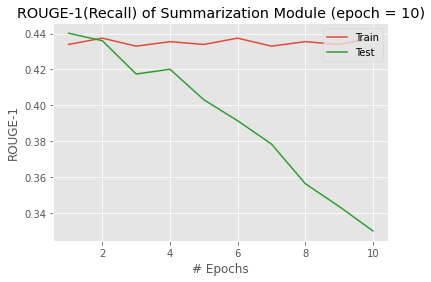

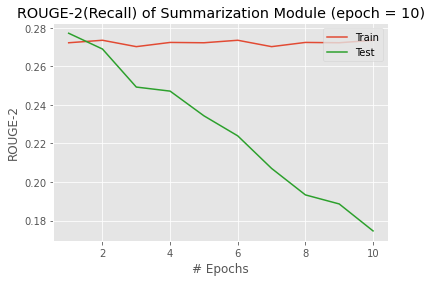

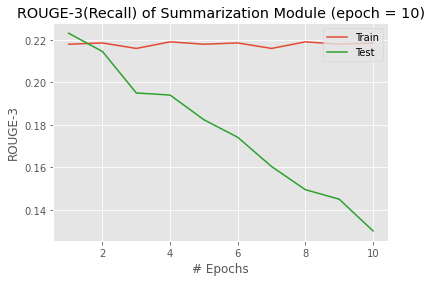

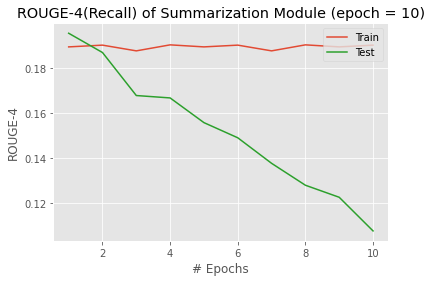

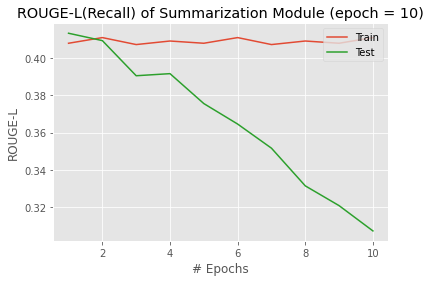

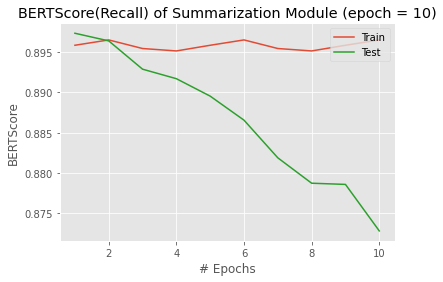

In [ ]:
# ============================== PLOT ==============================
# ROUGE-1
plot.Plot_RougeLine_diagram(train_rouge_1R, test_rouge_1R,
                "ROUGE-1", "Train", "Test",
                "ROUGE-1(Recall) of Summarization Module (epoch = ",
                ep, rouge_epoch, Result_path + "SUM_ROUGE1_Measure.png")

# ROUGE-2
plot.Plot_RougeLine_diagram(train_rouge_2R, test_rouge_2R,
                "ROUGE-2", "Train", "Test",
                "ROUGE-2(Recall) of Summarization Module (epoch = ",
                ep, rouge_epoch, Result_path + "SUM_ROUGE2_Measure.png")

# ROUGE-3
plot.Plot_RougeLine_diagram(train_rouge_3R, test_rouge_3R,
                "ROUGE-3", "Train", "Test",
                "ROUGE-3(Recall) of Summarization Module (epoch = ",
                ep, rouge_epoch, Result_path + "SUM_ROUGE3_Measure.png")

# ROUGE-4
plot.Plot_RougeLine_diagram(train_rouge_4R, test_rouge_4R,
                "ROUGE-4", "Train", "Test",
                "ROUGE-4(Recall) of Summarization Module (epoch = ",
                ep, rouge_epoch, Result_path + "SUM_ROUGE4_Measure.png")

# ROUGE-L
plot.Plot_RougeLine_diagram(train_rouge_LR, test_rouge_LR,
                "ROUGE-L", "Train", "Test",
                "ROUGE-L(Recall) of Summarization Module (epoch = ",
                ep, rouge_epoch, Result_path + "SUM_ROUGEL_Measure.png")


# BERTScore
plot.Plot_RougeLine_diagram(train_BertScore, test_BertScore,
                "BERTScore", "Train", "Test",
                "BERTScore(Recall) of Summarization Module (epoch = ",
                ep, rouge_epoch, Result_path + "SUM_BertScore_Measure.png")

**Tag Generation**

In [ ]:
train_output_Allepochs = pd.read_pickle(Result_path + "train_output_Allepochs.pkl")
num_epochs = 10

# train_rouge_1R, train_rouge_2R, train_rouge_3R, train_rouge_4R, train_rouge_LR, train_BertScore = [], [], [], [], [], []

train_rouge_1R = np.load(Result_path + "train_rouge_1R_TG.npy").tolist()
train_rouge_2R = np.load(Result_path + "train_rouge_2R_TG.npy").tolist()
train_rouge_3R = np.load(Result_path + "train_rouge_3R_TG.npy").tolist()
train_rouge_4R = np.load(Result_path + "train_rouge_4R_TG.npy").tolist()
train_rouge_LR = np.load(Result_path + "train_rouge_LR_TG.npy").tolist()
train_BertScore = np.load(Result_path + "train_BertScore_TG.npy").tolist()

In [ ]:
for i, ep in enumerate(np.arange(6, num_epochs+1, rouge_epoch)):

    print('='*65)
    print('Calculating Rouge for Epoch {:}'.format(ep))
    print('='*65)

    # Calculate ROUGE metrics
    train_rouge = ROUGE_Calculate(train_output_Allepochs[i], 'T')
    train_rouge_1R.append(train_rouge['1R'])
    train_rouge_2R.append(train_rouge['2R'])
    train_rouge_3R.append(train_rouge['3R'])
    train_rouge_4R.append(train_rouge['4R'])
    train_rouge_LR.append(train_rouge['LR'])
    train_BertScore.append(train_rouge['BS'])

    # =============== Print Summary of results ===============
    print('\n\t','='*47)
    print('\t',' '*15, "TAG GENERATION", '\t',' '*15)
    print(f'\t\t\tepoch ({(ep):.0f}) summary')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-1(Recall) TG:\t\t {train_rouge["1R"]:.3f}')
    print(f'\tTraining ROUGE-2(Recall) TG:\t\t {train_rouge["2R"]:.3f}')
    print(f'\tTraining ROUGE-3(Recall) TG:\t\t {train_rouge["3R"]:.3f}')
    print(f'\tTraining ROUGE-4(Recall) TG:\t\t {train_rouge["4R"]:.3f}')
    print(f'\tTraining ROUGE-L(Recall) TG:\t\t {train_rouge["LR"]:.3f}')
    print(f'\tTraining BERT-Score(Recall) TG:\t {train_rouge["BS"]:.3f}')
    print('\t','='*47,'\n\n')

    np.save(Result_path + "train_rouge_1R_TG.npy", train_rouge_1R)
    np.save(Result_path + "train_rouge_2R_TG.npy", train_rouge_2R)
    np.save(Result_path + "train_rouge_3R_TG.npy", train_rouge_3R)
    np.save(Result_path + "train_rouge_4R_TG.npy", train_rouge_4R)
    np.save(Result_path + "train_rouge_LR_TG.npy", train_rouge_LR)
    np.save(Result_path + "train_BertScore_TG.npy", train_BertScore)

Calculating Rouge for Epoch 6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (6) summary
	 -----------------------------------------------
	Training ROUGE-1(Recall) TG:		 0.519
	Training ROUGE-2(Recall) TG:		 0.332
	Training ROUGE-3(Recall) TG:		 0.302
	Training ROUGE-4(Recall) TG:		 0.274
	Training ROUGE-L(Recall) TG:		 0.478
	Training BERT-Score(Recall) TG:	 0.878


Calculating Rouge for Epoch 7


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (7) summary
	 -----------------------------------------------
	Training ROUGE-1(Recall) TG:		 0.579
	Training ROUGE-2(Recall) TG:		 0.407
	Training ROUGE-3(Recall) TG:		 0.377
	Training ROUGE-4(Recall) TG:		 0.346
	Training ROUGE-L(Recall) TG:		 0.543
	Training BERT-Score(Recall) TG:	 0.890


Calculating Rouge for Epoch 8


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (8) summary
	 -----------------------------------------------
	Training ROUGE-1(Recall) TG:		 0.616
	Training ROUGE-2(Recall) TG:		 0.452
	Training ROUGE-3(Recall) TG:		 0.423
	Training ROUGE-4(Recall) TG:		 0.390
	Training ROUGE-L(Recall) TG:		 0.582
	Training BERT-Score(Recall) TG:	 0.895


Calculating Rouge for Epoch 9


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (9) summary
	 -----------------------------------------------
	Training ROUGE-1(Recall) TG:		 0.642
	Training ROUGE-2(Recall) TG:		 0.488
	Training ROUGE-3(Recall) TG:		 0.460
	Training ROUGE-4(Recall) TG:		 0.424
	Training ROUGE-L(Recall) TG:		 0.611
	Training BERT-Score(Recall) TG:	 0.901


Calculating Rouge for Epoch 10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (10) summary
	 -----------------------------------------------
	Training ROUGE-1(Recall) TG:		 0.655
	Training ROUGE-2(Recall) TG:		 0.508
	Training ROUGE-3(Recall) TG:		 0.480
	Training ROUGE-4(Recall) TG:		 0.443
	Training ROUGE-L(Recall) TG:		 0.625
	Training BERT-Score(Recall) TG:	 0.900




In [ ]:
test_output_Allepochs = pd.read_pickle(Result_path + "test_output_Allepochs.pkl")
test_rouge_1R, test_rouge_2R, test_rouge_3R, test_rouge_4R, test_rouge_LR, test_BertScore = [], [], [], [], [], []
num_epochs = 10

test_rouge_1R = np.load(Result_path + "test_rouge_1R_TG.npy").tolist()
test_rouge_2R = np.load(Result_path + "test_rouge_2R_TG.npy").tolist()
test_rouge_3R = np.load(Result_path + "test_rouge_3R_TG.npy").tolist()
test_rouge_4R = np.load(Result_path + "test_rouge_4R_TG.npy").tolist()
test_rouge_LR = np.load(Result_path + "test_rouge_LR_TG.npy").tolist()
test_BertScore = np.load(Result_path + "test_BertScore_TG.npy").tolist()

In [ ]:
# -------------------------- SUMMARIZATION --------------------------
for i, ep in enumerate(np.arange(6, num_epochs+1, rouge_epoch)):

    print('='*65)
    print('Calculating Rouge for Epoch {:}'.format(ep))
    print('='*65)

    test_rouge = ROUGE_Calculate(test_output_Allepochs[i], 'T')
    test_rouge_1R.append(test_rouge['1R'])
    test_rouge_2R.append(test_rouge['2R'])
    test_rouge_3R.append(test_rouge['3R'])
    test_rouge_4R.append(test_rouge['4R'])
    test_rouge_LR.append(test_rouge['LR'])
    test_BertScore.append(test_rouge['BS'])

    # =============== Print Summary of results ===============
    print('\n\t','='*47)
    print('\t',' '*15, "TAG GENERATION", '\t',' '*15)
    print(f'\t\t\tepoch ({(ep):.0f}) summary')

    print('\t','-'*47)
    print(f'\tTesting ROUGE-1(Recall) TG:\t\t {test_rouge["1R"]:.3f}')
    print(f'\tTesting ROUGE-2(Recall) TG:\t\t {test_rouge["2R"]:.3f}')
    print(f'\tTesting ROUGE-3(Recall) TG:\t\t {test_rouge["3R"]:.3f}')
    print(f'\tTesting ROUGE-4(Recall) TG:\t\t {test_rouge["4R"]:.3f}')
    print(f'\tTesting ROUGE-L(Recall) TG:\t\t {test_rouge["LR"]:.3f}')
    print(f'\tTesting BERT-Score(Recall) TG:\t\t {test_rouge["BS"]:.3f}')
    print('\t','='*47,'\n\n')

    np.save(Result_path + "test_rouge_1R_TG.npy", test_rouge_1R)
    np.save(Result_path + "test_rouge_2R_TG.npy", test_rouge_2R)
    np.save(Result_path + "test_rouge_3R_TG.npy", test_rouge_3R)
    np.save(Result_path + "test_rouge_4R_TG.npy", test_rouge_4R)
    np.save(Result_path + "test_rouge_LR_TG.npy", test_rouge_LR)
    np.save(Result_path + "test_BertScore_TG.npy", test_BertScore)

Calculating Rouge for Epoch 6


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (6) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) TG:		 0.547
	Testing ROUGE-2(Recall) TG:		 0.367
	Testing ROUGE-3(Recall) TG:		 0.338
	Testing ROUGE-4(Recall) TG:		 0.310
	Testing ROUGE-L(Recall) TG:		 0.508
	Testing BERT-Score(Recall) TG:		 0.886


Calculating Rouge for Epoch 7


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (7) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) TG:		 0.569
	Testing ROUGE-2(Recall) TG:		 0.397
	Testing ROUGE-3(Recall) TG:		 0.368
	Testing ROUGE-4(Recall) TG:		 0.337
	Testing ROUGE-L(Recall) TG:		 0.533
	Testing BERT-Score(Recall) TG:		 0.891


Calculating Rouge for Epoch 8


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (8) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) TG:		 0.571
	Testing ROUGE-2(Recall) TG:		 0.395
	Testing ROUGE-3(Recall) TG:		 0.366
	Testing ROUGE-4(Recall) TG:		 0.334
	Testing ROUGE-L(Recall) TG:		 0.533
	Testing BERT-Score(Recall) TG:		 0.889


Calculating Rouge for Epoch 9


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (9) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) TG:		 0.585
	Testing ROUGE-2(Recall) TG:		 0.413
	Testing ROUGE-3(Recall) TG:		 0.382
	Testing ROUGE-4(Recall) TG:		 0.354
	Testing ROUGE-L(Recall) TG:		 0.548
	Testing BERT-Score(Recall) TG:		 0.891


Calculating Rouge for Epoch 10


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



	                 TAG GENERATION 	                
			epoch (10) summary
	 -----------------------------------------------
	Testing ROUGE-1(Recall) TG:		 0.594
	Testing ROUGE-2(Recall) TG:		 0.428
	Testing ROUGE-3(Recall) TG:		 0.400
	Testing ROUGE-4(Recall) TG:		 0.371
	Testing ROUGE-L(Recall) TG:		 0.560
	Testing BERT-Score(Recall) TG:		 0.889




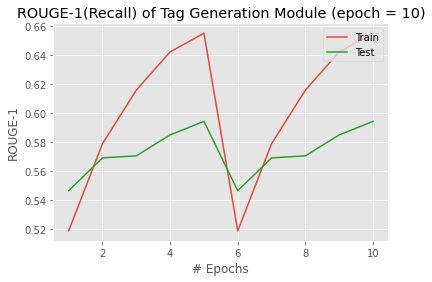

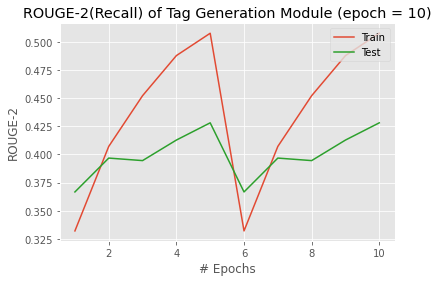

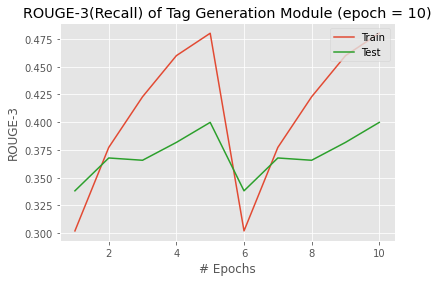

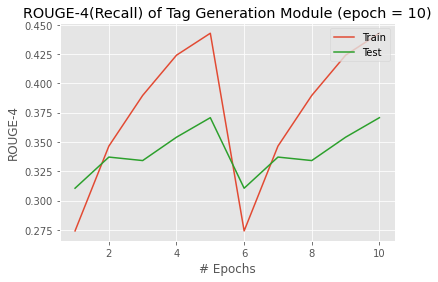

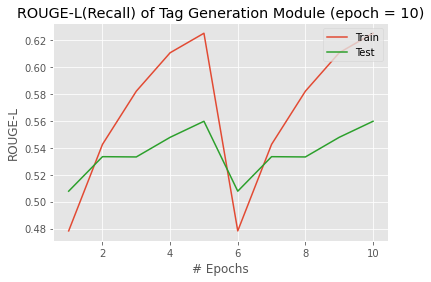

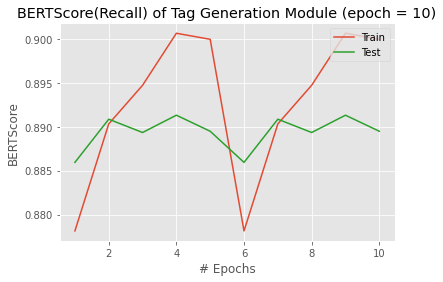

In [ ]:
# ============================== PLOT ==============================
# ROUGE-1
plot.Plot_RougeLine_diagram(train_rouge_1R, test_rouge_1R,
                "ROUGE-1", "Train", "Test",
                "ROUGE-1(Recall) of Tag Generation Module (epoch = ",
                ep, rouge_epoch, Result_path + "TG_ROUGE1_Measure.png")

# ROUGE-2
plot.Plot_RougeLine_diagram(train_rouge_2R, test_rouge_2R,
                "ROUGE-2", "Train", "Test",
                "ROUGE-2(Recall) of Tag Generation Module (epoch = ",
                ep, rouge_epoch, Result_path + "TG_ROUGE2_Measure.png")

# ROUGE-3
plot.Plot_RougeLine_diagram(train_rouge_3R, test_rouge_3R,
                "ROUGE-3", "Train", "Test",
                "ROUGE-3(Recall) of Tag Generation Module (epoch = ",
                ep, rouge_epoch, Result_path + "TG_ROUGE3_Measure.png")

# ROUGE-4
plot.Plot_RougeLine_diagram(train_rouge_4R, test_rouge_4R,
                "ROUGE-4", "Train", "Test",
                "ROUGE-4(Recall) of Tag Generation Module (epoch = ",
                ep, rouge_epoch, Result_path + "TG_ROUGE4_Measure.png")

# ROUGE-L
plot.Plot_RougeLine_diagram(train_rouge_LR, test_rouge_LR,
                "ROUGE-L", "Train", "Test",
                "ROUGE-L(Recall) of Tag Generation Module (epoch = ",
                ep, rouge_epoch, Result_path + "TG_ROUGEL_Measure.png")

# BERTScore
plot.Plot_RougeLine_diagram(train_BertScore, test_BertScore,
                "BERTScore", "Train", "Test",
                "BERTScore(Recall) of Tag Generation Module (epoch = ",
                ep, rouge_epoch, Result_path + "TG_BertScore_Measure.png")

# ⭕ **Evaluating other datasets**

## **Prepare your new dataset for further usage:**

In [ ]:
# 1. The address of test and train data in your --google drive--
TrRQE_Path = '/content/drive/My Drive/PHD_Thesis/Data/RQE_TrainSet.xml'                   # Training RQE Data
VlRQE_Path = '/content/drive/My Drive/PHD_Thesis/Data/RQE_ValidationSet.xml'              # Validation RQE Data
TeRQE_Path = '/content/drive/My Drive/PHD_Thesis/Data/RQE_TestSet.xml'                    # Test RQE Data



# 2. read data (Note, if file format is XLSX, use 'read_excel',
#               and if the format is CSV, use 'read_csv' function)
## --------- If file format is XML ---------
TeRQE_DF = pd.read_xml(TeRQE_Path)
TrRQE_DF = pd.read_xml(TrRQE_Path)
VlRQE_DF = pd.read_xml(VlRQE_Path)

## --------- If file format is XLSX ---------
# TeRQE_DF = pd.read_excel(TeRQE_Path)

## --------- If file format is CSV ---------
# TeRQE_DF = pd.read_csv(TeRQE_Path, delimiter='<eos>\n<s>', header=None, names = ['long_text'], index_col=None)
# TeRQE_DF = pd.read_csv(TeRQE_Path, delimiter='<eos>\n<s>', header=None, names = ['short_text'], index_col=None)



# 3. If the dataset has labels other than 1 and 0, refine them
TeRQE_DF = TeRQE_DF.replace(True, 1)                                                      # replace 'True' labels with '1'
TeRQE_DF = TeRQE_DF.replace(False, 0)                                                     # replace 'False' labels with '1'

TrRQE_DF = TrRQE_DF.replace(True, 1)
TrRQE_DF = TrRQE_DF.replace(False, 0)

VlRQE_DF = VlRQE_DF.replace(True, 1)
VlRQE_DF = VlRQE_DF.replace(False, 0)



# 4. Adjust dataframe columns
## --------- Test ---------
TeRQE_DF.columns = ['ids', 'is_duplicate','long_text', 'short_text']                      # If data has [id, label, Sentence1, Sentance2]
TeRQE_DF['short_text_tags'] = ""                                                          # Empty columns
TeRQE_DF['long_text_tags'] = ""
TeRQE_DF['long_text_title'] = ""
TeRQE_DF['forum'] = ""
TeRQE_DF = TeRQE_DF.drop(['ids'], axis=1)                                                 # Remove the 'id' column

## --------- Train ---------
TrRQE_DF.columns = ['ids', 'type', 'is_duplicate','long_text', 'short_text']
TrRQE_DF['short_text_tags'] = ""
TrRQE_DF['long_text_tags'] = ""
TrRQE_DF['long_text_title'] = ""
TrRQE_DF['forum'] = ""
TrRQE_DF = TrRQE_DF.drop(['ids', 'type'], axis=1)

## --------- Validation ---------
VlRQE_DF.columns = ['ids', 'is_duplicate','long_text', 'short_text']
VlRQE_DF['short_text_tags'] = ""
VlRQE_DF['long_text_tags'] = ""
VlRQE_DF['long_text_title'] = ""
VlRQE_DF['forum'] = ""
VlRQE_DF = VlRQE_DF.drop(['ids'], axis=1)



# 5. Data should be a list of lists
TeRQE_DF = TeRQE_DF[['long_text',	'short_text',	'short_text_tags',	'long_text_tags',	'long_text_title',	'is_duplicate', 'forum']]
TrRQE_DF = TrRQE_DF[['long_text',	'short_text',	'short_text_tags',	'long_text_tags',	'long_text_title',	'is_duplicate', 'forum']]
VlRQE_DF = VlRQE_DF[['long_text',	'short_text',	'short_text_tags',	'long_text_tags',	'long_text_title',	'is_duplicate', 'forum']]



# 6. Data preprocess (remove punctuations from long and short texts, and then remove empty sequences)
## --------- Test ---------
Remove_list = []
for index,row in TeRQE_DF.iterrows():
  filtered_sentence, dropORnot = PreprocessText(row['long_text'])
  TeRQE_DF.at[index, 'long_text'] = filtered_sentence

  filtered_sentence, dropORnot = PreprocessText(row['short_text'])
  if (dropORnot):
    print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
    Remove_list.append(index)
  else:
    TeRQE_DF.at[index, 'short_text'] = filtered_sentence

for ind in set(Remove_list):
  print(str(ind) + " is removed from dataframe.")
  TeRQE_DF = TeRQE_DF.drop(index = ind)

## --------- Train ---------
Remove_list = []
index = 0
for index,row in TrRQE_DF.iterrows():
  filtered_sentence, dropORnot = PreprocessText(row['long_text'])
  TrRQE_DF.at[index, 'long_text'] = filtered_sentence

  if pd.isna(row['short_text']):
    Remove_list.append(index)
  else:
    filtered_sentence, dropORnot = PreprocessText(row['short_text'])
    if (dropORnot):
      print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
      Remove_list.append(index)
    else:
      TrRQE_DF.at[index, 'short_text'] = filtered_sentence

for ind in set(Remove_list):
  print(str(ind) + " is removed from dataframe.")
  TrRQE_DF = TrRQE_DF.drop(index = ind)

## --------- Validation ---------
Remove_list = []
for index,row in VlRQE_DF.iterrows():
  filtered_sentence, dropORnot = PreprocessText(row['long_text'])
  VlRQE_DF.at[index, 'long_text'] = filtered_sentence

  filtered_sentence, dropORnot = PreprocessText(row['short_text'])
  if (dropORnot):
    print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
    Remove_list.append(index)
  else:
    VlRQE_DF.at[index, 'short_text'] = filtered_sentence

for ind in set(Remove_list):
  print(str(ind) + " is removed from dataframe.")
  VlRQE_DF = VlRQE_DF.drop(index = ind)



# 7. Save your new dataset using pickle
pd.to_pickle(TeRQE_DF, "/content/drive/MyDrive/Sum-RQE/dataframes/TeRQE_DF.pkl")
pd.to_pickle(TrRQE_DF, "/content/drive/MyDrive/Sum-RQE/dataframes/TrRQE_DF.pkl")
pd.to_pickle(VlRQE_DF, "/content/drive/MyDrive/Sum-RQE/dataframes/VlRQE_DF.pkl")


## **Load your new dataset, then split it into train and test parts:**

In [ ]:
# ================================ MediQA-RQE ================================
Otherdataset1 = pd.read_pickle("/content/drive/MyDrive/Sum-RQE/dataframes/TeRQE_DF.pkl")          # Test
Otherdataset2 = pd.read_pickle("/content/drive/MyDrive/Sum-RQE/dataframes/TrRQE_DF.pkl")          # Train
train, test1 = Data_Preparation.prepare_data(Otherdataset2, BARTtokenizer_Obj, 1)
TR_DL = Data_Preparation.train_dataloader(train, batch_size)
train1, test = Data_Preparation.prepare_data(Otherdataset1, BARTtokenizer_Obj, 0)
TE_DL = Data_Preparation.test_dataloader(test, batch_size)
print("Number of Train samples: ", len(train))
print("Number of Test samples: ", len(test))
display(Otherdataset1)


# ================================ MeQSum ================================
# Otherdataset = pd.read_pickle("/content/drive/MyDrive/Sum-RQE/dataframes/SUM_DF.pkl")
# for index, row in Otherdataset.iterrows():
#   Otherdataset.at[index, 'is_duplicate'] = 1
# train, test = Data_Preparation.prepare_data(Otherdataset, BARTtokenizer_Obj, 0.5)
# TR_DL = Data_Preparation.train_dataloader(train, batch_size)
# TE_DL = Data_Preparation.test_dataloader(test, batch_size)
# print("Number of Train samples: ", len(train))
# print("Number of Test samples: ", len(test))
# display(Otherdataset1)


# ================================ Debatepedia ================================
# Otherdataset1 = pd.read_pickle("/content/drive/MyDrive/Sum-RQE/dataframes/DebatePedia_QFAS.pkl")          # Test
# Otherdataset2 = pd.read_pickle("/content/drive/MyDrive/Sum-RQE/dataframes/DebatePedia_QFAS_train.pkl")    # Train
# for index, row in Otherdataset1.iterrows():
#   Otherdataset1.at[index, 'is_duplicate'] = 1
# for index, row in Otherdataset2.iterrows():
#   Otherdataset2.at[index, 'is_duplicate'] = 1
# train, test1 = Data_Preparation.prepare_data(Otherdataset2, BARTtokenizer_Obj, 1)
# TR_DL = Data_Preparation.train_dataloader(train, batch_size)
# train1, test = Data_Preparation.prepare_data(Otherdataset1, BARTtokenizer_Obj, 0)
# TE_DL = Data_Preparation.test_dataloader(test, batch_size)
# print("Number of Train samples: ", len(train))
# print("Number of Test samples: ", len(test))
# display(Otherdataset1)

## 🍀 **If you want to** fine-tune **our pre-trained ReQuEST using a new dataset, run the section below:**

If you don't want to use our pre-trained model, just set the ContinueOrNot to 0.

In [ ]:
# ======================================================================================
#                           Parameter initialization
# ======================================================================================
last_ep = -1
train_avg_loss_RQE_Allepochs , test_avg_loss_RQE_Allepochs= [], []
train_avg_loss_SUM_Allepochs , test_avg_loss_SUM_Allepochs = [], []
train_avg_loss_TG_Allepochs, test_avg_loss_TG_Allepochs = [], []
train_accuracy_Allepochs, test_accuracy_Allepochs = [], []
train_f1_Allepochs, test_f1_Allepochs = [], []
train_output_Allepochs, test_output_Allepochs = [], []


# ======================================================================================
#                             Freeze OR Not BART Layers
# ======================================================================================
Model.Freeze_Parameters(finetuneOrnot_decoder, finetuneOrnot_encoder)


# ======================================================================================
#               Train & Test Model and Calculate all metrics except rouge
# ======================================================================================
for ep in range((last_ep + 1), num_epochs):

  print('=================================================================')
  print('Epoch {:} / {:}'.format(ep + 1, num_epochs))
  print('=================================================================')

  Train_start_time = time.time()
  train_avg_loss_RQE, train_avg_loss_SUM, train_avg_loss_TG, train_avg_loss_Total, train_accuracy, train_f1, train_output = Train_SUM_RQE(TR_DL, ep, BARTtokenizer_Obj, num_epochs, Coefficient)
  Train_end_time = time.time()
  test_avg_loss_RQE, test_avg_loss_SUM, test_avg_loss_TG, test_avg_loss_Total, test_accuracy, test_f1, test_output = Test_SUM_RQE(TE_DL, ep, BARTtokenizer_Obj, num_epochs, Coefficient)


  # ===================== Train =======================
  train_avg_loss_RQE_Allepochs.append(train_avg_loss_RQE)
  train_avg_loss_SUM_Allepochs.append(train_avg_loss_SUM)
  train_avg_loss_TG_Allepochs.append(train_avg_loss_TG)
  train_accuracy_Allepochs.append(train_accuracy)
  train_output_Allepochs.append(train_output)
  train_f1_Allepochs.append(train_f1)
  if ((ep+1) % rouge_epoch == 0):
    train_rougeS = ROUGE_Calculate(train_output, 'S')
    train_rougeT = ROUGE_Calculate(train_output, 'T')

  # ====================== Test ========================
  test_avg_loss_RQE_Allepochs.append(test_avg_loss_RQE)
  test_avg_loss_SUM_Allepochs.append(test_avg_loss_SUM)
  test_avg_loss_TG_Allepochs.append(test_avg_loss_TG)
  test_accuracy_Allepochs.append(test_accuracy)
  test_f1_Allepochs.append(test_f1)
  test_output_Allepochs.append(test_output)
  if ((ep+1) % rouge_epoch == 0):
    test_rougeS = ROUGE_Calculate(test_output, 'S')
    test_rougeT = ROUGE_Calculate(test_output, 'T')

  # =============== Plot Loss vs. epochs ===============
  # RQE
  plot.Plot_line_diagram(train_avg_loss_RQE_Allepochs,
                         test_avg_loss_RQE_Allepochs,
                         "Loss", "Train Loss", "Test Loss",
                         "Average loss of Cross-enropy for RQE Module (epoch = ",
                         ep, Result_path + "RQE_cross_entropy_loss.png")

  # SUM
  plot.Plot_line_diagram(train_avg_loss_SUM_Allepochs,
                         test_avg_loss_SUM_Allepochs,
                         "Loss", "Train Loss", "Test Loss",
                         "Average loss of Cross-enropy for Summarization Module (epoch = ",
                         ep, Result_path + "SUM_cross_entropy_loss.png")

  # TG
  plot.Plot_line_diagram(train_avg_loss_TG_Allepochs,
                         test_avg_loss_TG_Allepochs,
                         "Loss", "Train Loss", "Test Loss",
                         "Average loss of Cross-enropy for Tag Generation Module (epoch = ",
                         ep, Result_path + "TG_cross_entropy_loss.png")

  # Accuracy
  plot.Plot_line_diagram(train_accuracy_Allepochs,
                         test_accuracy_Allepochs,
                         "Accuracy", "Train Accuracy", "Test Accuracy",
                         "Accuracy of RQE Module (epoch = ",
                         ep, Result_path + "RQE_Accuracy.png")

  # RQE
  plot.Plot_line_diagram(train_f1_Allepochs,
                         test_f1_Allepochs,
                         "F1-measure", "Train F1", "Test F1",
                         "F1-measure of RQE Module (epoch = ",
                         ep, Result_path + "RQE_F1_Measure.png")



  # =============== Print Summary of results ===============
  print('\n\t','='*47)
  print(f'\t\t\tepoch ({(ep+1):.0f}) summary')

  print('\t','='*47)
  print(f'\tTraining Loss RQE:\t\t\t {train_avg_loss_RQE:.3f}')
  print(f'\tTesting Loss RQE:\t\t\t {test_avg_loss_RQE:.3f}')

  print('\t','-'*47)
  print(f'\tTraining Loss SUM:\t\t\t {train_avg_loss_SUM:.3f}')
  print(f'\tTesting Loss SUM:\t\t\t {test_avg_loss_SUM:.3f}')

  print('\t','-'*47)
  print(f'\tTraining Loss TG:\t\t\t {train_avg_loss_TG:.3f}')
  print(f'\tTesting Loss TG:\t\t\t {test_avg_loss_TG:.3f}')

  print('\t','-'*47)
  print(f'\tTraining Accuracy RQE:\t\t\t {train_accuracy:.3f}')
  print(f'\tTesting Accuracy RQE:\t\t\t {test_accuracy:.3f}')

  print('\t','-'*47)
  print(f'\tTraining F1-measure RQE:\t\t {train_f1:.3f}')
  print(f'\tTesting F1-measure RQE:\t\t\t {test_f1:.3f}')

  Train_Duration = Train_end_time-Train_start_time
  print('\tTraining Time:\t\t\t ', str(timedelta(seconds=Train_Duration)))
  print('\t','='*47,'\n\n')

  # =============== Print Summary of results ===============
  if ((ep+1) % rouge_epoch == 0):
    print('\n\t','='*47)
    print('\t',' '*15, "SUMMARIZATION", '\t',' '*15)
    print(f'\t\t\t summary')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-1(Recall) SUM:\t\t {train_rougeS["1R"]:.3f}')
    print(f'\tTesting ROUGE-1(Recall) SUM:\t\t {test_rougeS["1R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-2(Recall) SUM:\t\t {train_rougeS["2R"]:.3f}')
    print(f'\tTesting ROUGE-2(Recall) SUM:\t\t {test_rougeS["2R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-3(Recall) SUM:\t\t {train_rougeS["3R"]:.3f}')
    print(f'\tTesting ROUGE-3(Recall) SUM:\t\t {test_rougeS["3R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-4(Recall) SUM:\t\t {train_rougeS["4R"]:.3f}')
    print(f'\tTesting ROUGE-4(Recall) SUM:\t\t {test_rougeS["4R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-L(Recall) SUM:\t\t {train_rougeS["LR"]:.3f}')
    print(f'\tTesting ROUGE-L(Recall) SUM:\t\t {test_rougeS["LR"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining BERT-Score(Recall) SUM:\t {train_rougeS["BS"]:.3f}')
    print(f'\tTesting BERT-Score(Recall) SUM:\t\t {test_rougeS["BS"]:.3f}')
    print('\t','='*47,'\n\n')

    # =============== Print Summary of results ===============
    print('\n\t','='*47)
    print('\t',' '*15, "TAG GENERATION", '\t',' '*15)
    print(f'\t\t\t summary')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-1(Recall) TG:\t\t {train_rougeT["1R"]:.3f}')
    print(f'\tTesting ROUGE-1(Recall) TG:\t\t {test_rougeT["1R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-2(Recall) TG:\t\t {train_rougeT["2R"]:.3f}')
    print(f'\tTesting ROUGE-2(Recall) TG:\t\t {test_rougeT["2R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-3(Recall) TG:\t\t {train_rougeT["3R"]:.3f}')
    print(f'\tTesting ROUGE-3(Recall) TG:\t\t {test_rougeT["3R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-4(Recall) TG:\t\t {train_rougeT["4R"]:.3f}')
    print(f'\tTesting ROUGE-4(Recall) TG:\t\t {test_rougeT["4R"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining ROUGE-L(Recall) TG:\t\t {train_rougeT["LR"]:.3f}')
    print(f'\tTesting ROUGE-L(Recall) TG:\t\t {test_rougeT["LR"]:.3f}')

    print('\t','-'*47)
    print(f'\tTraining BERT-Score(Recall) TG:\t {train_rougeT["BS"]:.3f}')
    print(f'\tTesting BERT-Score(Recall) TG:\t\t {test_rougeT["BS"]:.3f}')
    print('\t','='*47,'\n\n')



Epoch 1 / 5


NameError: ignored

# **❗ create synthetic dataset for multi-document summarization**

In [ ]:
import gc
#choose 100 samples of dataset for train
#choose 20 samples of dataset for test

from sklearn.model_selection import train_test_split


file = "/content/drive/MyDrive/PLANSUM_test/Data/train.json"
f = open(file, 'r', encoding='utf-8', errors='ignore')
data = json.load(f)
data200 = data[0:200]
train80, test20 = train_test_split(data200, test_size=0.2)
del data,data200
gc.collect()

# with open("train100.json", "w") as outfile:
#     json.dump(train80, outfile)
with open("train80.json", "w") as outfile:
    json.dump(train80, outfile)
del train80
del test20
gc.collect()
torch.cuda.empty_cache()

In [ ]:

args = {
  "mode": "create",
  "data_type": "yelp",
  "aspect_dim": 100,
  "sentiment_dim": 5,
  "adjust_sentiment": 1,
  "input_dim": 256,
  "hidden_dim": 256,
  "batch_size": 16,
  "num_epoch": 30,
  "learning_rate": 3e-5,
  "warmup": 8000,
  "evaluate_every": 20000,
  "training_stopper": 50,
  "train_file": "/content/drive/MyDrive/plansum/tttrain.json",
  "dev_file": "/content/drive/MyDrive/plansum/train.json",                  #have not downloaded dev file!!!!!!!!!!!!
  "bert_config": "bert-base-uncased",
  # used when creating synthetic dataset
  "alpha": 10.0,
  "min_length": 50,
  "max_length": 500,
  "max_symbols": 500,
  "max_tridots": 500,
  "min_reviews": 8,
  "max_reviews": 8,
  "mean_reviews": 8,
  "std_reviews": 8,
}
from tqdm import tqdm
from transformers import BertTokenizer
BARTtokenizer_Obj = BartTokenizerFast.from_pretrained("facebook/bart-base",
                                                      lowercase=True)
tokenizer = BertTokenizer.from_pretrained(args['bert_config'])

def condense_data(file, adjust_sentiment=0):
  """
    Preprocess dataset for RQE model.
  """
  f = open(file, 'r', encoding='utf-8', errors='ignore')
  data = json.load(f)
  f.close()

  x_data = []
  y_data = [] # sentiment labels

  for instance in tqdm(data):
    for review in instance['reviews']:
      review, sentiment = review
      if sentiment == -1:
        continue
      sentiment -= adjust_sentiment

      review = review.replace('MOV', '<movie>').strip()

      x_data.append(review)
      y_data.append(sentiment)

  return x_data, y_data
def abstract_data(file, multi_ref=False):
  """
    Preprocess dataset for Abstract model.
  """
  f = open(file, 'r', encoding='utf-8', errors='ignore')
  data = json.load(f)
  f.close()

  x_data = []
  y_data = []

  for instance in tqdm(data):
    if not multi_ref:
      if 'summary' in instance:
        summary = instance['summary'].replace('MOV', '<movie>').strip()
        y_data.append(summary)
    else:
      if 'summary' in instance:
        summary = instance['summary'][0].strip()
        y_data.append(summary)

    reviews = []
    for review in instance['reviews']:
      review = review[0].replace('MOV', '<movie>').strip()
      reviews.append(review)

    x_data.append(reviews)

  return x_data, y_data
def check_summary_worthy(x, tokenizer,
                         min_length=50,
                         max_length=90,
                         max_symbols=0,
                         max_tridots=0):
  """
    Check whether the review x is summary-worthy or not.
  """
  x = tokenizer.decode(x)
  x = x.replace('<movie>', 'movie')
  tokens = x.split()[1:-1]

  length = 0
  num_symbols = 0
  num_tridots = 0

  for token in tokens:
    if token in ['[CLS]', '[SEP]']:
      continue
    length += 1
    if token == '...':
      num_tridots += 1
    symbol = re.sub("[A-Za-z0-9]", '', token)
    if len(symbol) > 0 and symbol not in ",!.'":
      num_symbols += 1

  return length >= min_length and length <= max_length and num_symbols <= max_symbols and num_tridots <= max_tridots
def pad_text(batch, pad_id=0):
  max_length = max(len(inst) for inst in batch)

  inst_batch = []
  mask_batch = []
  for inst in batch:
    if isinstance(inst, torch.Tensor):
      inst = inst.tolist()
    inst = list(inst)
    mask = [1.0] * len(inst) + [0.0] * (max_length - len(inst))
    inst = inst + [pad_id] * (max_length - len(inst))
    mask_batch.append(mask)
    inst_batch.append(inst)

  inst_batch = torch.Tensor(inst_batch).long().cuda()
  mask_batch = torch.Tensor(mask_batch).float().cuda()

  return inst_batch, mask_batch


yelp_location = "/content/drive/MyDrive/PLANSUM_test/preprocess/train80.json" # bayad train100 ro bardarammmmmmmmmmmmmm
x_train, _ = abstract_data(yelp_location, tokenizer)

In [ ]:
from itertools import chain
BARTtokenizer_Obj = BartTokenizerFast.from_pretrained("facebook/bart-base",
                                                      lowercase=True)

# from sklearn.model_selection import train_test_sp

args = {
  "mode": "create",
  "data_type": "yelp",
  "aspect_dim": 100,
  "sentiment_dim": 5,
  "adjust_sentiment": 1,
  "input_dim": 256,
  "hidden_dim": 256,
  "batch_size": 16,
  "num_epoch": 30,
  "learning_rate": 3e-5,
  "warmup": 8000,
  "evaluate_every": 20000,
  "training_stopper": 50,
  "train_file": "/content/drive/MyDrive/plansum/tttrain.json",
  "dev_file": "/content/drive/MyDrive/plansum/train.json",                  #have not downloaded dev file!!!!!!!!!!!!
  "bert_config": "bert-base-uncased",
  # used when creating synthetic dataset
  "alpha": 10.0,
  "min_length": 50,
  "max_length": 500,
  "max_symbols": 500,
  "max_tridots": 500,
  "min_reviews": 8,
  "max_reviews": 8,
  "mean_reviews": 8,
  "std_reviews": 8,
}

tokenizer = BertTokenizer.from_pretrained(args['bert_config'])
def create_500_raw_data(tokenizer, x_train):
  data = []
  print('Creating synthetic dataset...')
  for i in tqdm(range(len(x_train))):
    x_batches = x_train[i]
    for x_idx in range(0, len(x_batches), 100):
      x_batch = x_batches[x_idx:x_idx+100]
      if len(x_batch) < 99:
        continue
      for z_idx in range(len(x_batch)):
        z_sample = x_batch[z_idx]
        z_sample_encoded = [tokenizer.encode(z_sample)]
        if not check_summary_worthy(list(chain.from_iterable(z_sample_encoded)), tokenizer, args['min_length'], args['max_length'], args['max_symbols'], args['max_tridots']):
                  continue
        for j_idx in range(len(x_batch)):
          j_sample = x_batch[j_idx]
          if j_idx != z_idx:
            data.append([z_idx, j_sample, z_sample, "", "", "", 0, ""])
  df = pd.DataFrame(data, columns = ['short_text_ids','long_text',	'short_text',	'short_text_tags',	'long_text_tags',	'long_text_title',	'is_duplicate', 'forum'])
  return df
df_500= create_500_raw_data(tokenizer, x_train)

In [ ]:
print(len(df_500))

## create dataset using RQE

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')

def PreprocessText (txt, txttype='S'):
  dropORnot = False
  # tokenizer = nltk.RegexpTokenizer(r"\w+")
  # new_txt = tokenizer.tokenize(txt)
  if (txttype == 'T'):
    txt = " ".join(txt)
  txt = txt.replace('-', ' ')
  new_txt = txt.translate(str.maketrans('', '', string.punctuation))
  new_txt = nltk.word_tokenize(new_txt)
  # new_txt= [word for word in words if word.isalnum()]
  if len(new_txt)<1:
    dropORnot = True
  filtered_sentence = ' '.join(new_txt)

  # stop_words = set(stopwords.words('english'))
  # word_tokens = word_tokenize(filtered_sentence)
  # filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]       # Remove stop
  # filtered_sentence = ' '.join(filtered_sentence)
  return filtered_sentence, dropORnot

Remove_list = []
for index,row in df_500.iterrows():
  filtered_sentence, dropORnot = PreprocessText(row['long_text'])
  df_500.at[index, 'long_text'] = filtered_sentence

  filtered_sentence, dropORnot = PreprocessText(row['short_text'])
  if (dropORnot):
    print(str(index) + " with label =" + str(row['is_duplicate']) + " should be removed from dataframe.")
    Remove_list.append(index)
  else:
    df_500.at[index, 'short_text'] = filtered_sentence

for ind in set(Remove_list):
  print(str(ind) + " is removed from dataframe.")
  df_500 = df_500.drop(index = ind)

In [ ]:
print(len(df_500))

In [ ]:
df_500 = df_500.drop(['short_text_ids'], axis=1)
train = Data_Preparation.prepare_data(df_500, BARTtokenizer_Obj, 0)
TE_DL = Data_Preparation.test_dataloader(train, batch_size)
# del train
gc.collect()
torch.cuda.empty_cache()
pd.to_pickle(TE_DL, "/content/drive/MyDrive/PLANSUM_test/preprocess/Test_TE_DL_80.pkl")

In [ ]:
# TE_DL = pd.read_pickle(r"/content/drive/MyDrive/PLANSUM_test/Amazon/TE_DL_80.pkl")
test_output = Test_SUM_RQE(TE_DL, 0, BARTtokenizer_Obj, num_epochs, Coefficient)

df_logits = pd.DataFrame(test_output)
df_logits.to_csv( "/content/drive/MyDrive/PLANSUM_test/preprocess/Test_logits_RQE.csv", index=False, encoding='utf-8-sig')
# result = df_logits.sort_values(['batch_PLogits'],ascending=True).groupby('question_2').head(8)
# result = df_logits.groupby('question_2').head(8)
# result.to_csv('8_best_out_RQE.csv')

## create dataset using RQE 8-best

In [ ]:
logits_RQE = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/preprocess/logits_RQE.csv")
logits_RQE = logits_RQE.drop(columns=['question_1', 'question_2'])
distances_plansum = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/preprocess/distances_plansum.csv")
logits_distances = pd.concat([logits_RQE, distances_plansum], axis = 1)
RQE_8_best = logits_distances.groupby(["question_2"]).apply(lambda x: x.sort_values(["batch_PLogits"], ascending = False)).reset_index(drop=True)
RQE_8_best_result = RQE_8_best.groupby('question_2').head(8)

# logits_RQE = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE.csv")
# logits_RQE = logits_RQE.groupby(["question_2"]).apply(lambda x: x.sort_values(["batch_PLogits"], ascending = False)).reset_index(drop=True)
# result2 = logits_RQE.groupby('question_2').head(8)


RQE_8_best_result.to_csv( "/content/drive/MyDrive/PLANSUM_test/preprocess/8_best_out_RQE2.csv", index=False, encoding='utf-8-sig')

## create TEST dataset using (RQE 4-best) and (plansum-dirichle 4-best)

In [ ]:
RQE_4_best = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Amazon/Test_4_best_out_RQE2.csv")
RQE_4_best = RQE_8_best.drop(columns=['distance','batch_PLogits'])
# print(RQE_8_best)
# print(RQE_8_best['question_1'].nunique())
plansum_dirichle_4_best = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Amazon/Test_4_best_out_plansum_dirichle.csv")
plansum_dirichle_4_best = plansum_dirichle_4_best.drop(columns=['distance'])
plansum_dirichle_4_best.columns = ['question_2', 'question_1']
plansum_dirichle_4_best = plansum_dirichle_4_best.iloc[:, [1,0]]
# print(plansum_dirichle_8_best)
# print(plansum_dirichle_8_best['question_1'].nunique())
merged = pd.concat([RQE_4_best, plansum_dirichle_4_best])
merged_result = merged.drop_duplicates(subset=['question_2','question_1'], keep=False)
# print(merged)
# print(merged['question_1'].nunique())
merged = merged_result.groupby(["question_2"]).apply(lambda x: x.sort_values(["question_2"], ascending = False)).reset_index(drop=True)
result = merged.groupby('question_2').head(8)
result.to_csv( "/content/drive/MyDrive/PLANSUM_test/Amazon/TEST_RQE2_distances_dirichle.csv", index=False, encoding='utf-8-sig')

## create dataset using 8-first

In [ ]:
result = df_500.groupby('short_text').head(8)
result.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/8_best_out_first.csv", index=False, encoding='utf-8-sig')


## create dataset using 8-random

In [ ]:
result = df_500.groupby('short_text').apply(lambda x: x.sample(8)).reset_index(drop=True)
result.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/8_best_out_random.csv", index=False, encoding='utf-8-sig')

## create dataset using Plansum distance + dirichle

In [ ]:
import torch.nn as nn
from transformers import BertTokenizer, BertForMaskedLM
import torch.nn.functional as F
!pip install tqdm

args = {
  "mode": "create",
  "data_type": "yelp",
  "aspect_dim": 100,
  "sentiment_dim": 5,
  "adjust_sentiment": 1,
  "input_dim": 256,
  "hidden_dim": 256,
  "batch_size": 16,
  "num_epoch": 30,
  "learning_rate": 3e-5,
  "warmup": 8000,
  "evaluate_every": 20000,
  "training_stopper": 50,
  "train_file": "/content/drive/MyDrive/plansum/tttrain.json",
  "dev_file": "/content/drive/MyDrive/plansum/train.json",                  #have not downloaded dev file!!!!!!!!!!!!
  "bert_config": "bert-base-uncased",
  # used when creating synthetic dataset
  "alpha": 10.0,
  "min_length": 50,
  "max_length": 500,
  "max_symbols": 500,
  "max_tridots": 500,
  "min_reviews": 4,
  "max_reviews": 4,
  "mean_reviews": 4,
  "std_reviews": 0,
}

class GradientReverse(torch.autograd.Function):

  lambd = 1.0

  @staticmethod
  def forward(ctx, inp):
    out = inp.clone()
    return out

  @staticmethod
  def backward(ctx, grad_out):
    return grad_out.neg() * GradientReverse.lambd


def reverse_gradient(x, lambd):
  GradientReverse.lambd = lambd
  return GradientReverse.apply(x)

class Condense(nn.Module):

  def __init__(self, aspect_dim, sentiment_dim, input_dim, hidden_dim, vocab_size):
    super(Condense, self).__init__()
    self.aspect_dim = aspect_dim
    self.sentiment_dim = sentiment_dim
    self.vocab_size = vocab_size
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim

    self.aspect_embedding = nn.Parameter(torch.Tensor(aspect_dim, hidden_dim//2))
    nn.init.kaiming_normal_(self.aspect_embedding)
    self.sentiment_embedding = nn.Parameter(torch.Tensor(sentiment_dim, hidden_dim//2))
    nn.init.kaiming_normal_(self.sentiment_embedding)

    self.encoder = nn.LSTM(input_dim, hidden_dim//2, bidirectional=True, batch_first=True)

    self.doc_asp_classifier = nn.Linear(hidden_dim//2, aspect_dim)
    self.doc_sen_classifier = nn.Linear(hidden_dim//2, sentiment_dim)

    self.adv_classifier = nn.Linear(hidden_dim//2, sentiment_dim)

    self.dropout = nn.Dropout(0.5)


  def forward(self, tokens, mask, outputs, lambd=1):
    # print("in forward")
    tokens = self.encoder(tokens)
    tokens = tokens[0]
    doc = torch.sum(tokens*mask.unsqueeze(-1), dim=1) # before encoding
    a_doc, s_doc = doc.chunk(2, -1)

    prob_a = F.softmax(self.doc_asp_classifier(a_doc), dim=1)
    prob_s = F.softmax(self.doc_sen_classifier(s_doc), dim=1)

    aspect = torch.matmul(prob_a, self.aspect_embedding)
    sentiment = torch.matmul(prob_s, self.sentiment_embedding)


    # ADVERSARIAL
    adv_a_doc = reverse_gradient(a_doc, lambd)
    adv_prob_s = F.softmax(self.adv_classifier(adv_a_doc), dim=1)

    return (a_doc, s_doc), (aspect, sentiment), prob_s, adv_prob_s


  def condense(self, tokens, mask):
    print("in condense")
    tokens = self.encoder(tokens)
    tokens = tokens[0]

    doc = torch.sum(tokens*mask.unsqueeze(-1), dim=1) # before encoding
    a_doc, s_doc = doc.chunk(2, -1)

    prob_a = F.softmax(self.doc_asp_classifier(a_doc), dim=1)
    prob_s = F.softmax(self.doc_sen_classifier(s_doc), dim=1)

    return tokens, doc, prob_a, prob_s


  def calculate_loss(self, before, after, sen_pred, adv_pred, sen_gold):
    before = before[0].view(-1, self.hidden_dim//2)
    after = after[0].view(-1, self.hidden_dim//2)

    asp_loss = torch.zeros(1).cuda()
    pos_sim = (before*after).sum(1)
    for k in range(5):
      shuffle_indices = np.random.permutation(np.arange(before.size()[0]))
      negative = before[shuffle_indices]
      neg_sim = (negative*after).sum(1)
      asp_loss = torch.max(asp_loss, 1-pos_sim+neg_sim)
    asp_loss = asp_loss.mean()

    asp_norm = torch.norm(self.aspect_embedding, dim=-1, keepdim=True)
    asp_norm = self.aspect_embedding / asp_norm
    asp_norm_loss = torch.matmul(asp_norm, asp_norm.t()) - torch.eye(self.aspect_dim).cuda()
    asp_norm_loss = asp_norm_loss.abs().sum()

    sen_pred = sen_pred + 1e-9
    sen_pred = sen_pred / sen_pred.sum(dim=-1, keepdim=True)
    sen_loss = F.nll_loss(torch.log(sen_pred), sen_gold)

    sen_norm = torch.norm(self.sentiment_embedding, dim=-1, keepdim=True)
    sen_norm = self.sentiment_embedding / sen_norm
    sen_norm_loss = torch.matmul(sen_norm, sen_norm.t()) - torch.eye(self.sentiment_dim).cuda()
    sen_norm_loss = sen_norm_loss.abs().sum()

    adv_pred = adv_pred + 1e-9
    adv_pred = adv_pred / adv_pred.sum(dim=-1, keepdim=True)
    adv_loss = F.nll_loss(torch.log(adv_pred), sen_gold)

    return asp_loss, asp_norm_loss, sen_loss, sen_norm_loss, adv_loss


  def get_aspect(self, prob_a):
    print("in get_aspect")
    return torch.matmul(prob_a, self.aspect_embedding)


  def get_sentiment(self, prob_s):
    print("in get_sentiment")
    return torch.matmul(prob_s, self.sentiment_embedding)





vocab_size = 30523
tokenizer = BertTokenizer.from_pretrained(args['bert_config'])
alpha_a = args['alpha']
alpha_s = args['alpha']






con_encoder = nn.Embedding(vocab_size, args['input_dim'])
con_encoder.requires_grad_(False)
con_encoder.cuda()

con_model = Condense(args['aspect_dim'], args['sentiment_dim'], args['input_dim'], args['hidden_dim'], vocab_size)
con_model.requires_grad_(False)
con_model.cuda()

condense_file = "/content/drive/MyDrive/PLANSUM_test/Amazon/condense_Amazon.model"
best_point = torch.load(condense_file)
con_encoder.load_state_dict(best_point['encoder'])
con_model.load_state_dict(best_point['model'])

data = []
for i in tqdm(range(len(x_train))):
    x_batches = x_train[i]
    for x_idx in range(0, len(x_batches), 100):
      x_batch = x_batches[x_idx:x_idx+100]
      x_batch = [tokenizer.encode(x_inst) for x_inst in x_batch]
      if len(x_batch) < 99:
        continue

      token_ids, mask = pad_text(x_batch)
      tokens = con_encoder(token_ids)
      _, doc, prob_a, prob_s = con_model.condense(tokens, mask)

      doc = doc.cpu().detach().numpy()
      prob_a = prob_a.cpu().detach().numpy() # b, a
      prob_s = prob_s.cpu().detach().numpy() # b, s

      for idx, (d, a, s) in enumerate(zip(doc, prob_a, prob_s)):
        if not check_summary_worthy(x_batch[idx], tokenizer,
                                          args['min_length'], args['max_length'], args['max_symbols'], args['max_tridots']):
          continue

        N = -1
        while N < args['min_reviews'] or N > min(len(x_batch), args['max_reviews']):
          N = np.random.normal(args['mean_reviews'], args['std_reviews'])
        N = int(N)
        a_ = np.random.dirichlet(alpha_a*a+1e-9, N)[:,np.newaxis] # N, a    (8,1,100)
        s_ = np.random.dirichlet(alpha_s*s+1e-9, N)[:,np.newaxis] # N, s    (8,1,5)

        dist_a = np.sqrt(((np.sqrt(prob_a[np.newaxis]) - np.sqrt(a_))**2).sum(-1))  #(8,113)
        dist_s = np.sqrt(((np.sqrt(prob_s[np.newaxis]) - np.sqrt(s_))**2).sum(-1))  #(8,113)

        dist = dist_a + dist_s  #(8,113)
        dist[:,idx] = 1e9       #(8,113) distance to itself = 1e9

        idx_set = []
        for dd in dist:
          d = np.argsort(dd)
          for d_ in d:
            if d_ not in idx_set:
              idx_set.append(d_)
              data.append([' '.join(tokenizer.decode(x_batch[idx]).split()[1:-1]), ' '.join(tokenizer.decode(x_batch[d_]).split()[1:-1]), dd[d_]])

              break

df = pd.DataFrame(data, columns = ['short_text',	'long_text',	'distance'])
df.to_csv('8_best_out_plansum_dirichle.csv')
df.to_csv( "/content/drive/MyDrive/PLANSUM_test/Amazon/Test_4_best_out_plansum_dirichle.csv", index=False, encoding='utf-8-sig')

f = open("file_name", 'w')
json.dump(data, f, indent=2)
f.close()
print('Dataset saved.')

In [ ]:
print(len(df))

## create dataset using Plansum distance

In [ ]:
data = []
for i in tqdm(range(len(x_train))):
    x_batches = x_train[i]
    for x_idx in range(0, len(x_batches), 100):
      x_batch = x_batches[x_idx:x_idx+100]
      x_batch = [tokenizer.encode(x_inst) for x_inst in x_batch]
      if len(x_batch) < 99:
        continue

      token_ids, mask = pad_text(x_batch)
      tokens = con_encoder(token_ids)
      _, doc, prob_a, prob_s = con_model.condense(tokens, mask)

      doc = doc.cpu().detach().numpy()
      prob_a = prob_a.cpu().detach().numpy() # b, a  (113,100)
      prob_s = prob_s.cpu().detach().numpy() # b, s  (113,5)

      for idx, (d, a, s) in enumerate(zip(doc, prob_a, prob_s)):  #a = (100,) , s = (5,)
        if not check_summary_worthy(x_batch[idx], tokenizer,
                                          args['min_length'], args['max_length'], args['max_symbols'], args['max_tridots']):
          continue

        dist_a = np.sqrt(((np.sqrt(prob_a[np.newaxis]) - np.sqrt(a))**2).sum(-1))  #(1,113)
        dist_s = np.sqrt(((np.sqrt(prob_s[np.newaxis]) - np.sqrt(s))**2).sum(-1))  #(1,113)
        dist = dist_a + dist_s  #(1,113)
        dist[:,idx] = 1e9      #(1,113) distance to itself = 1e9


        for dd in dist:
          counter = 0
          for d_ in dd:
            if d_ != 1e9:
              data.append([ ' '.join(tokenizer.decode(x_batch[counter]).split()[1:-1]), ' '.join(tokenizer.decode(x_batch[idx]).split()[1:-1]), d_])
            counter = counter + 1
df_distances = pd.DataFrame(data, columns = ['question_1','question_2','distance'])
df_distances.to_csv( "/content/drive/MyDrive/PLANSUM_test/Amazon/Test_distances_plansum.csv", index=False, encoding='utf-8-sig')

In [ ]:
print(len(df_distances))

## create dataset using plansum 8-best

In [ ]:
distances_plansum = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum.csv")
distances_plansum = distances_plansum.groupby(["question_2"]).apply(lambda x: x.sort_values(["distance"], ascending = False)).reset_index(drop=True)
result = distances_plansum.groupby('question_2').head(8)


result.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/8_best_out_plansum.csv", index=False, encoding='utf-8-sig')

## ⭕💎 **create dataset using (8-best-RQE , 8-best-plansum-dirichle, Bertsum)**

In [ ]:
RQE_8_best = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/8_best_out_RQE2.csv")
RQE_8_best = RQE_8_best.drop(columns=['distance','batch_PLogits'])
# print(RQE_8_best)
# print(RQE_8_best['question_1'].nunique())
plansum_dirichle_8_best = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/8_best_out_plansum_dirichle.csv")
plansum_dirichle_8_best = plansum_dirichle_8_best.drop(columns=['distance'])
plansum_dirichle_8_best.columns = ['question_2', 'question_1']
plansum_dirichle_8_best = plansum_dirichle_8_best.iloc[:, [1,0]]
# print(plansum_dirichle_8_best)
# print(plansum_dirichle_8_best['question_1'].nunique())
merged = pd.concat([RQE_8_best, plansum_dirichle_8_best])
merged_result = merged.drop_duplicates(subset=['question_2','question_1'], keep=False)
# print(merged)
# print(merged['question_1'].nunique())
merged = merged_result.groupby(["question_2"]).apply(lambda x: x.sort_values(["question_2"], ascending = False)).reset_index(drop=True)
result = merged.groupby('question_2').head(16)
result.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/RQE2_distances_dirichle.csv", index=False, encoding='utf-8-sig')

In [ ]:
def ROUGE_Calculate(document, summary ):
  rouge = {
    '1R': 0,
    '2R': 0,
    '3R': 0,
    '4R': 0,
    'LR': 0,
    'BS': 0,
    }

  temp = metric(document, summary)
  # rouge['1R'] = temp['rouge1_recall'].item()
  # rouge['2R'] = temp['rouge2_recall'].item()
  # rouge['3R'] = temp['rouge3_recall'].item()
  # rouge['4R'] = temp['rouge4_recall'].item()
  # rouge['LR'] = temp['rougeL_recall'].item()
  _, R, _ = score(document, summary, lang="en")
  rouge['BS'] = rouge['BS'] + R.mean()

  return rouge['BS']

In [ ]:
merged_result = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/RQE2_distances_dirichle.csv")
first_5000 = merged_result.iloc[0:4000]
for index, row in first_5000.iterrows():
    rouge_BS = ROUGE_Calculate([row['question_1']], [row['question_2']])
    first_5000.loc[index,'rouge_BS'] = rouge_BS.numpy()
first_5000.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/BS_0_4000.csv", index=False, encoding='utf-8-sig')

In [ ]:
merged_result1 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_0_1000.csv")
merged_result2 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_1000_2000.csv")
merged_result3 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_2000_3000.csv")
merged_result4 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_3000_4000.csv")
merged_result5 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_4000_5000.csv")
merged_result6 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_5000_6000.csv")
merged_result7 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_6000_7000.csv")
merged_result8 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_7000_8000.csv")
merged_result9 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_8000_9000.csv")
merged_result10 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_9000_10000.csv")
merged_result11 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_10000_11000.csv")
merged_result12 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_11000_12000.csv")
merged_result13 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_12000_13000.csv")
merged_result14 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_13000_14000.csv")
merged_result15 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_14000_15000.csv")
merged_result16 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_15000_16000.csv")
merged_result17 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_16000_17000.csv")
merged_result18 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_17000_18000.csv")
merged_result19 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_18000_19000.csv")
merged_result20 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_19000_20000.csv")
merged_result21 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_20000_21000.csv")
merged_result22 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_21000_22000.csv")
merged_result23 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_22000_23000.csv")
merged_result24 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_23000_24000.csv")
merged_result25 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_24000_25000.csv")
merged_result26 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_25000_26000.csv")
merged_result27 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_26000_27000.csv")
merged_result28 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_27000_28000.csv")
merged_result29 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_28000_29000.csv")
merged_result30 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_29000_30000.csv")
merged_result31 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_30000_31000.csv")
merged_result32 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_31000_32000.csv")
merged_result33 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_32000_33000.csv")
merged_result34 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/rouge_bs/BS_33000_34000.csv")

pdList = [merged_result1, merged_result2, merged_result3, merged_result4, merged_result5, merged_result6, merged_result7, merged_result8, merged_result9, merged_result10, merged_result11, merged_result12, merged_result13, merged_result14, merged_result15, merged_result16, merged_result17, merged_result18, merged_result19, merged_result20, merged_result21, merged_result22, merged_result23, merged_result24, merged_result25, merged_result26, merged_result27, merged_result28, merged_result29, merged_result30, merged_result31, merged_result32, merged_result33, merged_result34]  # List of your dataframes
new_df = pd.concat(pdList)
ROUGE_BS_8_best= new_df.groupby(["question_2"]).apply(lambda x: x.sort_values(["rouge_BS"], ascending = False)).reset_index(drop=True)
result = ROUGE_BS_8_best.groupby('question_2').head(8)
result.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/8_best_out_ROUGE_BS.csv", index=False, encoding='utf-8-sig')

##create dataset using RQE 8-best + Plansum distance

In [ ]:
import pandas as pd
data1 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum.csv")
data1 = data1.drop(columns=['question_1', 'question_2'])
data2 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE.csv")
data2 = data2.drop(columns=['question_1', 'question_2'])
output1 = pd.concat([data2, data1], axis = 1)
output1.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum_and_logits_RQE.csv", index=False, encoding='utf-8-sig')

## create dataset using RQE (8-best) + 1/(plansum distance)

In [ ]:
import pandas as pd
logits_RQE = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE.csv")
logits_RQE = logits_RQE.drop(columns=['question_1', 'question_2'])
distances_plansum = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum.csv")
points = pd.concat([logits_RQE, distances_plansum], axis = 1)

points['total_point'] = points['batch_PLogits'] + 1/points['distance']
# points.columns = ['long_text', 'short_text', 'batch_PLogits', 'distance', 'total_point']
points = points.groupby(["question_2"]).apply(lambda x: x.sort_values(["total_point"], ascending = False)).reset_index(drop=True)
points = points.groupby('question_2').head(8)
points.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/logits_plus_distances_8_best.csv", index=False, encoding='utf-8-sig')


## create dataset using plansum (8-best) + 1/(logits RQE)

In [ ]:
import pandas as pd
logits_RQE = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE.csv")
logits_RQE = logits_RQE.drop(columns=['question_1', 'question_2'])
distances_plansum = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum.csv")
points = pd.concat([logits_RQE, distances_plansum], axis = 1)

points['total_point'] = 1/points['batch_PLogits'] + points['distance']
# points.columns = ['long_text', 'short_text', 'batch_PLogits', 'distance', 'total_point']
points = points.groupby(["question_2"]).apply(lambda x: x.sort_values(["total_point"], ascending = True)).reset_index(drop=True)
points = points.groupby('question_2').head(8)
points.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/version2-logits_plus_distances_8_best.csv", index=False, encoding='utf-8-sig')

## create dataset using RQE 8-best + Plansum distance + SVM classifier

read Multi-News and convert it to csv

In [ ]:
!pip install datasets
from datasets import load_dataset
import pandas as pd

def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df


sentences = load_dataset("multi_news")
# df_test = pd.DataFrame( sentences['test'] )
# df_test = df_test.dropna()
df_train = pd.DataFrame( sentences['train'] )
df_train = df_train.dropna()

df_train_positives = df_train[0:5]
splited_df_train_positives = tidy_split(df_train_positives,'document',' ||||| ')
print(splited_df_train_positives)

df_train_negatives = df_train[5:10]
df_train_negatives = tidy_split(df_train_negatives,'document',' ||||| ')
df_train_negatives['summary'] = np.random.permutation(df_train_negatives.summary)
print(df_train_negatives)

In [ ]:
import numpy as np

sentences = load_dataset("multi_news")
# df_test = pd.DataFrame( sentences['test'] )
# df_test = df_test.dropna()
df_train = pd.DataFrame( sentences['train'] )
df_train = df_train.dropna()

# df_train_positives = df_train[0:1]
# splited_df_train_positives = tidy_split(df_train_positives,'document',' ||||| ')
# splited_df_train_positives['summary'] = splited_df_train_positives['summary'].str[2:]

# df_train_negatives = df_train[1:2]
# df_train_negatives['summary'] = df_train_positives['summary']
# splited_df_train_negatives = tidy_split(df_train_negatives,'document',' ||||| ')
# splited_df_train_negatives['summary'] = splited_df_train_negatives['summary'].str[2:]
# splited_df_train_negatives['summary'] = np.random.permutation(splited_df_train_negatives.summary)



In [ ]:
df_train_positives = df_train[0:15000]
splited_df_train_positives = tidy_split(df_train_positives,'document',' ||||| ')
splited_df_train_positives['summary'] = splited_df_train_positives['summary'].str[2:]


hh = df_train[0:15000]
temp = df_train[15000:30000]
summaries = hh.drop(columns=['document'])
temp = temp.drop(columns=['summary'])
df_train_negatives = pd.concat([temp.reset_index(drop=True), summaries.reset_index(drop=True)], axis=1)

splited_df_train_negatives = tidy_split(df_train_negatives,'document',' ||||| ')
splited_df_train_negatives['summary'] = splited_df_train_negatives['summary'].str[2:]


In [ ]:
!pip install transformers
from itertools import chain
from transformers import BertTokenizer
from transformers import BartTokenizer, BartTokenizerFast, BartModel, BartForConditionalGeneration, BartConfig, BartPretrainedModel
BARTtokenizer_Obj = BartTokenizerFast.from_pretrained("facebook/bart-base",
                                                      lowercase=True)

# from sklearn.model_selection import train_test_sp
import re

In [ ]:

args = {
  "mode": "create",
  "data_type": "yelp",
  "aspect_dim": 100,
  "sentiment_dim": 5,
  "adjust_sentiment": 1,
  "input_dim": 256,
  "hidden_dim": 256,
  "batch_size": 16,
  "num_epoch": 30,
  "learning_rate": 3e-5,
  "warmup": 8000,
  "evaluate_every": 20000,
  "training_stopper": 50,
  "train_file": "/content/drive/MyDrive/plansum/tttrain.json",
  "dev_file": "/content/drive/MyDrive/plansum/train.json",                  #have not downloaded dev file!!!!!!!!!!!!
  "bert_config": "bert-base-uncased",
  # used when creating synthetic dataset
  "alpha": 10.0,
  "min_length": 50,
  "max_length": 90,
  "max_symbols": 0,
  "max_tridots": 0,
  "min_reviews": 8,
  "max_reviews": 8,
  "mean_reviews": 8,
  "std_reviews": 0,
}
tokenizer = BertTokenizer.from_pretrained(args['bert_config'])

def check_summary_worthy(x, tokenizer,
                         min_length=50,
                         max_length=90,
                         max_symbols=0,
                         max_tridots=0):
  """
    Check whether the review x is summary-worthy or not.
  """
  x = tokenizer.decode(x)
  x = x.replace('<movie>', 'movie')
  tokens = x.split()[1:-1]

  length = 0
  num_symbols = 0
  num_tridots = 0

  for token in tokens:
    if token in ['[CLS]', '[SEP]']:
      continue
    length += 1
    if token == '...':
      num_tridots += 1
    symbol = re.sub("[A-Za-z0-9]", '', token)
    if len(symbol) > 0 and symbol not in ",!.'":
      num_symbols += 1

  # return length >= min_length and length <= max_length and num_symbols <= max_symbols and num_tridots <= max_tridots
  return length <= max_length

def create_svm_500_raw_data(tokenizer, x_train):
  data = []
  print('Creating synthetic dataset...')
  for index, row in x_train.iterrows():
    summary_encoded = [tokenizer.encode(row['summary'])]
    document_encoded = [tokenizer.encode(row['document'])]
    if not check_summary_worthy(list(chain.from_iterable(summary_encoded)), tokenizer, args['min_length'], 150, args['max_symbols'], args['max_tridots']):
      continue
    if not check_summary_worthy(list(chain.from_iterable(document_encoded)), tokenizer, args['min_length'], 250, args['max_symbols'], args['max_tridots']):
      continue
    data.append([0, row['document'], row['summary'], "", "", "", 0, ""])
  df = pd.DataFrame(data, columns = ['short_text_ids','long_text',	'short_text',	'short_text_tags',	'long_text_tags',	'long_text_title',	'is_duplicate', 'forum'])
  return df


df_svm_positives_500= create_svm_500_raw_data(tokenizer, splited_df_train_positives)
df_svm_positives_500.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/df_svm_positives_500.csv", index=False, encoding='utf-8-sig')
df_svm_negatives_500= create_svm_500_raw_data(tokenizer, splited_df_train_negatives)
df_svm_negatives_500.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/df_svm_negatives_500.csv", index=False, encoding='utf-8-sig')

In [ ]:
df_svm_positives_500 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/df_svm_positives_500.csv")
df_svm_negatives_500 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/df_svm_negatives_500.csv")
print(len(df_svm_positives_500))
print(len(df_svm_negatives_500))
# df_svm_positives_500 = df_svm_positives_500.drop([235,744])
# df_svm_negatives_500 = df_svm_negatives_500.drop([257,1464,1539])
# print(len(df_svm_positives_500))
# print(len(df_svm_negatives_500))

In [ ]:
index1 = df_svm_positives_500[df_svm_positives_500['long_text'].isnull()].index.tolist()
index2 = df_svm_negatives_500[df_svm_negatives_500['long_text'].isnull()].index.tolist()
print(index1)
print(index2)
df_svm_positives_500 = df_svm_positives_500.drop([69])
df_svm_negatives_500 = df_svm_negatives_500.drop([305])

In [ ]:
df_svm_negatives_500 = df_svm_negatives_500.drop([161])

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler, Dataset, SequentialSampler

# df_svm_positives_500 = df_svm_positives_500.drop(['short_text_ids'], axis=1)
train_svm_positives = Data_Preparation.prepare_data(df_svm_positives_500, BARTtokenizer_Obj, 0)
TE_DL_svm_positives = Data_Preparation.test_dataloader(train_svm_positives, batch_size)
# del train
pd.to_pickle(TE_DL_svm_positives, "/content/drive/MyDrive/PLANSUM_test/Data/TE_DL_svm_positives_80.pkl")

In [ ]:
# TE_DL_svm_positives = pd.read_pickle(r"/content/drive/MyDrive/PLANSUM_test/Data/TE_DL_svm_positives_80.pkl")
test_output_svm_positives = Test_SUM_RQE(TE_DL_svm_positives, 0, BARTtokenizer_Obj, num_epochs, Coefficient)
df_logits_svm_positives = pd.DataFrame(test_output_svm_positives)
df_logits_svm_positives.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE_svm_positives.csv", index=False, encoding='utf-8-sig')

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler, Dataset, SequentialSampler

# df_svm_negatives_500 = df_svm_negatives_500.drop(['short_text_ids'], axis=1)
train_svm_negatives = Data_Preparation.prepare_data(df_svm_negatives_500, BARTtokenizer_Obj, 0)
TE_DL_svm_negatives = Data_Preparation.test_dataloader(train_svm_negatives, batch_size)
# del train
pd.to_pickle(TE_DL_svm_negatives, "/content/drive/MyDrive/PLANSUM_test/Data/TE_DL_svm_negatives_80.pkl")

In [ ]:
# TE_DL_svm_negatives = pd.read_pickle(r"/content/drive/MyDrive/PLANSUM_test/Data/TE_DL_svm_negatives_80.pkl")
test_output_svm_negatives = Test_SUM_RQE(TE_DL_svm_negatives, 0, BARTtokenizer_Obj, num_epochs, Coefficient)
df_logits_svm_negatives = pd.DataFrame(test_output_svm_negatives)
df_logits_svm_negatives.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE_svm_negatives.csv", index=False, encoding='utf-8-sig')

In [ ]:
import torch
import torch.nn as nn
!pip install transformers
from transformers import BertTokenizer, BertForMaskedLM
import torch.nn.functional as F
from itertools import chain
import re
import numpy as np

args = {
  "mode": "create",
  "data_type": "yelp",
  "aspect_dim": 100,
  "sentiment_dim": 5,
  "adjust_sentiment": 1,
  "input_dim": 256,
  "hidden_dim": 256,
  "batch_size": 16,
  "num_epoch": 30,
  "learning_rate": 3e-5,
  "warmup": 8000,
  "evaluate_every": 20000,
  "training_stopper": 50,
  "train_file": "/content/drive/MyDrive/plansum/tttrain.json",
  "dev_file": "/content/drive/MyDrive/plansum/train.json",                  #have not downloaded dev file!!!!!!!!!!!!
  "bert_config": "bert-base-uncased",
  # used when creating synthetic dataset
  "alpha": 10.0,
  "min_length": 50,
  "max_length": 90,
  "max_symbols": 0,
  "max_tridots": 0,
  "min_reviews": 8,
  "max_reviews": 8,
  "mean_reviews": 8,
  "std_reviews": 0,
}

def pad_text(batch, pad_id=0):
  max_length = max(len(inst) for inst in batch)

  inst_batch = []
  mask_batch = []
  for inst in batch:
    if isinstance(inst, torch.Tensor):
      inst = inst.tolist()
    inst = list(inst)
    mask = [1.0] * len(inst) + [0.0] * (max_length - len(inst))
    inst = inst + [pad_id] * (max_length - len(inst))
    mask_batch.append(mask)
    inst_batch.append(inst)

  inst_batch = torch.Tensor(inst_batch).long().cuda()
  mask_batch = torch.Tensor(mask_batch).float().cuda()

  return inst_batch, mask_batch

def check_summary_worthy(x, tokenizer,
                         min_length=50,
                         max_length=90,
                         max_symbols=0,
                         max_tridots=0):
  """
    Check whether the review x is summary-worthy or not.
  """
  x = tokenizer.decode(x)
  x = x.replace('<movie>', 'movie')
  tokens = x.split()[1:-1]

  length = 0
  num_symbols = 0
  num_tridots = 0

  for token in tokens:
    if token in ['[CLS]', '[SEP]']:
      continue
    length += 1
    if token == '...':
      num_tridots += 1
    symbol = re.sub("[A-Za-z0-9]", '', token)
    if len(symbol) > 0 and symbol not in ",!.'":
      num_symbols += 1
  return length <= max_length
  # return length >= min_length and length <= max_length and num_symbols <= max_symbols and num_tridots <= max_tridots

class GradientReverse(torch.autograd.Function):

  lambd = 1.0

  @staticmethod
  def forward(ctx, inp):
    out = inp.clone()
    return out

  @staticmethod
  def backward(ctx, grad_out):
    return grad_out.neg() * GradientReverse.lambd


def reverse_gradient(x, lambd):
  GradientReverse.lambd = lambd
  return GradientReverse.apply(x)

class Condense(nn.Module):

  def __init__(self, aspect_dim, sentiment_dim, input_dim, hidden_dim, vocab_size):
    super(Condense, self).__init__()
    self.aspect_dim = aspect_dim
    self.sentiment_dim = sentiment_dim
    self.vocab_size = vocab_size
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim

    self.aspect_embedding = nn.Parameter(torch.Tensor(aspect_dim, hidden_dim//2))
    nn.init.kaiming_normal_(self.aspect_embedding)
    self.sentiment_embedding = nn.Parameter(torch.Tensor(sentiment_dim, hidden_dim//2))
    nn.init.kaiming_normal_(self.sentiment_embedding)

    self.encoder = nn.LSTM(input_dim, hidden_dim//2, bidirectional=True, batch_first=True)

    self.doc_asp_classifier = nn.Linear(hidden_dim//2, aspect_dim)
    self.doc_sen_classifier = nn.Linear(hidden_dim//2, sentiment_dim)

    self.adv_classifier = nn.Linear(hidden_dim//2, sentiment_dim)

    self.dropout = nn.Dropout(0.5)


  def forward(self, tokens, mask, outputs, lambd=1):
    # print("in forward")
    tokens = self.encoder(tokens)
    tokens = tokens[0]
    doc = torch.sum(tokens*mask.unsqueeze(-1), dim=1) # before encoding
    a_doc, s_doc = doc.chunk(2, -1)

    prob_a = F.softmax(self.doc_asp_classifier(a_doc), dim=1)
    prob_s = F.softmax(self.doc_sen_classifier(s_doc), dim=1)

    aspect = torch.matmul(prob_a, self.aspect_embedding)
    sentiment = torch.matmul(prob_s, self.sentiment_embedding)


    # ADVERSARIAL
    adv_a_doc = reverse_gradient(a_doc, lambd)
    adv_prob_s = F.softmax(self.adv_classifier(adv_a_doc), dim=1)

    return (a_doc, s_doc), (aspect, sentiment), prob_s, adv_prob_s


  def condense(self, tokens, mask):
    print("in condense")
    tokens = self.encoder(tokens)
    tokens = tokens[0]

    doc = torch.sum(tokens*mask.unsqueeze(-1), dim=1) # before encoding
    a_doc, s_doc = doc.chunk(2, -1)

    prob_a = F.softmax(self.doc_asp_classifier(a_doc), dim=1)
    prob_s = F.softmax(self.doc_sen_classifier(s_doc), dim=1)

    return tokens, doc, prob_a, prob_s


  def calculate_loss(self, before, after, sen_pred, adv_pred, sen_gold):
    before = before[0].view(-1, self.hidden_dim//2)
    after = after[0].view(-1, self.hidden_dim//2)

    asp_loss = torch.zeros(1).cuda()
    pos_sim = (before*after).sum(1)
    for k in range(5):
      shuffle_indices = np.random.permutation(np.arange(before.size()[0]))
      negative = before[shuffle_indices]
      neg_sim = (negative*after).sum(1)
      asp_loss = torch.max(asp_loss, 1-pos_sim+neg_sim)
    asp_loss = asp_loss.mean()

    asp_norm = torch.norm(self.aspect_embedding, dim=-1, keepdim=True)
    asp_norm = self.aspect_embedding / asp_norm
    asp_norm_loss = torch.matmul(asp_norm, asp_norm.t()) - torch.eye(self.aspect_dim).cuda()
    asp_norm_loss = asp_norm_loss.abs().sum()

    sen_pred = sen_pred + 1e-9
    sen_pred = sen_pred / sen_pred.sum(dim=-1, keepdim=True)
    sen_loss = F.nll_loss(torch.log(sen_pred), sen_gold)

    sen_norm = torch.norm(self.sentiment_embedding, dim=-1, keepdim=True)
    sen_norm = self.sentiment_embedding / sen_norm
    sen_norm_loss = torch.matmul(sen_norm, sen_norm.t()) - torch.eye(self.sentiment_dim).cuda()
    sen_norm_loss = sen_norm_loss.abs().sum()

    adv_pred = adv_pred + 1e-9
    adv_pred = adv_pred / adv_pred.sum(dim=-1, keepdim=True)
    adv_loss = F.nll_loss(torch.log(adv_pred), sen_gold)

    return asp_loss, asp_norm_loss, sen_loss, sen_norm_loss, adv_loss


  def get_aspect(self, prob_a):
    print("in get_aspect")
    return torch.matmul(prob_a, self.aspect_embedding)


  def get_sentiment(self, prob_s):
    print("in get_sentiment")
    return torch.matmul(prob_s, self.sentiment_embedding)





vocab_size = 30523
tokenizer = BertTokenizer.from_pretrained(args['bert_config'])
alpha_a = args['alpha']
alpha_s = args['alpha']

con_encoder = nn.Embedding(vocab_size, args['input_dim'])
con_encoder.requires_grad_(False)
con_encoder.cuda()

con_model = Condense(args['aspect_dim'], args['sentiment_dim'], args['input_dim'], args['hidden_dim'], vocab_size)
con_model.requires_grad_(False)
con_model.cuda()

condense_file = "/content/drive/MyDrive/PLANSUM_test/model/yelp/condense1.model"
best_point = torch.load(condense_file)
con_encoder.load_state_dict(best_point['encoder'])
con_model.load_state_dict(best_point['model'])

data = []
df = df_svm_negatives_500
for index, row in df.iterrows():
  summary_encoded = [tokenizer.encode(row['short_text'])]
  document_encoded = [tokenizer.encode(row['long_text'])]
  # if not check_summary_worthy(list(chain.from_iterable(summary_encoded)), tokenizer, args['min_length'], 150, args['max_symbols'], args['max_tridots']):
  #   continue
  # if not check_summary_worthy(list(chain.from_iterable(document_encoded)), tokenizer, args['min_length'], 200, args['max_symbols'], args['max_tridots']):
  #   continue
  token_ids_summary, mask_summary = pad_text(summary_encoded)
  tokens_summary = con_encoder(token_ids_summary)
  _, doc_summary, prob_a_summary, prob_s_summary = con_model.condense(tokens_summary, mask_summary)
  doc_summary = doc_summary.cpu().detach().numpy()
  prob_a_summary = prob_a_summary.cpu().detach().numpy() # b, a  (113,100)
  prob_s_summary = prob_s_summary.cpu().detach().numpy() # b, s  (113,5)


  # document_encoded = [tokenizer.encode(row['document'])]
  token_ids_document, mask_document = pad_text(document_encoded)
  tokens_document = con_encoder(token_ids_document)
  _, doc_document, prob_a_document, prob_s_document = con_model.condense(tokens_document, mask_document)
  doc_document = doc_document.cpu().detach().numpy()
  prob_a_document = prob_a_document.cpu().detach().numpy() # b, a  (113,100)
  prob_s_document = prob_s_document.cpu().detach().numpy() # b, s  (113,5)


  dist_a = np.sqrt(((np.sqrt(prob_a_document) - np.sqrt(prob_a_summary))**2).sum(-1))  #(1,113)
  dist_s = np.sqrt(((np.sqrt(prob_s_document) - np.sqrt(prob_s_summary))**2).sum(-1))  #(1,113)
  dist = dist_a + dist_s  #(1,113)
  data.append([ row['long_text'], row['short_text'], dist[0]])
df_distances_svm = pd.DataFrame(data, columns = ['document','summary','distance'])
df_distances_svm.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum_svm_negatives.csv", index=False, encoding='utf-8-sig')


In [ ]:
logits_RQE_svm_positives = pd.read_csv('/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE_svm_positives.csv')
distances_plansum_svm_positives = pd.read_csv('/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum_svm_positives.csv')
df_concat_positives = pd.concat([logits_RQE_svm_positives, distances_plansum_svm_positives], axis=1)
df_concat_positives = df_concat_positives.drop(columns=['question_1', 'question_2','document','summary'])
df_concat_positives.insert(2, 'label', '1')

logits_RQE_svm_negatives = pd.read_csv('/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE_svm_negatives.csv')
distances_plansum_svm_negatives = pd.read_csv('/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum_svm_negatives.csv')
df_concat_negatives = pd.concat([logits_RQE_svm_negatives, distances_plansum_svm_negatives], axis=1)
df_concat_negatives = df_concat_negatives.drop(columns=['question_1', 'question_2','document','summary'])
df_concat_negatives.insert(2, 'label', '0')

df_svm = pd.concat([df_concat_positives, df_concat_negatives], axis=0)
df_svm.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/df_svm.csv", index=False, encoding='utf-8-sig')

In [ ]:
#train SVM classifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import chardet
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/PLANSUM_test/Data/df_svm.csv')
# train_set, test_set = train_test_split(df, test_size=0.01)
# x_train = train_set.iloc[:,0:2].values
# y_train = train_set.iloc[:,2].values
# x_test = test_set.iloc[:,0:2].values
# y_test = test_set.iloc[:,2].values
x_train = df.iloc[:,0:2].values
y_train = df.iloc[:,2].values
model = SVC(probability=True)
model.fit(x_train, y_train)
# model.score(x_test, y_test)

import pickle
# save the model to disk
filename = '/content/drive/MyDrive/PLANSUM_test/Results/trained_SVM.sav'
pickle.dump(model, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum_and_logits_RQE.csv', encoding='utf-8-sig')
probabilities = model.predict_proba(df)
labels = model.predict(df)

In [ ]:
max_probability = np.amax(probabilities, axis = 1)

data1 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/distances_plansum.csv")
data2 = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Data/logits_RQE.csv")
data2 = data2.drop(columns=['question_1', 'question_2'])
output1 = pd.concat([data2, data1], axis = 1)
output1 = pd.DataFrame(pd.np.column_stack([output1, max_probability]))
output1 = pd.DataFrame(pd.np.column_stack([output1, labels]))
output1.columns = ['batch_PLogits', 'long_text', 'short_text', 'distance', 'probability', 'label']
output1 = output1[output1.label != 0]
output1 = output1.groupby(["short_text"]).apply(lambda x: x.sort_values(["probability"], ascending = False)).reset_index(drop=True)
result2 = output1.groupby('short_text').head(8)
output1.to_csv( "/content/drive/MyDrive/PLANSUM_test/Data/SVM_dataset_8_best.csv", index=False, encoding='utf-8-sig')


# ☕ Fine-tuning multi-document summarizer using synthetic dataset

In [ ]:
def Freeze_Parameters(Bart_model, FoN_Dec, FoN_Enc):


  # ============ BART Shared Layer ============
  for param in Bart_model.model.shared.parameters():
    param.requires_grad = False
  for param in Bart_model.model.shared.parameters():
    param.requires_grad = False

  # =========== BART Decoder Layers ===========
  for i, FON in enumerate(FoN_Dec):
    if FON == 0:
      for param in Bart_model.model.decoder.layers[i].parameters():
        param.requires_grad = False
      for param in Bart_model.model.decoder.layers[i].parameters():
        param.requires_grad = False

    if i==0 and FON==0:
      for param in Bart_model.model.decoder.embed_positions.parameters():
        param.requires_grad = False
      for param in Bart_model.model.decoder.embed_tokens.parameters():
        param.requires_grad = False
      for param in Bart_model.model.decoder.layernorm_embedding.parameters():
        param.requires_grad = False


  # =========== BART Encoder Layers ===========
  for i, FON in enumerate(FoN_Enc):
    if FON == 0:
      for param in Bart_model.model.encoder.parameters():
        param.requires_grad = False


    if i==0 and FON==0:
      for param in Bart_model.model.encoder.embed_positions.parameters():
        param.requires_grad = False
      for param in Bart_model.model.encoder.embed_tokens.parameters():
        param.requires_grad = False
      for param in Bart_model.model.encoder.layernorm_embedding.parameters():
        param.requires_grad = False
  return Bart_model

**finetune Bart with Multi-News**

In [ ]:
!pip install datasets
!pip install transformers==4.28.0
import torch
from datasets import load_dataset
from transformers import BartForConditionalGeneration, AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

dataset = load_dataset("multi_news")
model_ckpt = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BartForConditionalGeneration.from_pretrained(model_ckpt)
finetuneOrnot_decoder = [0, 0, 0, 0, 0, 1]                                          # 0: Freeze, 1: Unfreeze (6 layer of decoder)
finetuneOrnot_encoder = [0, 0, 0, 0, 0, 0]                                          # 0: Freeze, 1: Unfreeze (6 layer of encoder)

for name, param in model.named_parameters():
  param.requires_grad = True
model = Freeze_Parameters(model, finetuneOrnot_decoder, finetuneOrnot_encoder)



def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["document"], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=256, truncation=True)

    return {"input_ids": input_encodings["input_ids"],
           "attention_mask": input_encodings["attention_mask"],
           "labels": target_encodings["input_ids"]}

dataset_pt = dataset.map(convert_examples_to_features, batched=True)

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(output_dir='bart-multi-news', num_train_epochs=2, warmup_steps=500, per_device_train_batch_size=16, per_device_eval_batch_size=16, weight_decay=0.01, logging_steps=10, push_to_hub=False,
                                  evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
                                  gradient_accumulation_steps=32)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=seq2seq_data_collator, train_dataset=dataset_pt["train"], eval_dataset=dataset_pt["validation"])
trainer.train()


# torch.save(model.state_dict(),"/content/drive/MyDrive/PLANSUM_test/freeze_epoch1_batch8/FineTuned_BART_with_MultiNews_params.pt")
torch.save(model, "/content/drive/MyDrive/PLANSUM_test/freeze_epoch2_batch16/FineTuned_BART_with_MultiNews_model.pt")

test finetuned Bart

In [ ]:
device = torch.device("cuda")
sample_text = dataset["test"][1]["document"]
reference = dataset["test"][1]["summary"]
input_ids = tokenizer(sample_text, max_length=1024, truncation=True, padding='max_length', return_tensors='pt').to(device)
summaries = model.generate(input_ids=input_ids['input_ids'], attention_mask=input_ids['attention_mask'],max_length=256)
decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries[0])

# finetune finetuned Bart (with Multi-News) with 8_best_out_first.csv

In [ ]:
def Freeze_Parameters(Bart_model, FoN_Dec, FoN_Enc):


  # ============ BART Shared Layer ============
  for param in Bart_model.model.shared.parameters():
    param.requires_grad = False
  for param in Bart_model.model.shared.parameters():
    param.requires_grad = False

  # =========== BART Decoder Layers ===========
  for i, FON in enumerate(FoN_Dec):
    if FON == 0:
      for param in Bart_model.model.decoder.layers[i].parameters():
        param.requires_grad = False
      for param in Bart_model.model.decoder.layers[i].parameters():
        param.requires_grad = False

    if i==0 and FON==0:
      for param in Bart_model.model.decoder.embed_positions.parameters():
        param.requires_grad = False
      for param in Bart_model.model.decoder.embed_tokens.parameters():
        param.requires_grad = False
      for param in Bart_model.model.decoder.layernorm_embedding.parameters():
        param.requires_grad = False


  # =========== BART Encoder Layers ===========
  for i, FON in enumerate(FoN_Enc):
    if FON == 0:
      for param in Bart_model.model.encoder.layers[i].parameters():
        param.requires_grad = False

    if i==0 and FON==0:
      for param in Bart_model.model.encoder.embed_positions.parameters():
        param.requires_grad = False
      for param in Bart_model.model.encoder.embed_tokens.parameters():
        param.requires_grad = False
      for param in Bart_model.model.encoder.layernorm_embedding.parameters():
        param.requires_grad = False
  return Bart_model

In [ ]:
!pip install datasets
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
# !pip install transformers
!pip install transformers==4.28.0
from transformers import BartForConditionalGeneration, AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer
import torch

# df = pd.read_excel("/content/drive/MyDrive/PLANSUM_test/Data/temp.xlsx")
df = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Amazon/8_best_out_RQE2.csv")
df2 = df.groupby('question_2').agg({'question_1':lambda x: " ||||| ".join(x)}).reset_index()
df2.rename(columns={'question_2': 'summary', 'question_1': 'document'}, inplace=True)
df3 = df2.iloc[:, [1,0]]
hg_dataset = Dataset(pa.Table.from_pandas(df3))


# model_ckpt = "facebook/bart-base"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# the_model = torch.load("/content/drive/MyDrive/PLANSUM_test/freeze_epoch2_batch16/FineTuned_BART_with_MultiNews_model.pt")
model_ckpt = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
the_model = BartForConditionalGeneration.from_pretrained(model_ckpt)
finetuneOrnot_decoder = [0, 0, 0, 1, 1, 1]                                          # 0: Freeze, 1: Unfreeze (6 layer of decoder)
finetuneOrnot_encoder = [0, 0, 0, 1, 1, 1]                                          # 0: Freeze, 1: Unfreeze (6 layer of encoder)

for name, param in the_model.named_parameters():
  param.requires_grad = True
the_model = Freeze_Parameters(the_model, finetuneOrnot_decoder, finetuneOrnot_encoder)



def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["document"], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=256, truncation=True)

    return {"input_ids": input_encodings["input_ids"],
           "attention_mask": input_encodings["attention_mask"],
           "labels": target_encodings["input_ids"]}

dataset_pt = hg_dataset.map(convert_examples_to_features, batched=True)

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=the_model)

training_args = TrainingArguments(output_dir='bart-multi-news', num_train_epochs=2, warmup_steps=500, per_device_train_batch_size=16, per_device_eval_batch_size=16, weight_decay=0.01, logging_steps=1, push_to_hub=False,
                                  evaluation_strategy='steps', eval_steps=50000, save_steps=1e6 , gradient_accumulation_steps=32
                                 )

trainer = Trainer(model=the_model, args=training_args, tokenizer=tokenizer, data_collator=seq2seq_data_collator, train_dataset=dataset_pt)
trainer.train()


# torch.save(the_model.state_dict(),"/content/drive/MyDrive/PLANSUM_test/Data/FineTuned_BART_with_MultiNews_8_best_out_first.pt")
torch.save(the_model, "/content/drive/MyDrive/PLANSUM_test/BART_Amazon/gg.pt")

# test finetuned model (with 8-first)

In [ ]:

!pip install datasets
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
!pip install transformers
from transformers import BartForConditionalGeneration, AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer
import torch


the_model = torch.load("/content/drive/MyDrive/PLANSUM_test/BART_Amazon/version11.pt")
model_ckpt = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
df_test = pd.read_csv("/content/drive/MyDrive/PLANSUM_test/Amazon/TEST_RQE2_distances_dirichle.csv")
df_test = df_test.groupby('question_2').agg({'question_1':lambda x: " ||||| ".join(x)}).reset_index()
df_test.rename(columns={'question_2': 'summary', 'question_1': 'document'}, inplace=True)
df_test = df_test.iloc[:, [1,0]]
df_test = df_test[1:901]

In [ ]:
output = []
device = torch.device("cuda")
input_ids = tokenizer(df_test['document'].tolist(), max_length=1024, truncation=True, padding='max_length', return_tensors='pt').to(device)
data = TensorDataset(input_ids['input_ids'], input_ids['attention_mask'])
test_data = DataLoader(data, batch_size = 1)
for step,batch in enumerate(test_data):

  batch = [r.to(device) for r in batch]
  input_ids, attention_mask = batch
  summaries = the_model.generate(input_ids=input_ids, attention_mask = attention_mask  ,max_length=256)
  decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
  output.append([decoded_summaries[0]])
df = pd.DataFrame(output, columns = ['summary'])


In [ ]:
# df = pd.DataFrame(output, columns = ['summary'])
# !pip install transformers==4.28.0
def ROUGE_Calculate(summary_decoded, gold_summary_decoded ):
  rouge = {
    '1R': 0,
    '2R': 0,
    '3R': 0,
    '4R': 0,
    'LR': 0,
    'BS': 0,
    }

  temp = metric(summary_decoded, gold_summary_decoded)
  rouge['1R'] = temp['rouge1_recall'].item()
  rouge['2R'] = temp['rouge2_recall'].item()
  rouge['3R'] = temp['rouge3_recall'].item()
  rouge['4R'] = temp['rouge4_recall'].item()
  rouge['LR'] = temp['rougeL_recall'].item()
  # _, R, _ = score(summary_decoded, gold_summary_decoded, lang="en")
  # rouge['BS'] = rouge['BS'] + R.mean()

  return rouge

test_rouge = ROUGE_Calculate(df['summary'].to_list(), df_test['summary'].to_list() )

In [ ]:
print('\t','-'*47)
print(f'\tTesting ROUGE-1(Recall) SUM:\t\t {test_rouge["1R"]:.3f}')
print(f'\tTesting ROUGE-2(Recall) SUM:\t\t {test_rouge["2R"]:.3f}')
print(f'\tTesting ROUGE-3(Recall) SUM:\t\t {test_rouge["3R"]:.3f}')
print(f'\tTesting ROUGE-4(Recall) SUM:\t\t {test_rouge["4R"]:.3f}')
print(f'\tTesting ROUGE-L(Recall) SUM:\t\t {test_rouge["LR"]:.3f}')
# print(f'\tTesting BERT-Score(Recall) SUM:\t\t {test_rouge["BS"]:.3f}')
print('\t','='*47,'\n\n')

# 🍀⭕💎🍀 **BART-MDS (changing Attention mechanisms)**

##Positional Embeddings

In [ ]:
import pandas as pd

class BartLearnedPositionalEmbedding2(nn.Embedding):
    """
    This module learns positional embeddings up to a fixed maximum size.
    """

    def __init__(self, num_embeddings: int, embedding_dim: int):
        # Bart is set up so that if padding_idx is specified then offset the embedding ids by 2
        # and adjust num_embeddings appropriately. Other models don't have this hack
        self.offset = 2
        super().__init__(num_embeddings + self.offset, embedding_dim)

    def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
        """`input_ids' shape is expected to be [bsz x seqlen]."""
        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        ).expand(bsz, -1)
        print(super().forward(positions + self.offset))
        return super().forward(positions + self.offset)


# padding positions = 0
    # def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
    #   padding_idx = 1
    #   masks = input_ids.ne(padding_idx).int()
    #   masks = masks.tolist()
    #   counter = 0
    #   incremental_indices_batch = []
    #   for sample, mask in zip(input_ids, masks):
    #     incremental_indices = []
    #     counter = 0
    #     for token in sample:
    #       if token.item() == 0:
    #         counter = 0
    #       incremental_indices.append(counter)
    #       counter = counter + 1
    #     ab = np.multiply(incremental_indices,mask)
    #     incremental_indices_batch.append(ab)
    #   incremental_indices_batch = np.array(incremental_indices_batch)
    #   incremental_indices_batch = torch.IntTensor(incremental_indices_batch)
    #   return super().forward(incremental_indices_batch + self.offset)

# padding positions = normal
    # def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
    #   counter = 0
    #   incremental_indices_batch = []
    #   for sample in input_ids:
    #     incremental_indices = []
    #     counter = 0
    #     for token in sample:
    #       if token.item() == 0:
    #         counter = 0
    #       incremental_indices.append(counter)
    #       counter = counter + 1
    #     incremental_indices_batch.append(incremental_indices)
    #   incremental_indices_batch = torch.IntTensor(incremental_indices_batch)
    #   return super().forward(incremental_indices_batch + self.offset)

##BART-Attention

In [ ]:
import copy
class BartAttention2(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        # temp = tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()
        # print("temp size")
        # print(temp.size())
        # print("num_heads")
        # print(self.num_heads)                                                     #num_heads=12
        # print("head_dim")
        # print(self.head_dim)                                                    #head_dim=64
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""


        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()                                  #(2,16,768)

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling                #(2,16,768)

        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            print("mode 1")
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            print("mode 2")
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            print("mode 3")
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            print("mode 4")



#******************************************************
#inja ro felan comment mikonam
            key_states = self.k_proj(hidden_states)
            # key_states = self._shape(self.k_proj(hidden_states), -1, bsz)       #self.k_proj(hidden_states)=(2,16,768) key_states=(2,12,16,64)

#******************************************************
            value_states = self.v_proj(hidden_states)
            # value_states = self._shape(self.v_proj(hidden_states), -1, bsz)     #self.v_proj(hidden_states)=(2,16,768) value_states=(2,12,16,64)
            print("end of mode 4")

#******************************************************

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            print("mode 5")
            past_key_value = (key_states, value_states)

        print("after mode 4")
        proj_shape = (bsz * self.num_heads, -1, self.head_dim)                  #(24,-1,64)

#******************************************************
#inja ro felan comment mikonam
        # query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)#(2,16,768) => (24,16,64)

#******************************************************

        # print(query_states.size())



        #changes in key for self attention
        print("converting changed attention_mask to real one")
        real_one = (attention_mask != 0).int()
        real_one = torch.squeeze(real_one)
        real_one = real_one[:,0:1]
        real_one = torch.reshape(real_one, (bsz,1024))
        counts = []
        for i, sample in enumerate(real_one.numpy()):
          counter = 0
          doc_count = []
          last_word = 9
          for word in sample:
            if word == 1 and last_word == 0 :
              doc_count.append(counter)
              last_word = 1                                                     #start of doc
              counter = 1
              continue                                                              #start of pads
            if word == 0:
              counter = counter + 1
              last_word = 0                                                     #among doc
          counts.append(doc_count)
        counts = np.array(counts)
        counts = counts[:,1:]
        print("counts")
        print(counts)
        real_one = 1 - real_one
        real_one[:,0] = 0

        for j in range(0,len(real_one)):
          print("j")
          print(j)
          last_index = -1
          for i in range(0,1024):
            if real_one[j,i] == 1 and last_index <= 0:
              last_index = i
            elif real_one[j,i] == 0 and last_index >= 0:
              real_one[j,last_index+1:i] = 0
              last_index = -1
        print("real one")
        print(real_one)

        # print("khate 204")
        new_query_states = query_states.clone().detach()
        matrix = []
        matrix_sample = np.zeros((bsz,1024,1024))
        for i, sample in enumerate(counts):
          temp = 1
          temp_doc = 2
          for j, document in enumerate(sample):
            q = new_query_states[i,temp:temp+document, :].clone().detach()
            print(q.size())
            q = q.expand(1,-1,768)
            print("q size")
            print(q.size())
            mask_real_one_document = real_one[i].clone().detach()

            mask_real_one_document[temp_doc:temp_doc+document] = 1
            print(mask_real_one_document.size())
            c = mask_real_one_document * torch.transpose(key_states[i], 0, 1)
            c = c.expand(1,-1,1024)
            z = torch.sum(mask_real_one_document * torch.transpose(key_states[i], 0, 1), dim=-1)
            x = torch.bmm(q,c)
            print("x size")
            print(x.size())
            matrix_sample[i,temp:temp+document, :] = x.detach().numpy()
            temp = temp + document + 1
            temp_doc = temp_doc+document+1


        matrix_sample = nn.functional.softmax(torch.tensor(matrix_sample), dim=-1)
        matrix_sample = torch.bmm(matrix_sample, value_states)




        key_states = key_states.reshape(*proj_shape)                            #(2,16,768) => (24,16,64)

        value_states = value_states.reshape(*proj_shape)                        #(2,16,768) => (24,16,64)



        src_len = key_states.size(1)                                            #src_len = 16
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))      # Query * KeyT => (24,16,16)


        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            print("attention_mask is not None")
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)              # softmax(Query * KeyT) = (24,16,16)
        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)                       # (softmax(Query * KeyT)) * Value = (24,16,64)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz * self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim) #(2, 12, 16, 64)
        attn_output = attn_output.transpose(1, 2)                               #(2, 16, 12, 64)
        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned across GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)         #(2,16,768)

        attn_output = self.out_proj(attn_output)                                #(2,16,768)



##Encoder

In [ ]:
class BartEncoderLayer2(BartEncoderLayer):
    def __init__(self, config: BartConfig):
        super(BartEncoderLayer2,self).__init__(config)
        self.embed_dim = config.d_model
        self.self_attn = BartAttention2(
            embed_dim=self.embed_dim,
            num_heads=config.encoder_attention_heads,
            dropout=config.attention_dropout,
        )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout
        self.fc1 = nn.Linear(self.embed_dim, config.encoder_ffn_dim)
        self.fc2 = nn.Linear(config.encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)


In [ ]:
class BartEncoder2(BartEncoder):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`BartEncoderLayer`].
    Args:
        config: BartConfig
        embed_tokens (nn.Embedding): output embedding
    """

    def __init__(self, config: BartConfig, embed_tokens: Optional[nn.Embedding] = None):
        super(BartEncoder2, self).__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.encoder_layerdrop

        embed_dim = config.d_model
        self.padding_idx = config.pad_token_id
        self.max_source_positions = config.max_position_embeddings
        self.embed_scale = math.sqrt(embed_dim) if config.scale_embedding else 1.0
        self.embed_tokens = nn.Embedding(config.vocab_size, embed_dim, self.padding_idx)

        if embed_tokens is not None:
            self.embed_tokens.weight = embed_tokens.weight
        self.embed_positions = BartLearnedPositionalEmbedding2(
            config.max_position_embeddings,
            embed_dim,
        )
        self.layers = nn.ModuleList([BartEncoderLayer2(config) for _ in range(config.encoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(embed_dim)
        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()



##Decoder

In [ ]:
class BartDecoderLayer2(BartDecoderLayer):
    def __init__(self, config: BartConfig):
        super(BartDecoderLayer2, self).__init__(config)
        self.embed_dim = config.d_model

        self.self_attn = BartAttention2(
            embed_dim=self.embed_dim,
            num_heads=config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = BartAttention2(
            self.embed_dim,
            config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, config.decoder_ffn_dim)
        self.fc2 = nn.Linear(config.decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)


In [ ]:
class BartDecoder2(BartDecoder):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`BartDecoderLayer`]
    Args:
        config: BartConfig
        embed_tokens (nn.Embedding): output embedding
    """

    def __init__(self, config: BartConfig, embed_tokens: Optional[nn.Embedding] = None):
        super(BartDecoder2, self).__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.decoder_layerdrop
        self.padding_idx = config.pad_token_id
        self.max_target_positions = config.max_position_embeddings
        self.embed_scale = math.sqrt(config.d_model) if config.scale_embedding else 1.0

        self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model, self.padding_idx)

        if embed_tokens is not None:
            self.embed_tokens.weight = embed_tokens.weight

        self.embed_positions = BartLearnedPositionalEmbedding2(
            config.max_position_embeddings,
            config.d_model,
        )
        self.layers = nn.ModuleList([BartDecoderLayer2(config) for _ in range(config.decoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(config.d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()


##BART model

In [ ]:
class BartModel2(BartModel):
    def __init__(self, config: BartConfig):
        super().__init__(config)

        padding_idx, vocab_size = config.pad_token_id, config.vocab_size
        self.shared = nn.Embedding(vocab_size, config.d_model, padding_idx)
        self.encoder = BartEncoder2(config, self.shared)
        self.decoder = BartDecoder2(config, self.shared)

        # Initialize weights and apply final processing
        self.post_init()

##BART for conditional generation

In [ ]:
class BartForConditionalGeneration2(BartForConditionalGeneration):
    def __init__(self, config: BartConfig):
        super().__init__(config)
        self.model = BartModel2(config)
        self.register_buffer("final_logits_bias", torch.zeros((1, self.model.shared.num_embeddings)))
        self.lm_head = nn.Linear(config.d_model, self.model.shared.num_embeddings, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

## *test*

In [ ]:
import logging
import math
import random
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn

# from .activations import ACT2FN
# from .configuration_bart import BartConfig
# from .file_utils import add_start_docstrings, add_start_docstrings_to_callable
# from .modeling_utils import PreTrainedModel, create_position_ids_from_input_ids
import sys
sys.path.append('/content/drive/MyDrive/PLANSUM_test/')
from activations import ACT2FN
!pip install transformers==4.30.0
from transformers import BartTokenizer, BartTokenizerFast, BartModel, BartForConditionalGeneration, BartConfig, BartPretrainedModel


from transformers.models.bart.modeling_bart import BartDecoderLayer, BartEncoderLayer
from transformers.models.bart.modeling_bart import BartDecoder, BartEncoder

In [ ]:
BARTmodel_Obj = BartForConditionalGeneration.from_pretrained("facebook/bart-base",
                                                              output_hidden_states=False)
BARTtokenizer_Obj = BartTokenizerFast.from_pretrained("facebook/bart-base",
                                                      lowercase=True)

In [ ]:
batch_sentences = [
    "<pad><s>Don't. think he knows about second breakfast, Pip.<pad><s>hello baby",
    "<pad><s>Do. he knows about second breakfast, Pip.<pad><s>hello baby"
]
inputs = BARTtokenizer_Obj(batch_sentences, padding='max_length', return_tensors="pt",max_length=1024, truncation=True)

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
paded_index = (input_ids[0] != BARTtokenizer_Obj.pad_token_id)
paded_index = paded_index.int()
final_attention_mask = attention_mask * paded_index

In [ ]:
BARTmodel_Obj = BartForConditionalGeneration2(BARTmodel_Obj.config)
BART_out = BARTmodel_Obj(input_ids = input_ids, attention_mask = final_attention_mask)

*****************************************************************